In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import operator
import pandas as pd
from skimage.transform import rescale, resize, downscale_local_mean

from matplotlib.image import imread

In [3]:
image = imread('Pyomo.png')
scale = 2
image_resized = resize(image, (image.shape[0] // scale, image.shape[1] //scale),
                       anti_aliasing=True)
imageToMatrice=image_resized

(89, 94, 4)


index            x            y            s    Dark
count  3377.000000  3377.000000  3377.000000  3377.000000  3377.0
mean   3687.061889    45.668345    55.261771     0.883324     0.0
std    2068.114757    19.536245    21.909907     0.125102     0.0
min      98.000000     1.000000     8.000000     0.501343     0.0
25%    2007.000000    32.000000    38.000000     0.806151     0.0
50%    3508.000000    44.000000    57.000000     0.892696     0.0
75%    5299.000000    59.000000    73.000000     0.999861     0.0
max    8177.000000    93.000000    93.000000     1.000000     0.0

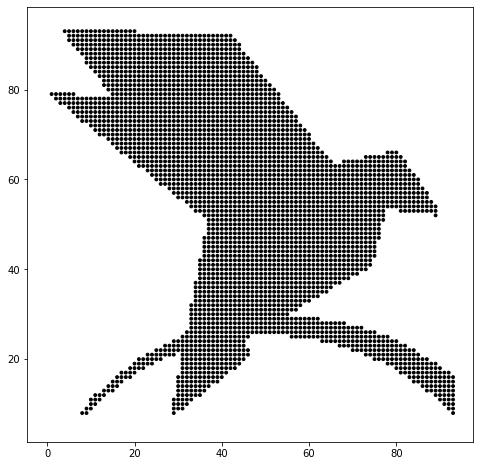

In [7]:
dic={}
c=0
for i in range(imageToMatrice.shape[0]):
    for j in range(imageToMatrice.shape[1]):
        dic[c,'x']=j
        dic[c,'y']=imageToMatrice.shape[1]-i
        dic[c,'s']=20*sum(imageToMatrice[i,j])/len(imageToMatrice[i,j])
        c+=1   
dic[c-1,'s']
dfN=pd.DataFrame()
dfN['x']=[dic[i,'x'] for i in range(c)]
dfN['y']=[dic[i,'y'] for i in range(c)]
dfN['s']=[80*(dic[i,'s']) for i in range(c)]

dfN['s']=(1*dfN['s']/dfN['s'].max() )
dfN['Dark']=1-round(dfN['s'],0)
dfN['marker']=['o' for i in range(c)]

fig= plt.figure(figsize=(8, 8))
R=20
x0=0.5*(dfN['x'].max()-dfN['x'].min())
y0=-1+0.5*(dfN['y'].max()-dfN['y'].min())
M = 300
theta =np.linspace(0,2*np.pi,M)

df=pd.DataFrame()
df['X']=x0+R*np.cos(theta)
df['Y']=3+y0+R*np.sin(theta)


plt.scatter(dfN['x'],dfN['y'],s=8*(1-dfN['Dark']), marker='o',c='k')
#plt.scatter(dfN['x'],dfN['y'],s=8*(1-dfN['Dark']), marker='.',c='b')

#plt.scatter(df['X'],df['Y'],s=8, marker='o',c='r')

dfN=dfN[dfN['Dark']==0 ]
dfN=dfN.reset_index()
dfN.describe() 

In [8]:
df = pd.DataFrame()
N=10

df['x'] = [10*random.random() for i in range(N)]
df['y'] = [10*random.random() for i in range(N)]
df['ti'] = [5*random.random() for i in range(N)]

df = dfN
N= len(df)

In [9]:
df

index   x   y         s  Dark marker
0        98   4  93  0.626367   0.0      o
1        99   5  93  0.834229   0.0      o
2       100   6  93  0.851230   0.0      o
3       101   7  93  0.841159   0.0      o
4       102   8  93  0.830582   0.0      o
...     ...  ..  ..       ...   ...    ...
3372   8083  93   9  0.846646   0.0      o
3373   8092   8   8  0.628095   0.0      o
3374   8093   9   8  0.576549   0.0      o
3375   8113  29   8  0.594815   0.0      o
3376   8177  93   8  0.584230   0.0      o

[3377 rows x 6 columns]

In [10]:
df['x'].min()
df['y'].min()

df['x'] = [x+abs(df['x'].min()) for x in df['x'] ]
df['y'] = [x+abs(df['y'].min()) for x in df['y'] ]
df['ti'] = [5*random.random() for i in range(N)]

df

index   x    y         s  Dark marker        ti
0        98   5  101  0.626367   0.0      o  1.547931
1        99   6  101  0.834229   0.0      o  4.151008
2       100   7  101  0.851230   0.0      o  2.185210
3       101   8  101  0.841159   0.0      o  1.151792
4       102   9  101  0.830582   0.0      o  4.122774
...     ...  ..  ...       ...   ...    ...       ...
3372   8083  94   17  0.846646   0.0      o  4.356165
3373   8092   9   16  0.628095   0.0      o  1.814240
3374   8093  10   16  0.576549   0.0      o  0.928237
3375   8113  30   16  0.594815   0.0      o  0.163967
3376   8177  94   16  0.584230   0.0      o  2.431196

[3377 rows x 7 columns]

In [11]:
x0, y0= 0,0 
model = AbstractModel()
model.i = RangeSet(N)
model.V0 = Var(model.i, bounds=(1,100), within=NonNegativeReals)
model.alpha = Var(model.i,bounds=(0,np.pi/2), within=Reals)
model.t = Var(bounds=(10,30), within=Reals)

def rule_x(model,i):
    return df.loc[i-1,'x']
def rule_y(model,i):
    return df.loc[i-1,'y']

model.x = Param(model.i, initialize=rule_x)
model.y = Param(model.i, initialize=rule_y)
def Rule_C1(model,i):
    return model.x[i]-x0== model.V0[i]*cos(model.alpha[i])*(model.t-df.loc[i-1,'ti']) 
model.C1=Constraint(model.i,rule=Rule_C1)

def Rule_C2(model,i):
    return model.y[i]-y0== -5*((model.t-df.loc[i-1,'ti'])**2) + model.V0[i]*sin(model.alpha[i])*(model.t-df.loc[i-1,'ti']) 
model.C2=Constraint(model.i,rule=Rule_C2)

def rule_OF(model):
    return model.t
model.obj1 = Objective(rule=rule_OF, sense=minimize)

In [12]:
opt = SolverFactory('ipopt')
instance = model.create_instance()  

In [13]:
results = opt.solve(instance) # solves and updates instance
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print ('ERROR ' + str(results.solver))
print(value(instance.obj1) )

for i in instance.i:
    print(i, value(instance.alpha[i]), value(instance.V0[i]))

this is feasible and optimal
9.99999990459325
1 1.5598841937433703 54.21331024248755
2 1.5487454207608369 46.524204021591316
3 1.5535717002092297 52.00587499882056
4 1.554552579408215 55.66312214655529
5 1.5379265232741295 46.596277505486455
6 1.545764942296637 51.71721542588887
7 1.5434429806380487 51.832981655155116
8 1.5440054511041854 53.788280970342576
9 1.514497239863324 45.367419361517285
10 1.520686272970016 46.824764594344394
11 1.5090403741361305 45.67393368479766
12 1.509962186638429 46.279614780941564
13 1.514045005013193 47.59983922895706
14 1.5038314013595218 46.490351763126824
15 1.508921739711342 47.9078387274259
16 1.5082152522882597 48.41276110152511
17 1.507093999348742 48.82848943417844
18 1.5600699579161583 58.36077811712461
19 1.5408114789375245 45.20628744976672
20 1.5419004531423006 46.56763319352451
21 1.5552122591400948 59.100747852647906
22 1.5402042026283786 48.544628140063296
23 1.5428442158270956 51.37703872444866
24 1.5429022236075733 52.95366718239648
25

794 1.425049525452256 42.515989671207514
795 1.445651688711004 44.39152789076113
796 1.4492433250097563 45.13242717775303
797 1.4637093323364403 47.360465403252896
798 1.4853667507284452 51.825216345736024
799 1.5025324756741807 57.2292770563159
800 1.4406050817534926 45.71980400804105
801 1.4186211936462318 44.12322199106421
802 1.4079386610625522 43.686145011265694
803 1.3753150780355352 42.38793592175743
804 1.3997906645810432 43.7226370481251
805 1.4254822148838868 45.94906296727753
806 1.3710510551217727 42.816448448120795
807 1.4845820240919096 56.296798079639515
808 1.4633704459575823 52.10918737952843
809 1.4098272930997044 45.81905585411689
810 1.434895901236182 48.649619507182074
811 1.4315033618377766 48.591047880188235
812 1.4567988938397693 52.58785712659829
813 1.3905181987630149 45.4798724408737
814 1.4260529893082525 48.962082047855354
815 1.4657775077125774 55.52948339511773
816 1.4540972521779163 53.68134100961581
817 1.4513053285596038 53.57568602061011
818 1.4334046

1460 1.4551583965500816 45.835719992508736
1461 1.4130349947292056 41.82202902531167
1462 1.486111280913698 52.72683889090858
1463 1.4920955059085987 54.91683336651063
1464 1.359029997026407 39.74903154472253
1465 1.4550084878062552 47.99423102678591
1466 1.3482599065720897 39.80146839068795
1467 1.407580424269503 43.328909097970744
1468 1.4752872840857458 53.19257906661448
1469 1.3441507606734044 40.28100860192357
1470 1.4824215347833714 55.93173462059999
1471 1.3870125077125743 42.977378225327776
1472 1.3359405167893283 40.61059284709215
1473 1.457927453597154 51.87762921085364
1474 1.446360958409848 50.311943113989045
1475 1.3746930213022794 43.247241368287014
1476 1.3904622345711115 44.664419222996855
1477 1.4597838721941003 53.88639778379664
1478 1.3246173664572145 41.423889906808405
1479 1.3867214925960551 45.217652754011205
1480 1.3159776529940013 41.50540209585592
1481 1.4188371330889147 49.006585395208695
1482 1.4180516074530394 49.23512119686558
1483 1.4350228321006087 51.864

2127 1.361886173778168 45.40389155297477
2128 1.431130039643078 53.54497548287419
2129 1.3278600146851283 43.566599822208886
2130 1.2485575134476592 40.36112341853465
2131 1.2413914914355 40.33212118239142
2132 1.1944315682899649 39.44833657477365
2133 1.430594629520208 55.09711181294053
2134 1.256069406627888 41.327940244853764
2135 1.2510828684065038 41.34315009845481
2136 1.4107578978188686 39.808298970586044
2137 1.377061353177514 37.907613188712624
2138 1.4522911610271958 45.21467645341688
2139 1.3876976988220053 39.14944170876267
2140 1.436111177429581 43.88881466427028
2141 1.345534636738549 37.517669328299235
2142 1.4833569083940787 53.35244226170596
2143 1.4521913753248454 47.4171089826113
2144 1.4545700958679562 48.24597112474026
2145 1.3780785426537545 40.358891382414235
2146 1.3619874612411704 39.650104562612206
2147 1.425861516577043 45.360102007015776
2148 1.3635853201652908 40.30082884085893
2149 1.3188179587914075 38.37124162244389
2150 1.3379841160950858 39.43773692600

2914 1.3729431067434408 37.42956114179812
2915 1.4553628621938748 47.3504172135625
2916 1.4293085348642283 43.72669423565956
2917 1.3326479614057334 35.84976589713914
2918 1.4661565446578593 50.90944819141935
2919 1.3880726331669178 40.34363086364025
2920 1.39658054327317 41.48602841472741
2921 1.4502405422284754 49.057372922630314
2922 1.2951617964277768 35.417056907480784
2923 1.3876221031647933 41.641238809676715
2924 1.4118861271948144 44.55534901485023
2925 1.3894182599470943 42.4688452004921
2926 1.4444058163137226 50.0573955597859
2927 1.2333394162679576 34.403157444759486
2928 1.241382495663366 34.86512099514546
2929 1.279240111793489 36.4742089094722
2930 1.3565271232287963 41.160718420540704
2931 1.306199253899291 38.231654701727074
2932 1.2239519877521312 35.197509686739195
2933 1.2886901964735678 37.85144682583011
2934 1.4150481189278128 48.404365355229146
2935 1.2135134775165115 35.51629469180594
2936 1.2724524869436893 37.81606409637164
2937 1.4377024473524747 52.99331878

0.0
0.21999999790105154
0.4399999958021031
0.6599999937031547
0.8799999916042062
1.0999999895052577
1.3199999874063093
1.5399999853073607
1.7599999832084123
1.979999981109464
2.1999999790105154
2.419999976911567
2.6399999748126186
2.8599999727136702
3.0799999706147214
3.299999968515773
3.5199999664168247
3.7399999643178763
3.959999962218928


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


4.179999960119979
4.399999958021031
4.619999955922082
4.839999953823134
5.059999951724185
5.279999949625237
5.499999947526288
5.7199999454273405
5.939999943328392
6.159999941229443
6.379999939130495
6.599999937031546
6.819999934932598
7.039999932833649
7.2599999307347005
7.479999928635753
7.699999926536804
7.919999924437856
8.139999922338907
8.359999920239957
8.57999991814101
8.799999916042061
9.019999913943114
9.239999911844164
9.459999909745216
9.679999907646268
9.899999905547318
9.99999990459325
9.99999990459325
9.99999990459325
9.99999990459325
9.99999990459325
10.11999990344837
10.339999901349422
10.559999899250474
10.779999897151525
10.999999895052577
11.219999892953629
11.439999890854681
11.659999888755731
11.879999886656783
12.099999884557835
12.319999882458886
12.539999880359938
12.75999987826099
12.97999987616204
13.199999874063092
13.419999871964144
13.639999869865196
13.859999867766247
14.079999865667299
14.29999986356835
14.519999861469401
14.739999859370453
14.95999985727

<Figure size 864x864 with 0 Axes>

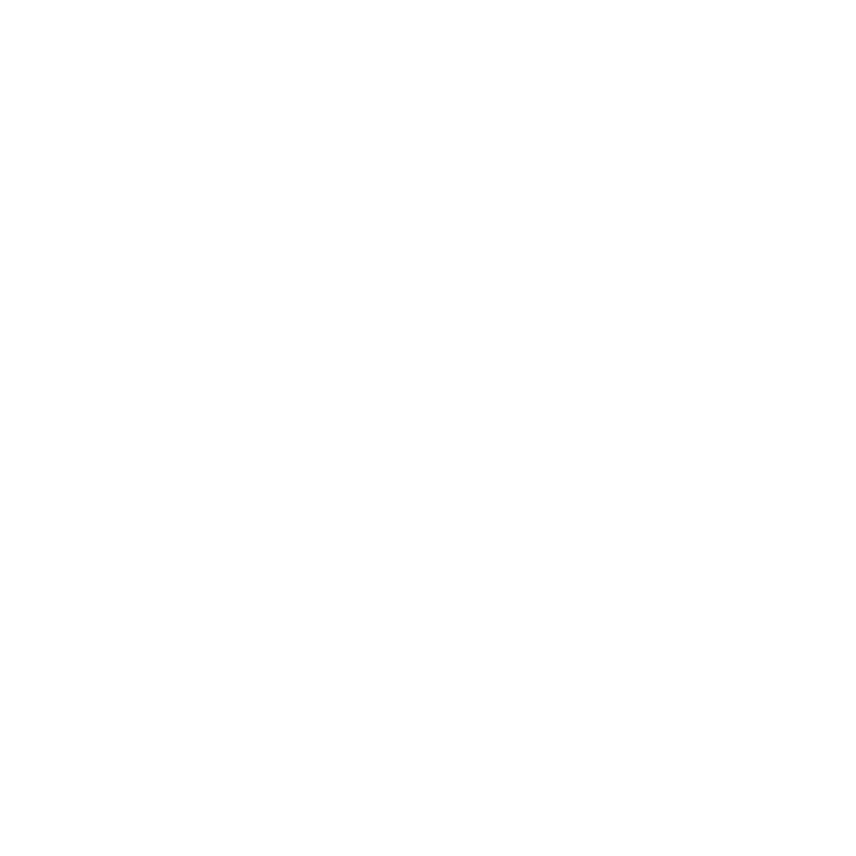

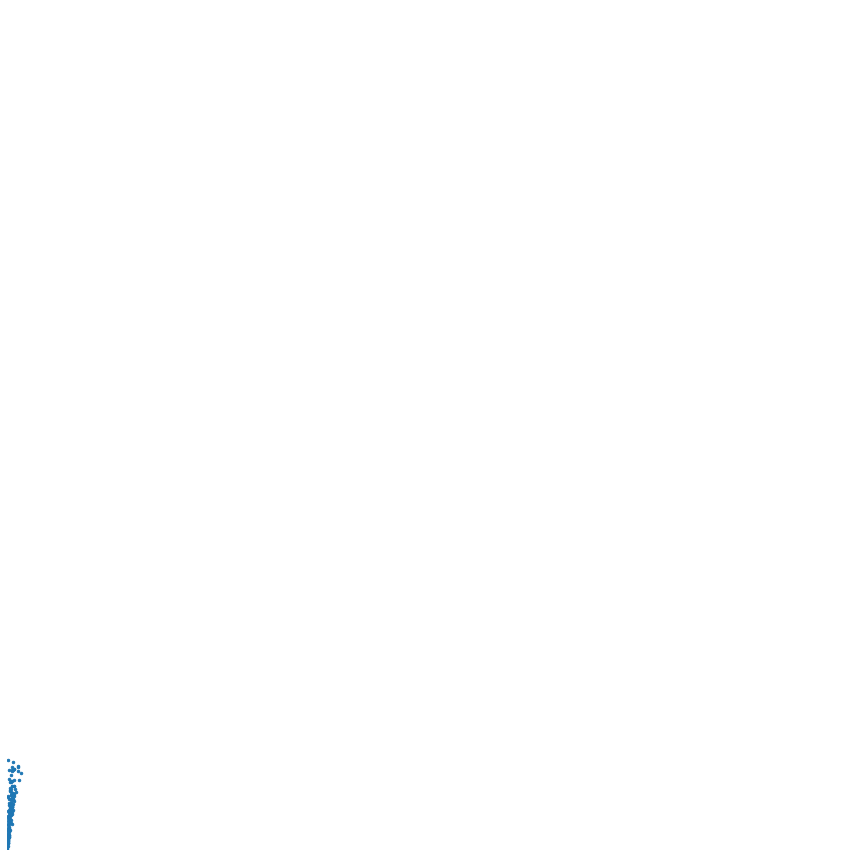

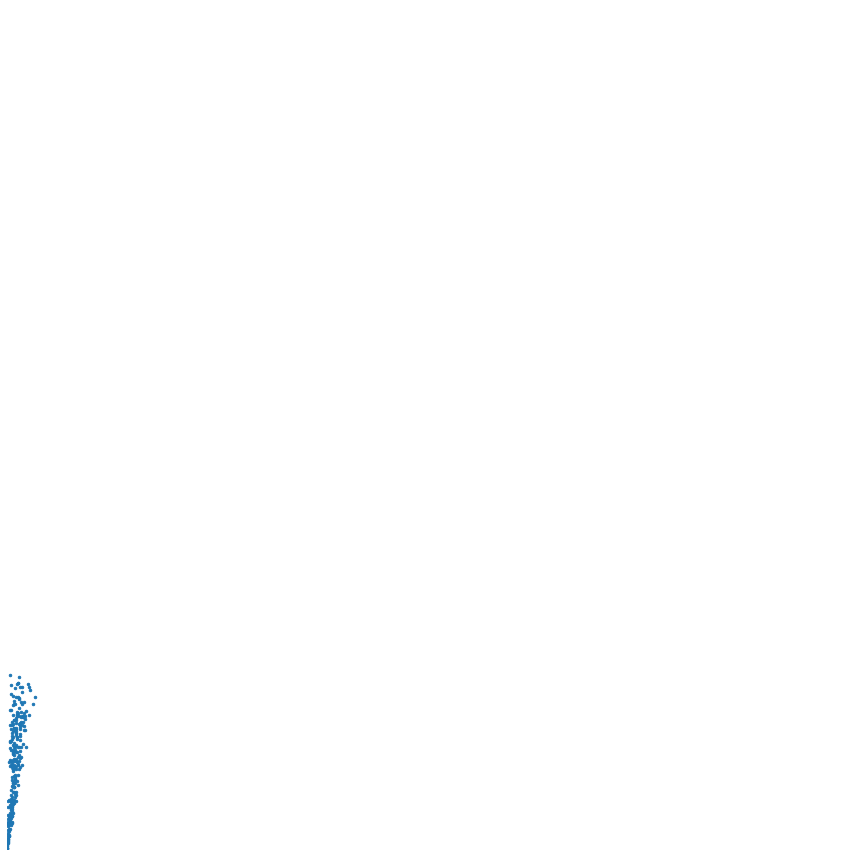

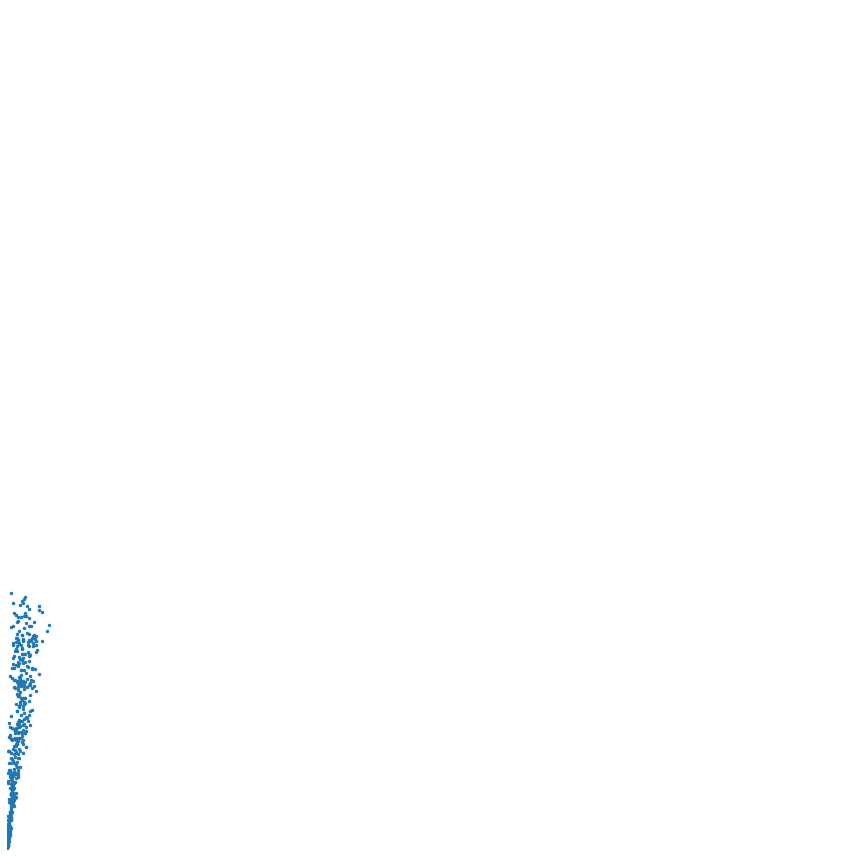

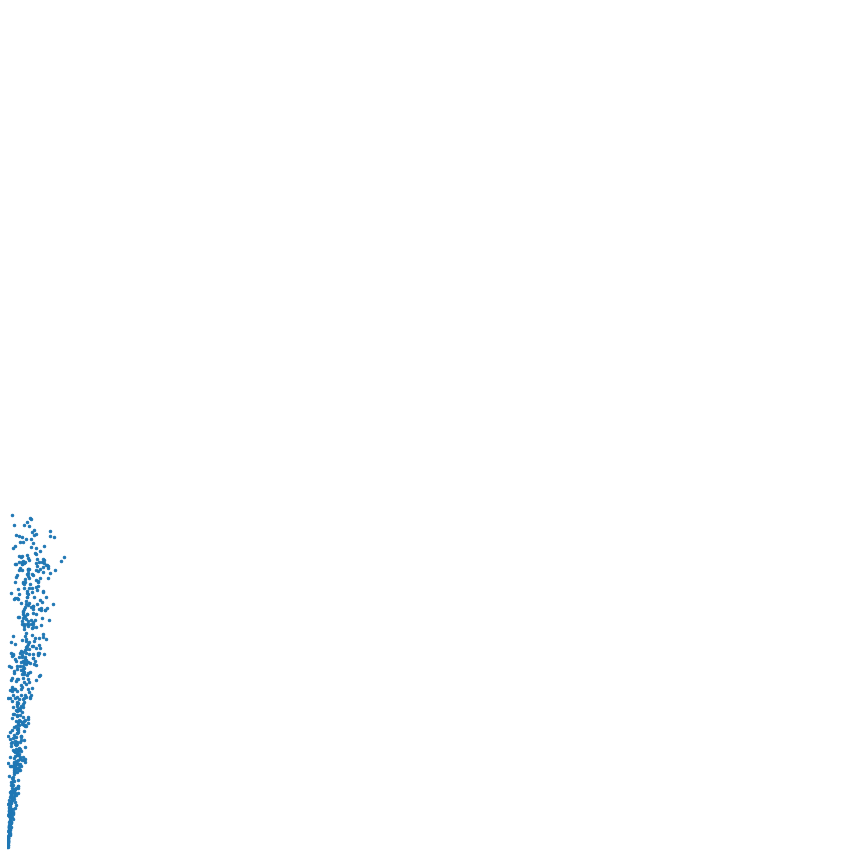

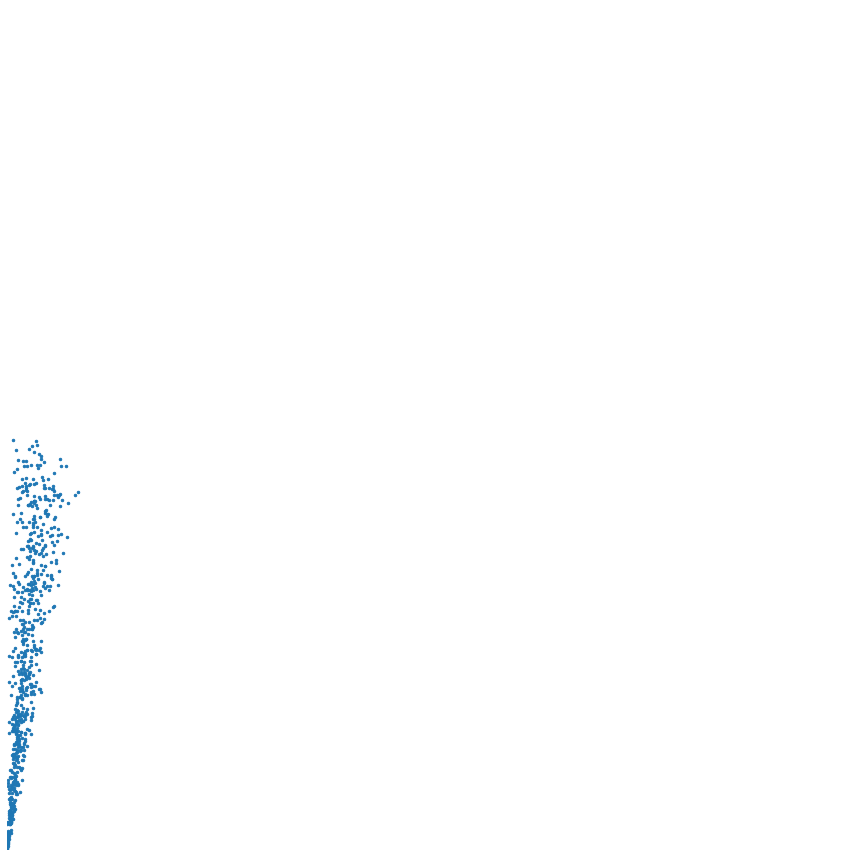

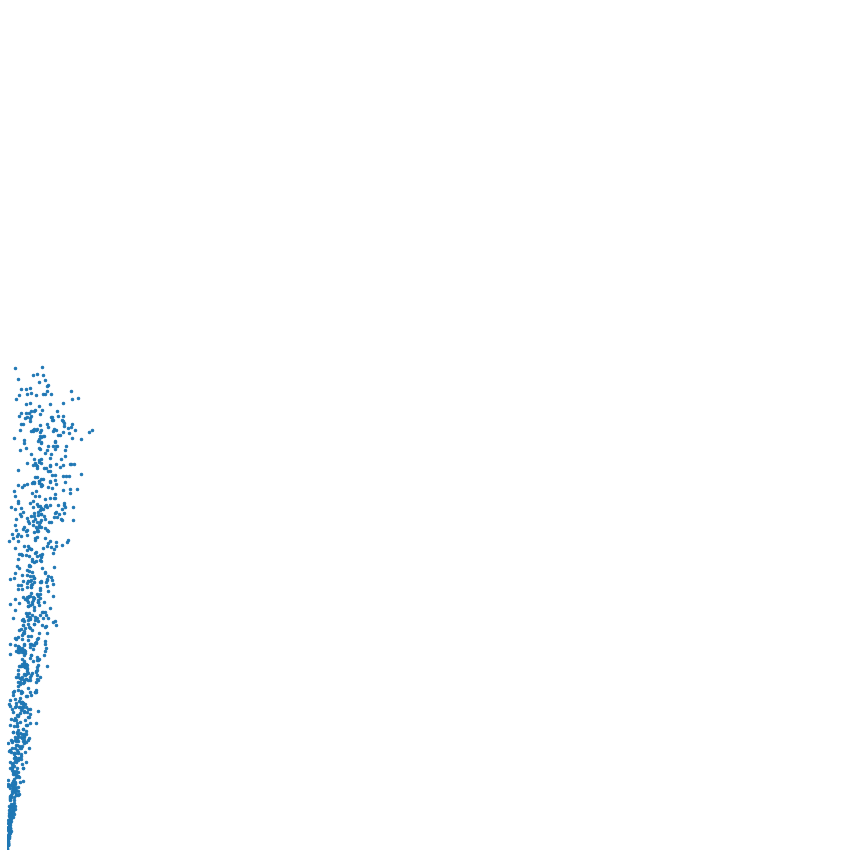

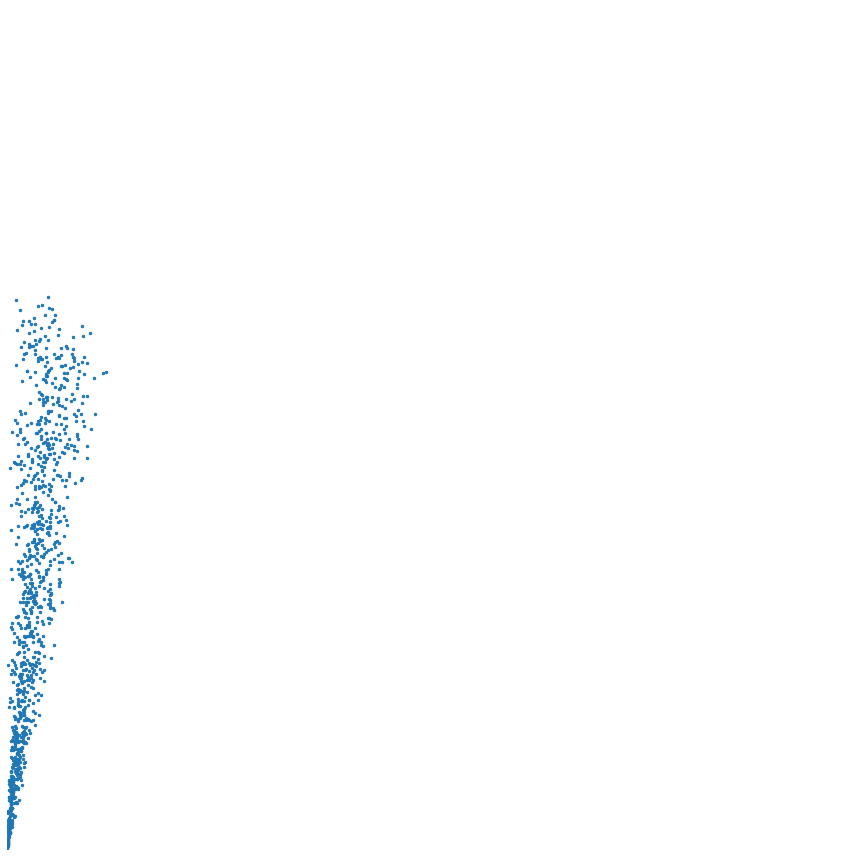

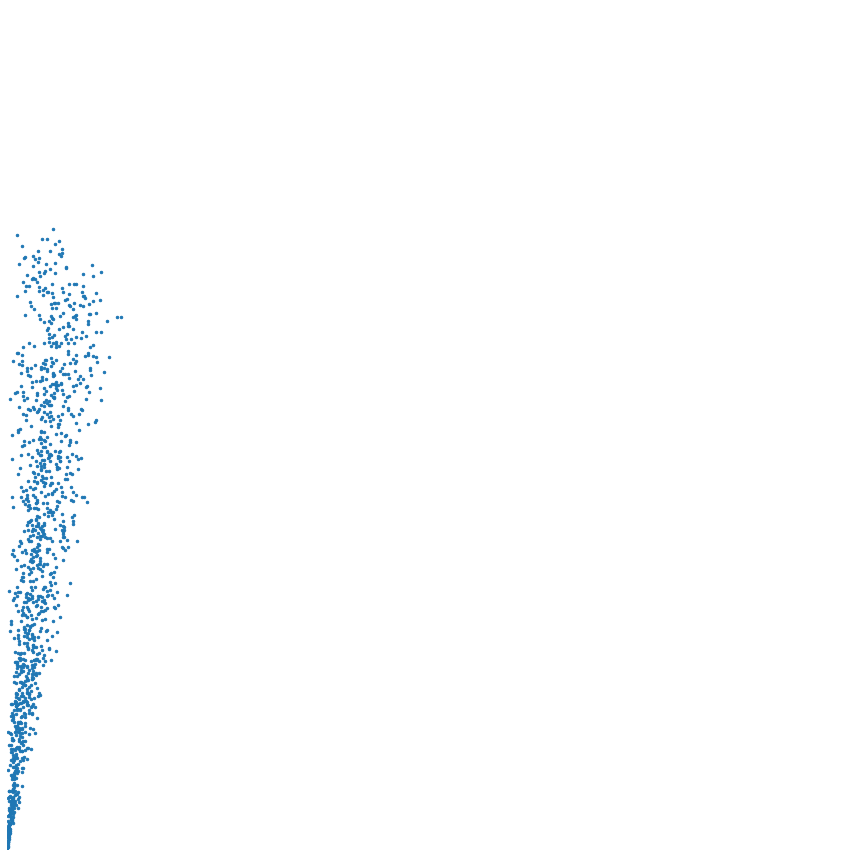

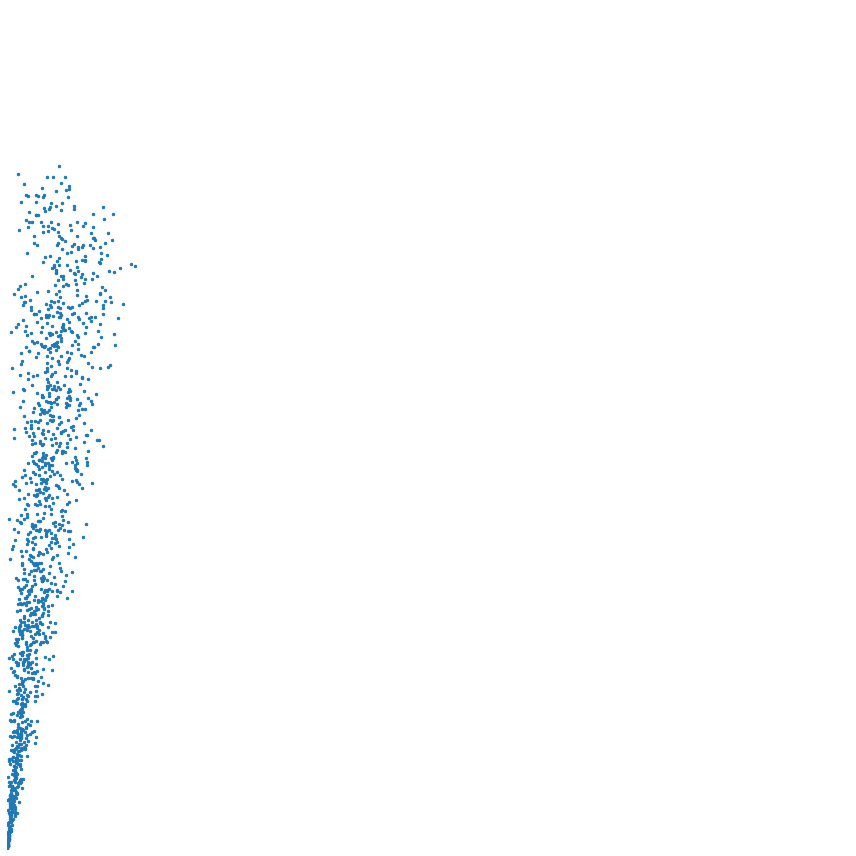

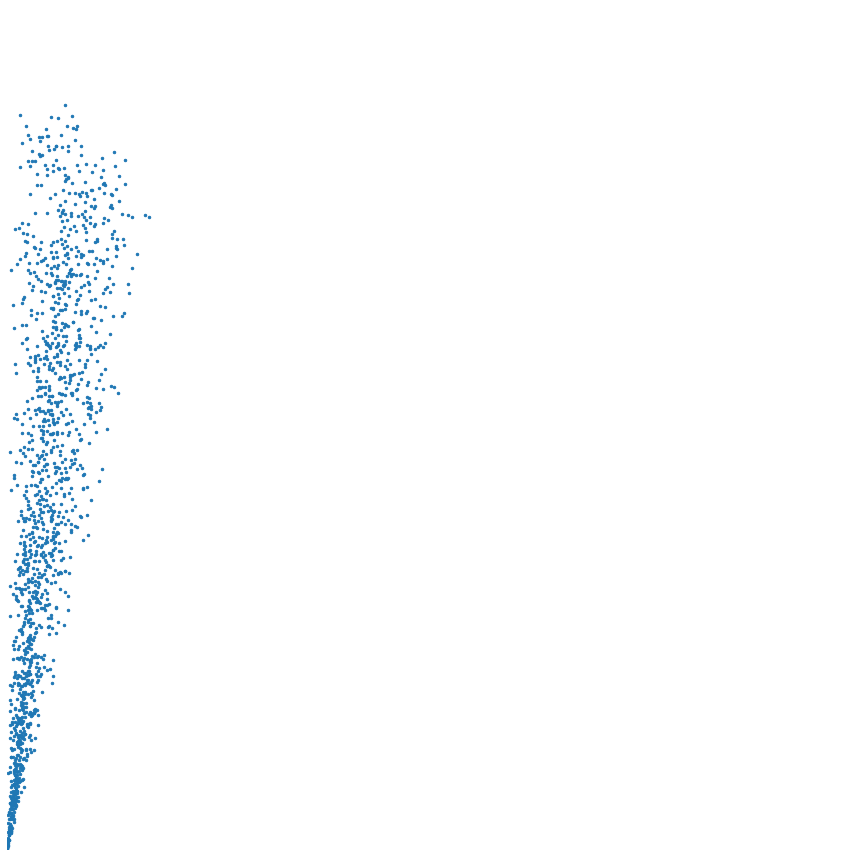

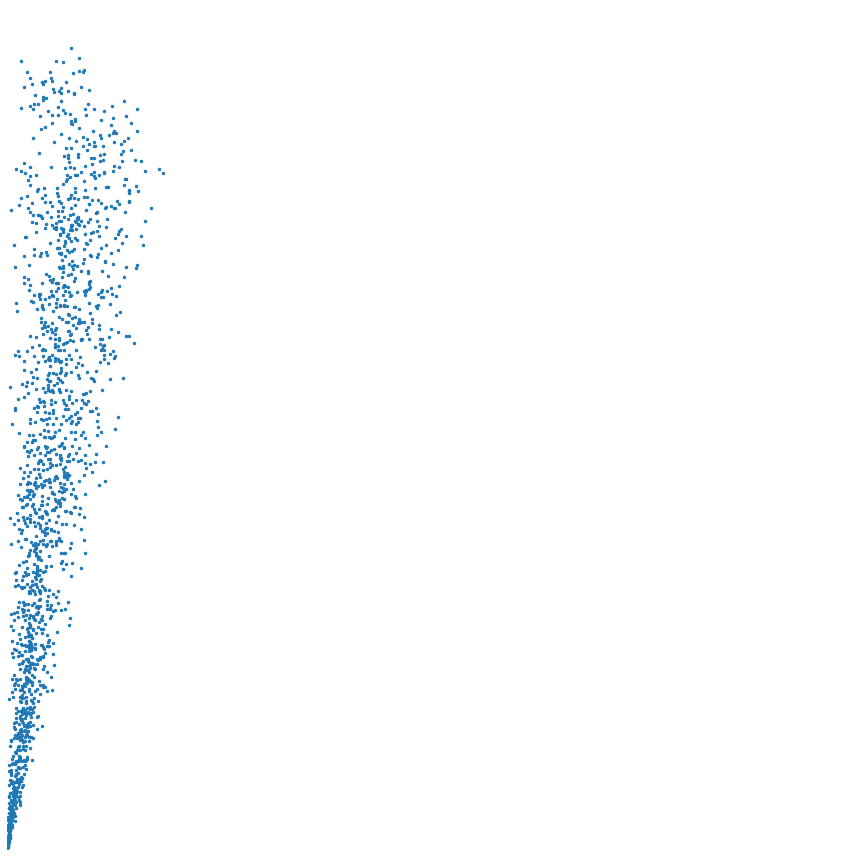

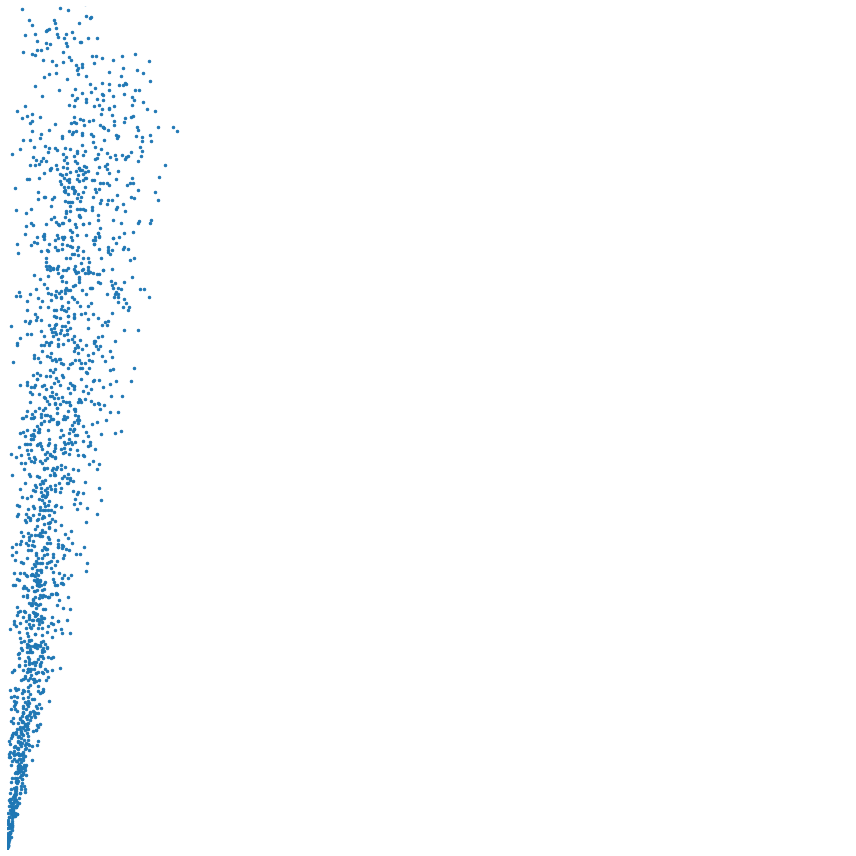

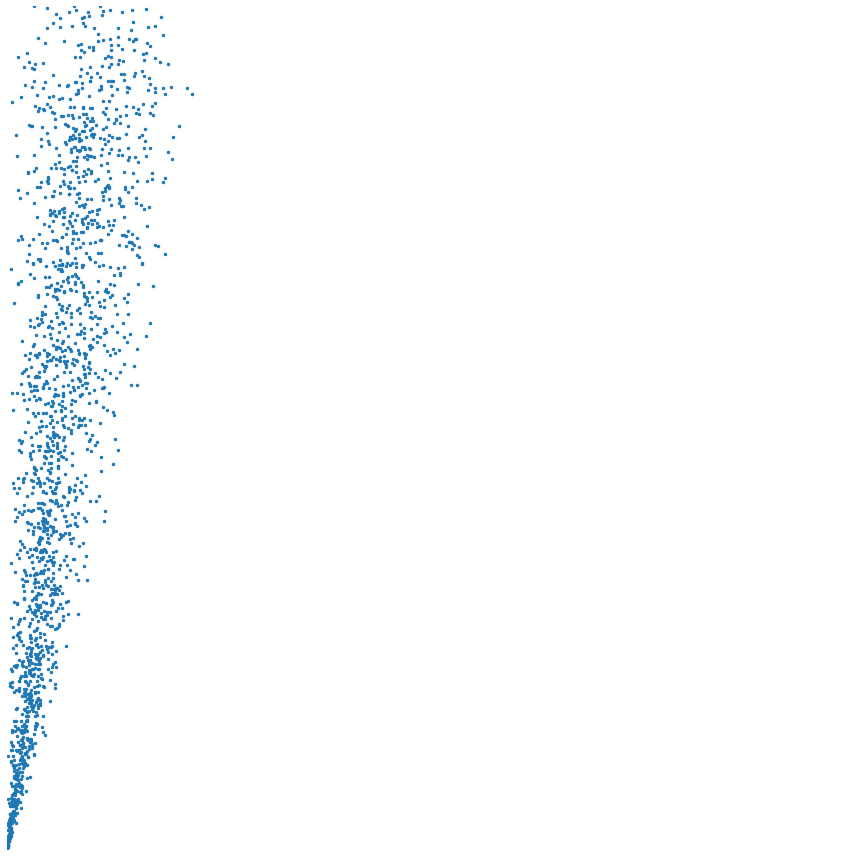

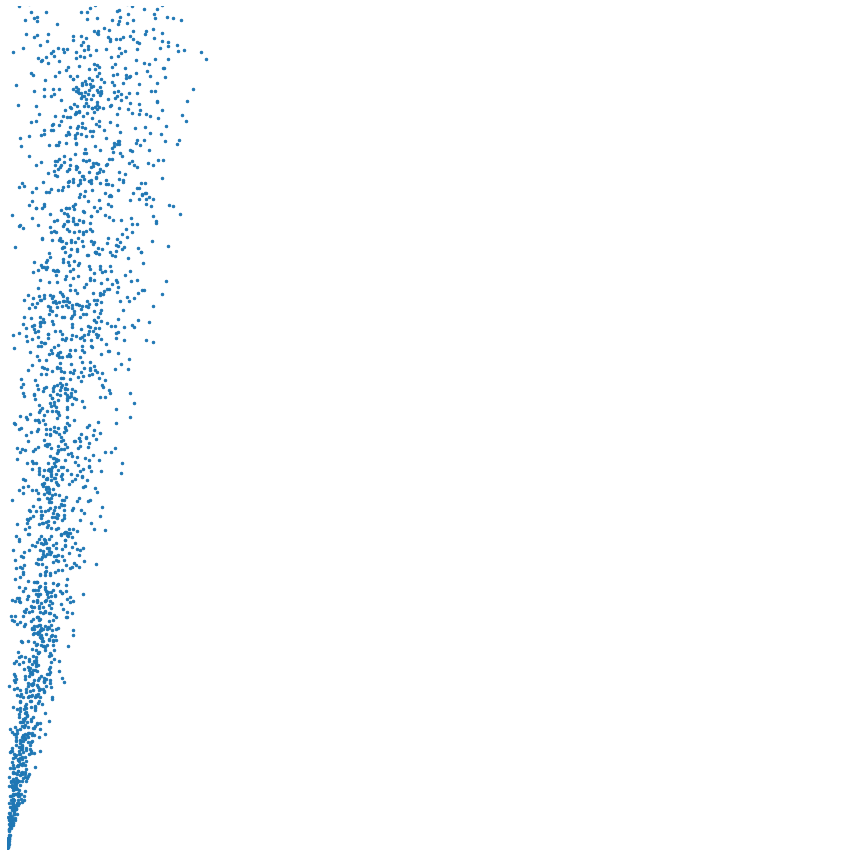

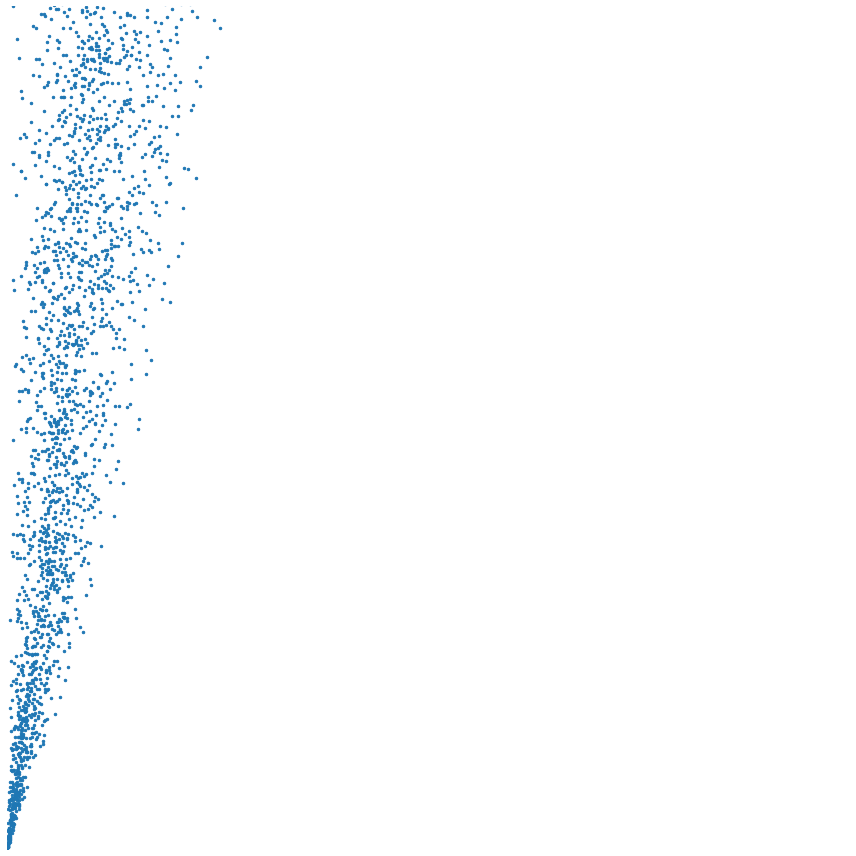

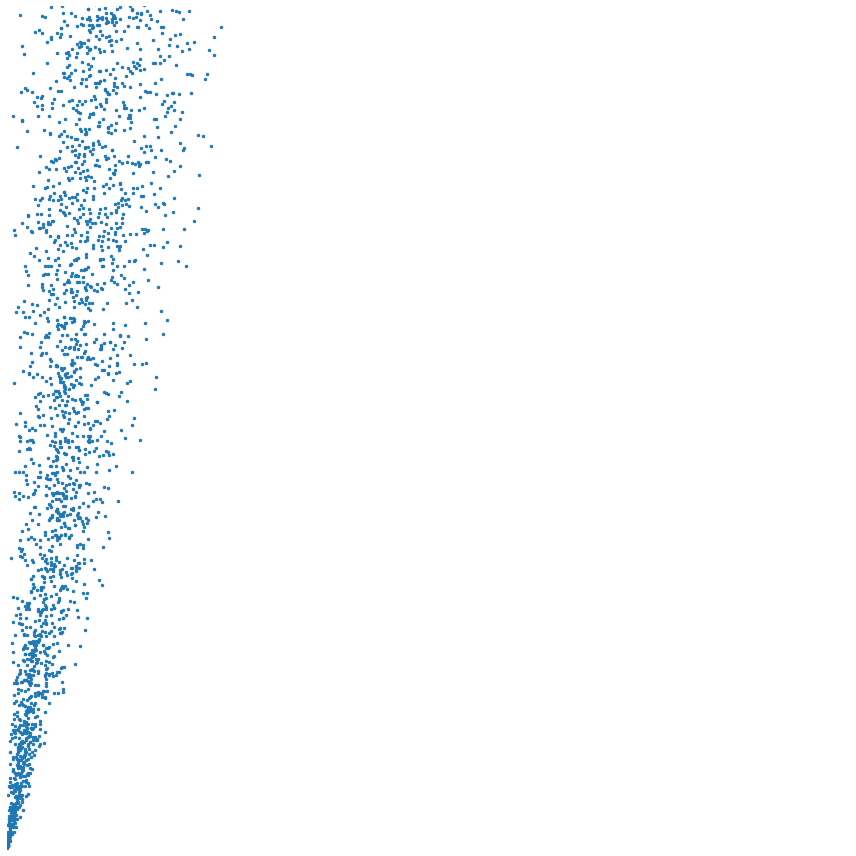

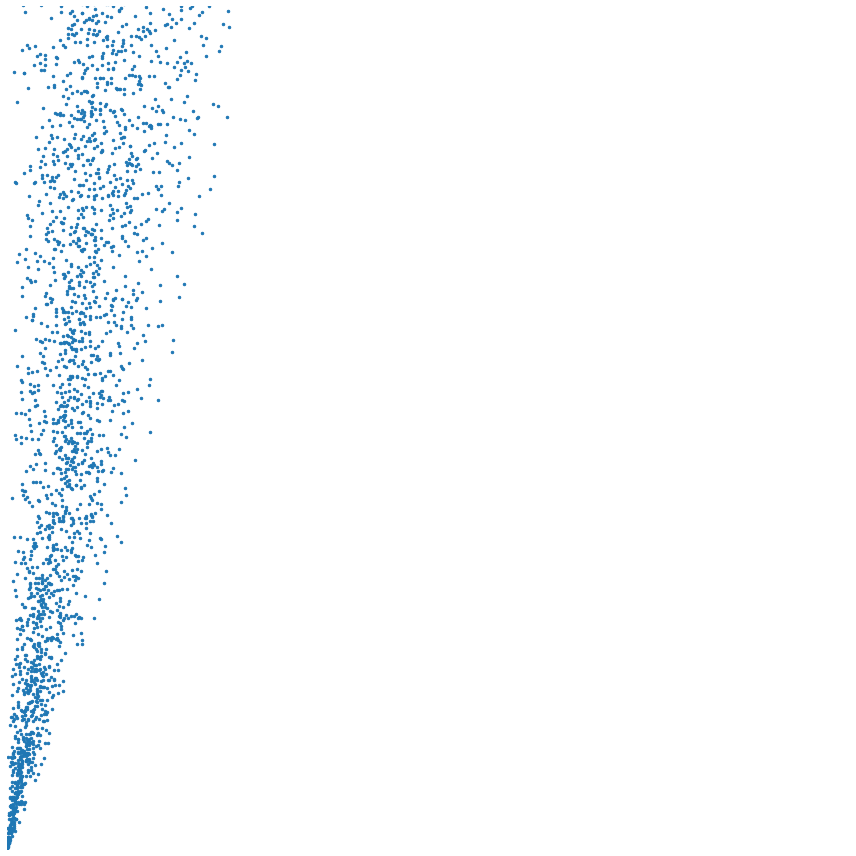

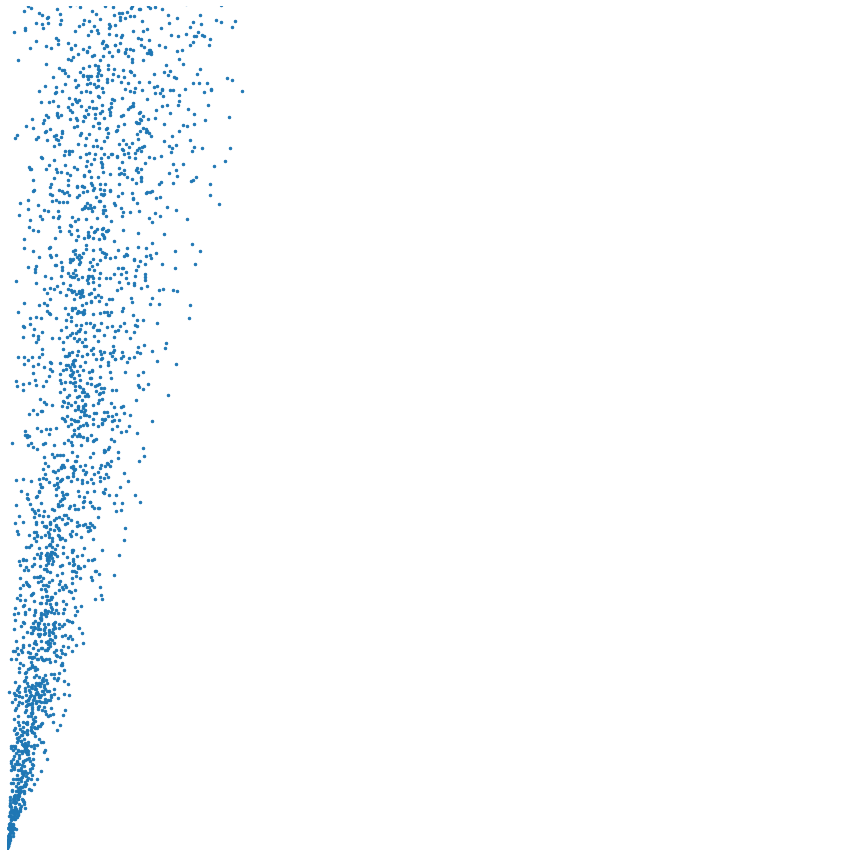

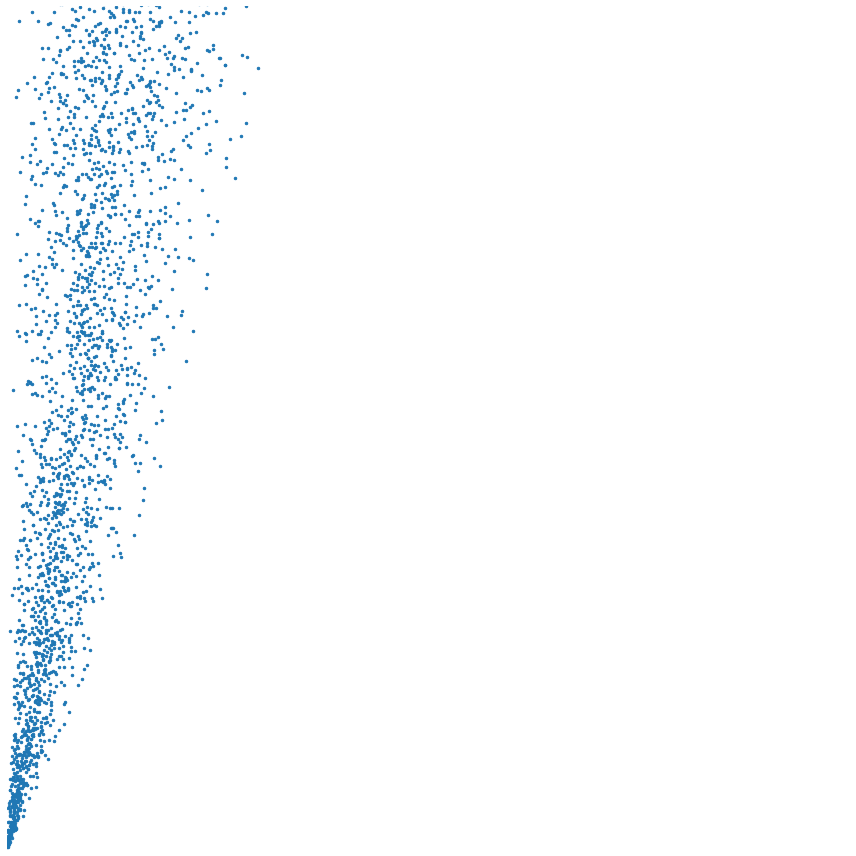

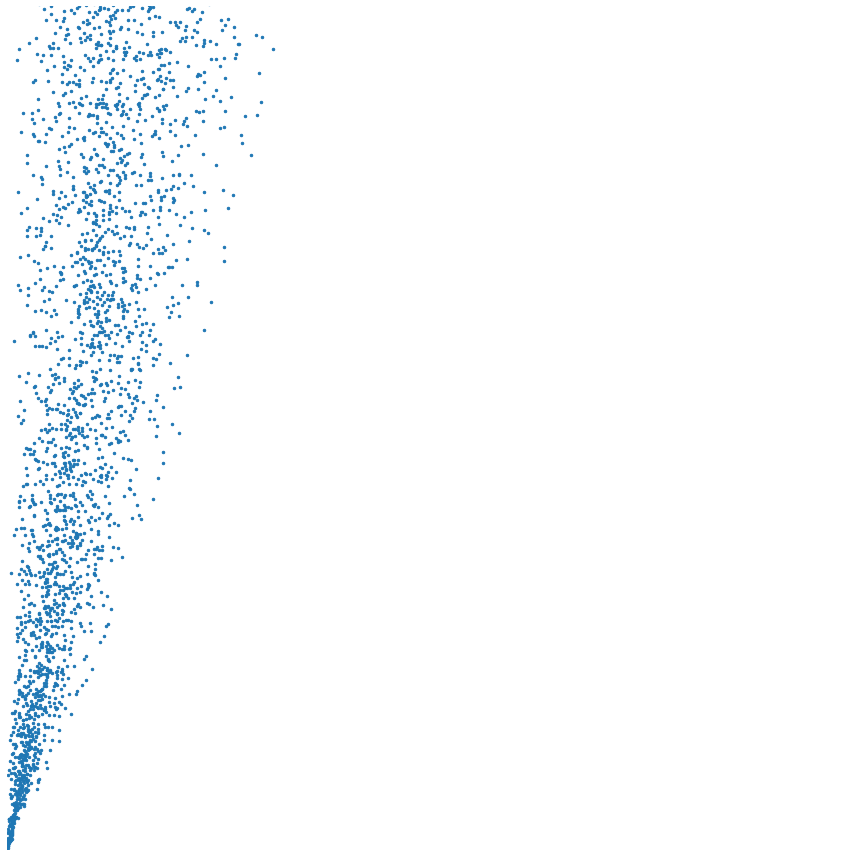

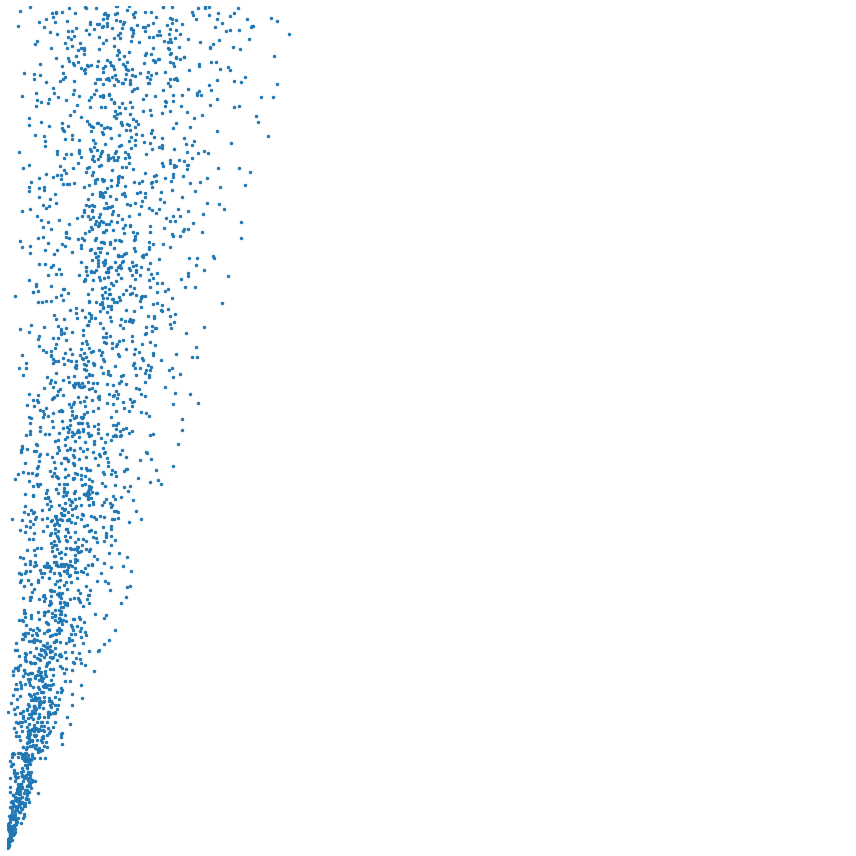

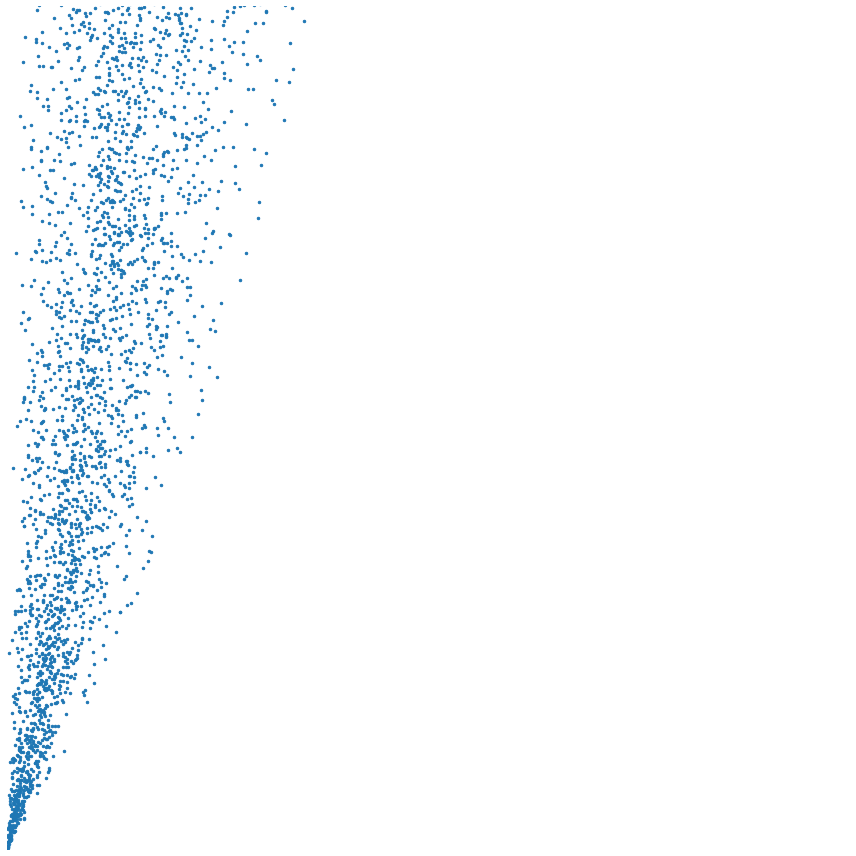

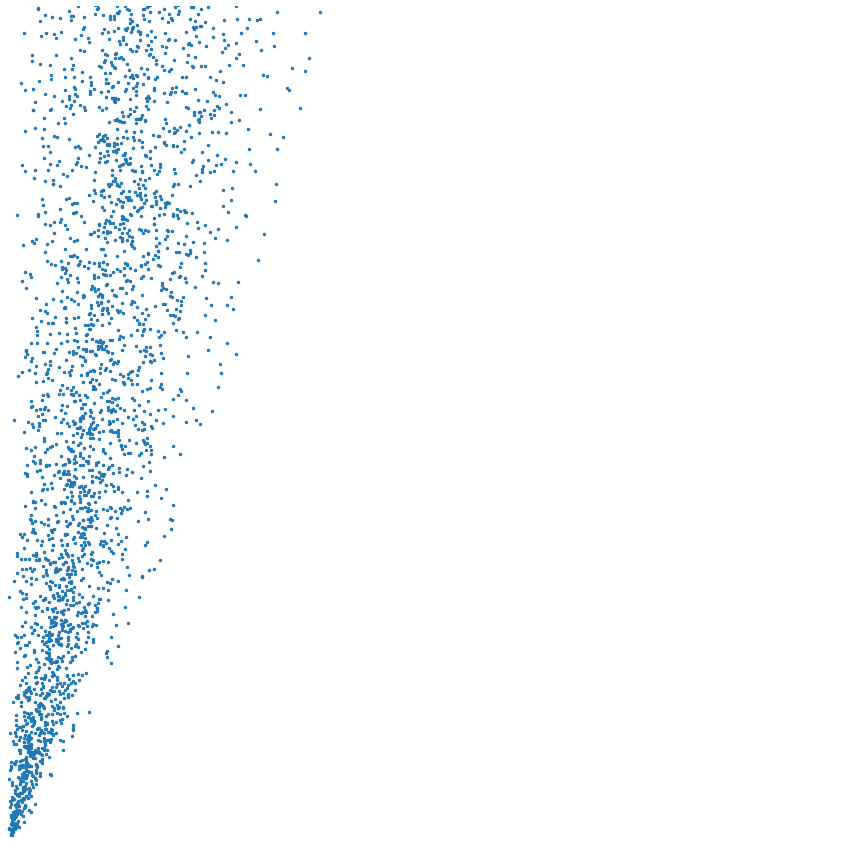

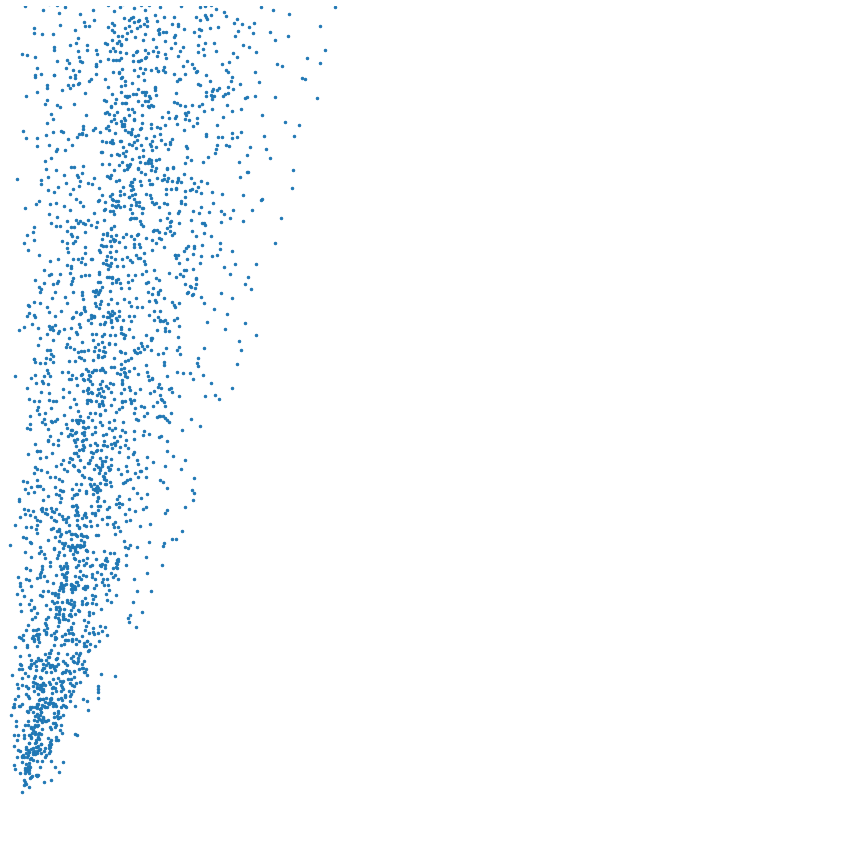

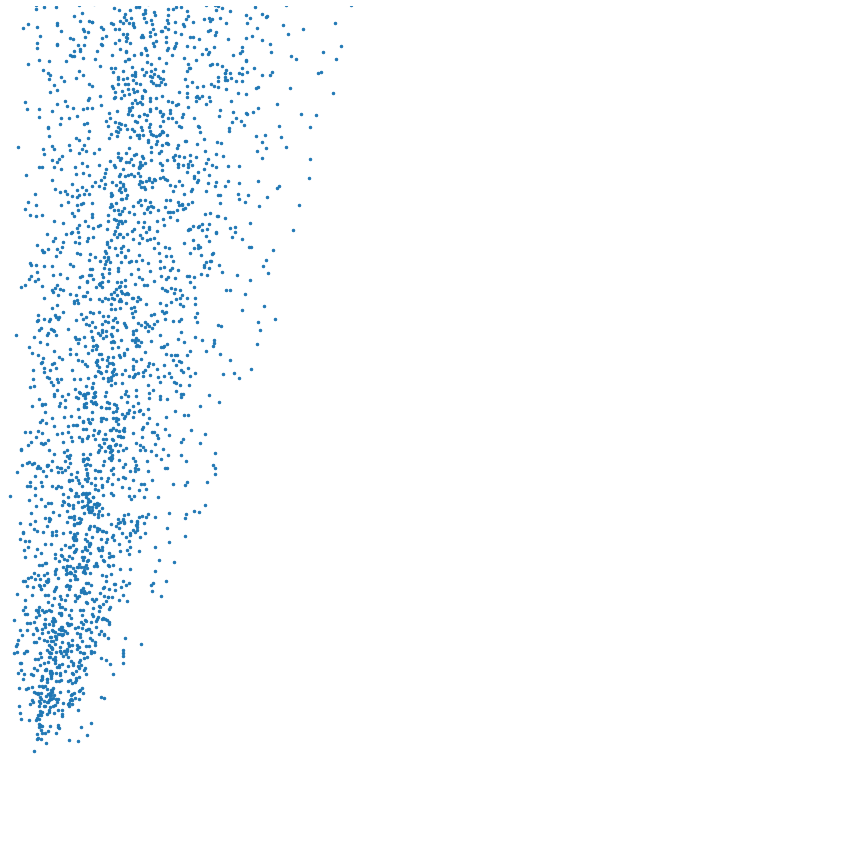

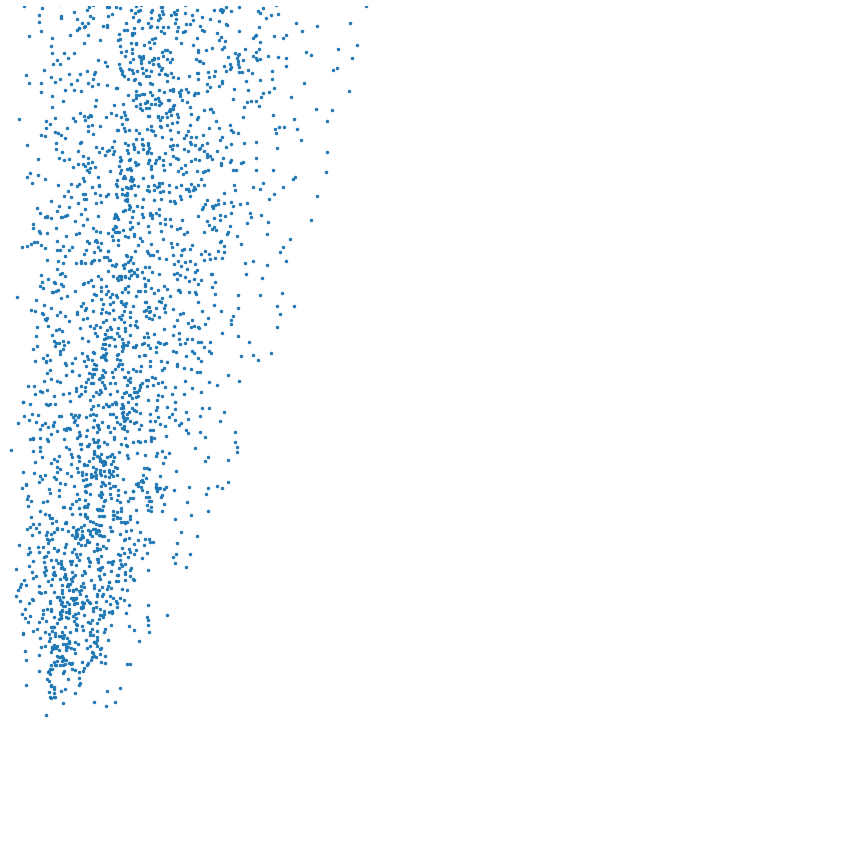

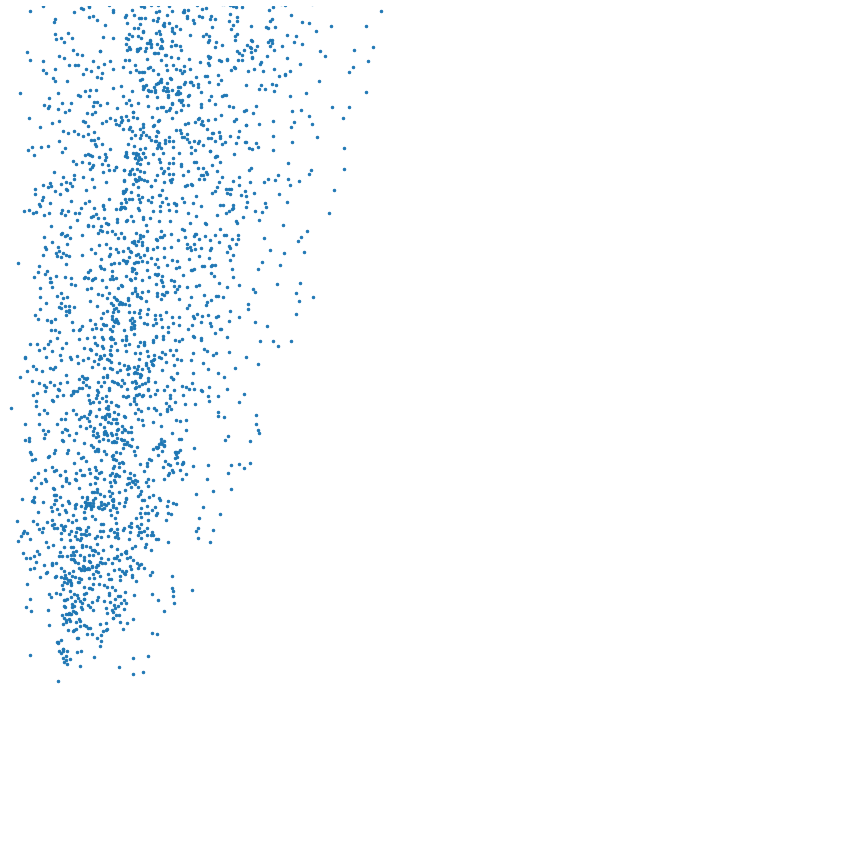

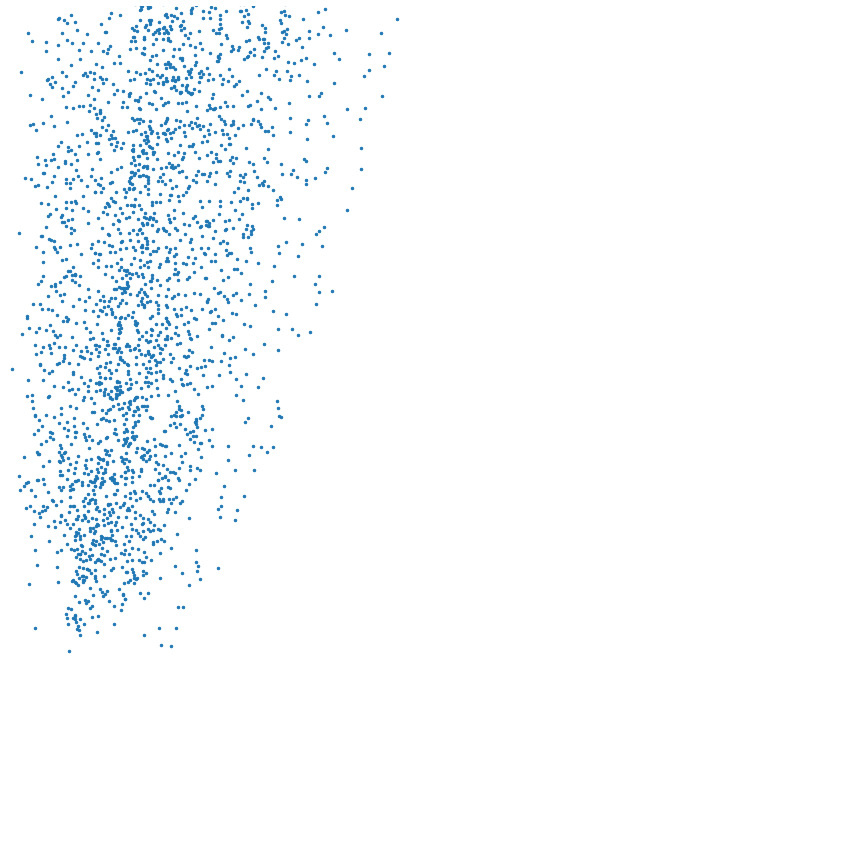

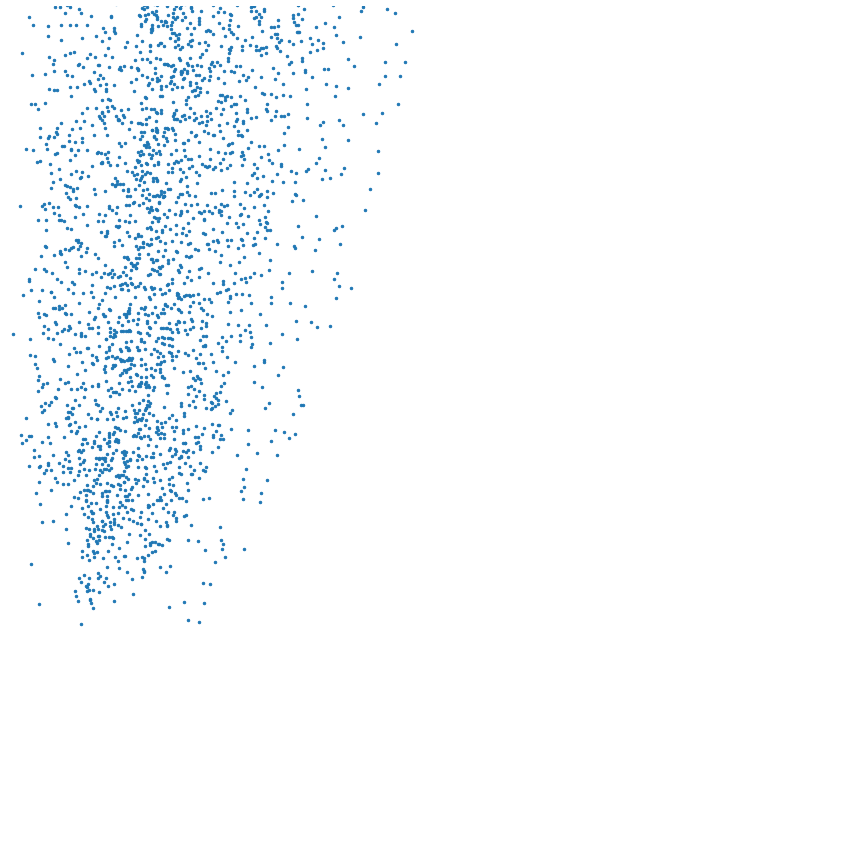

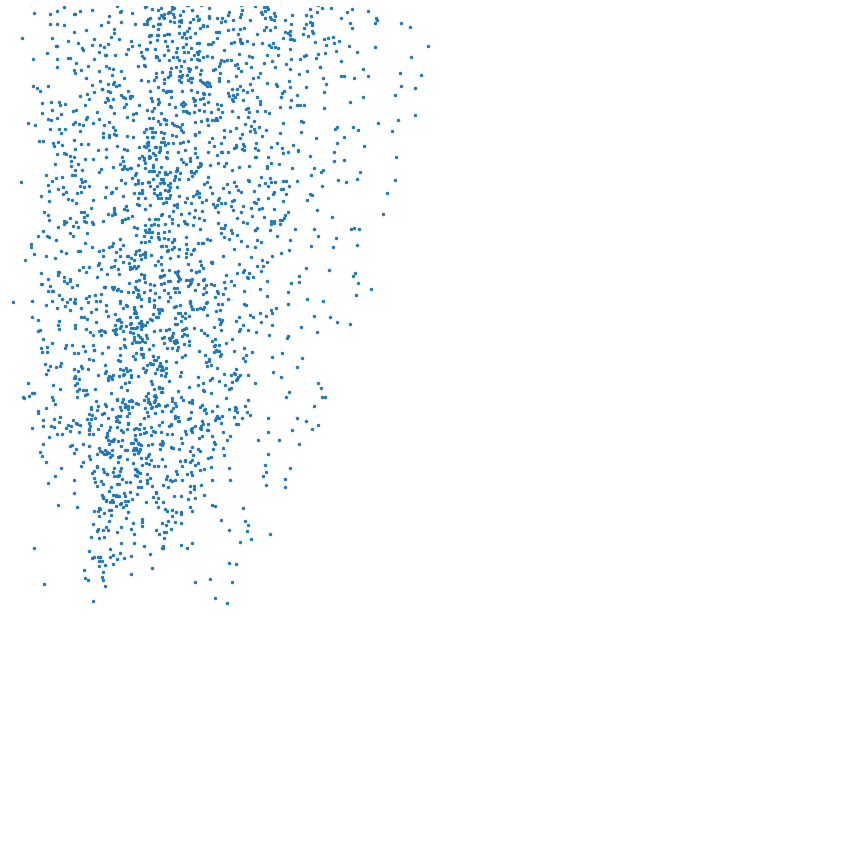

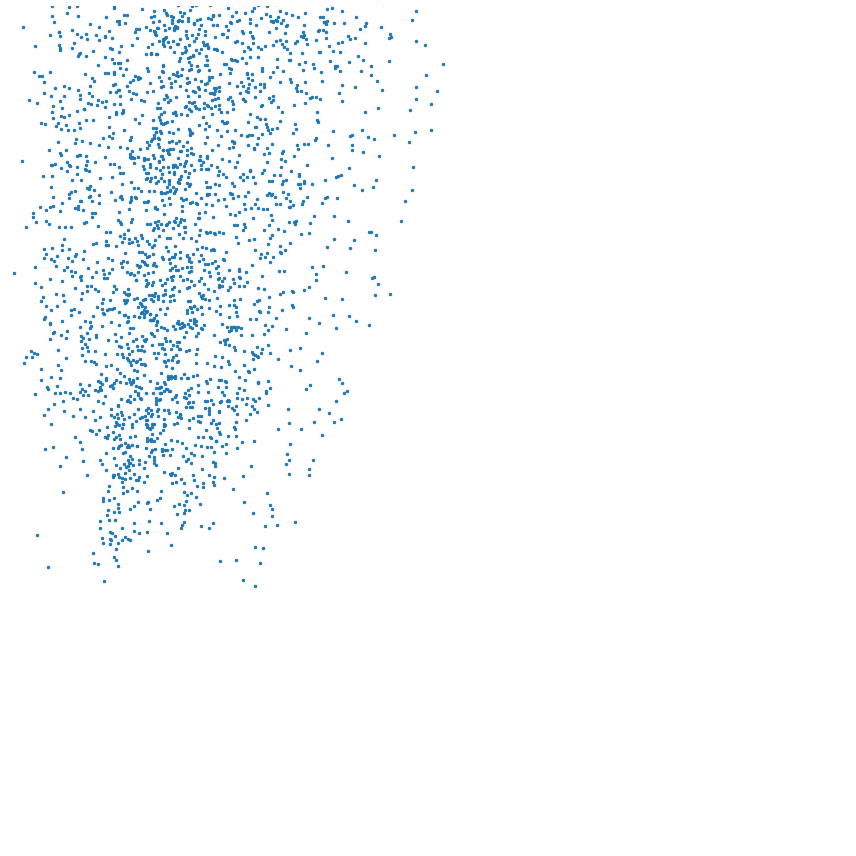

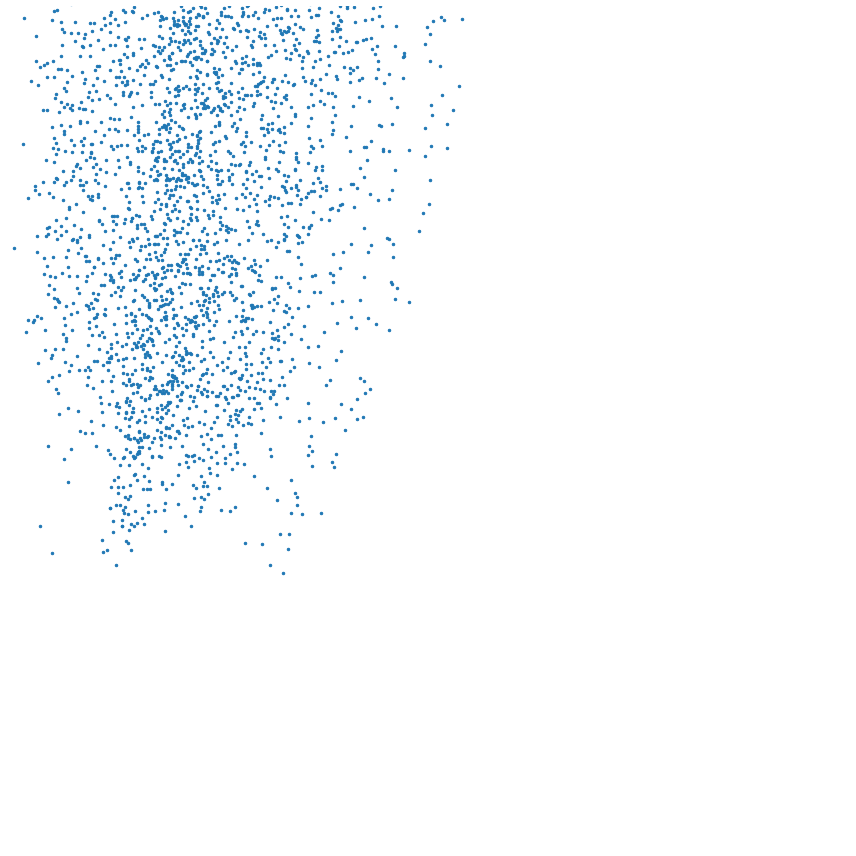

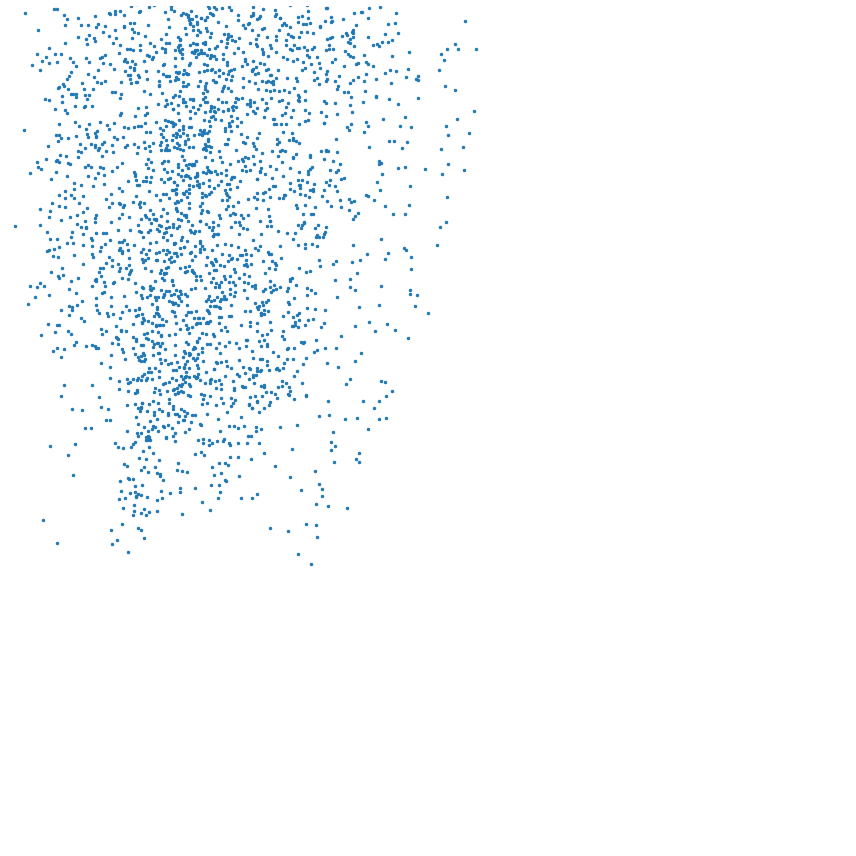

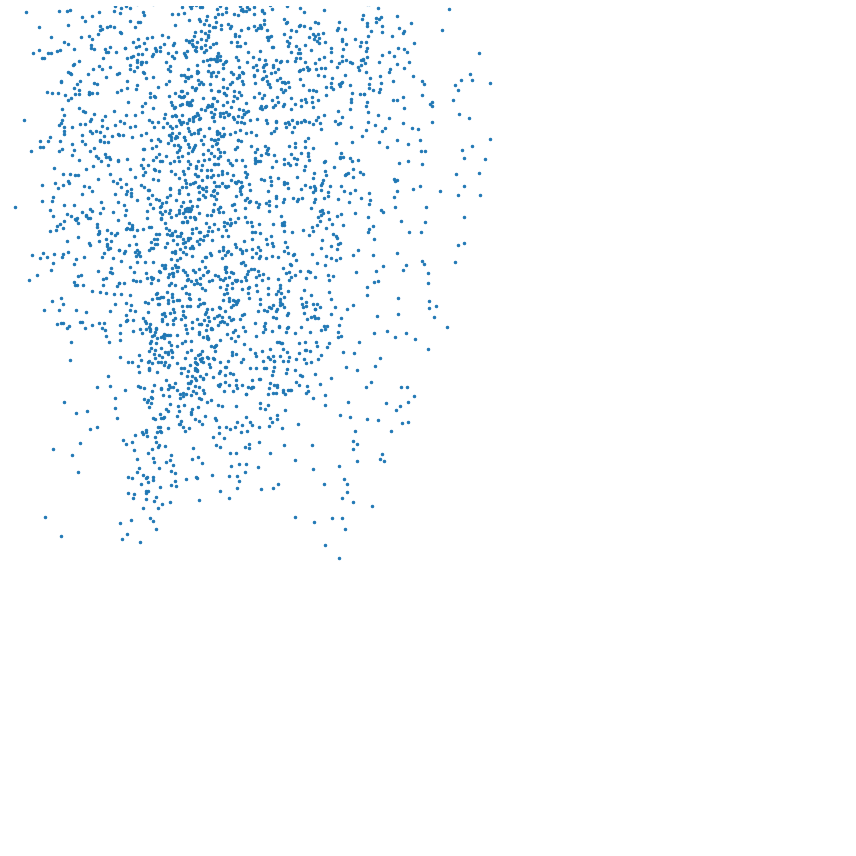

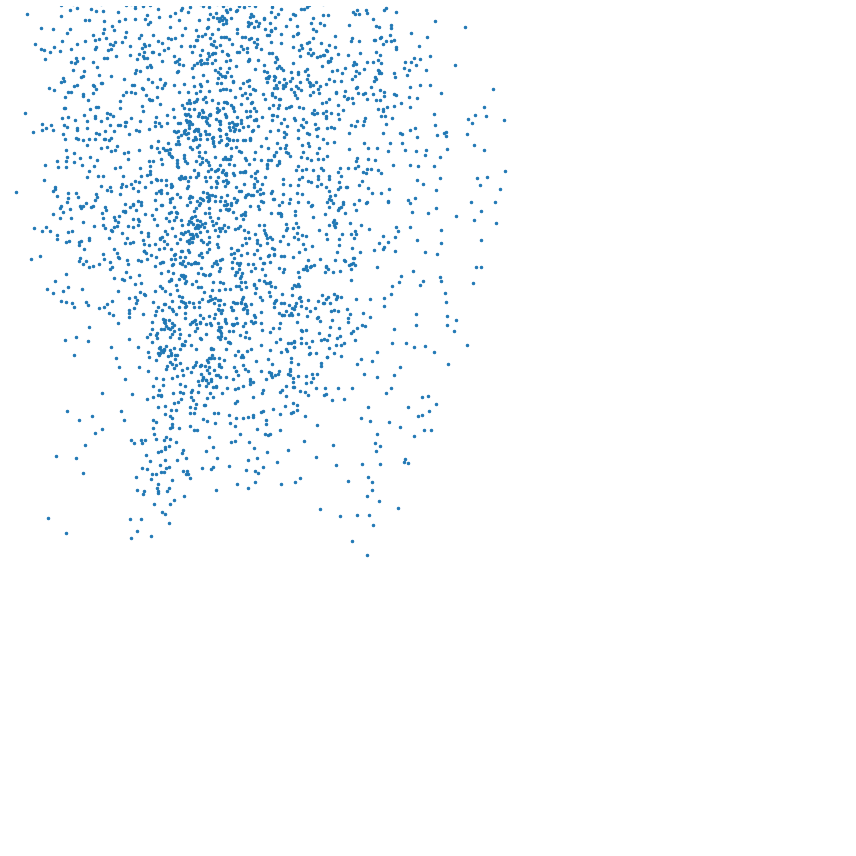

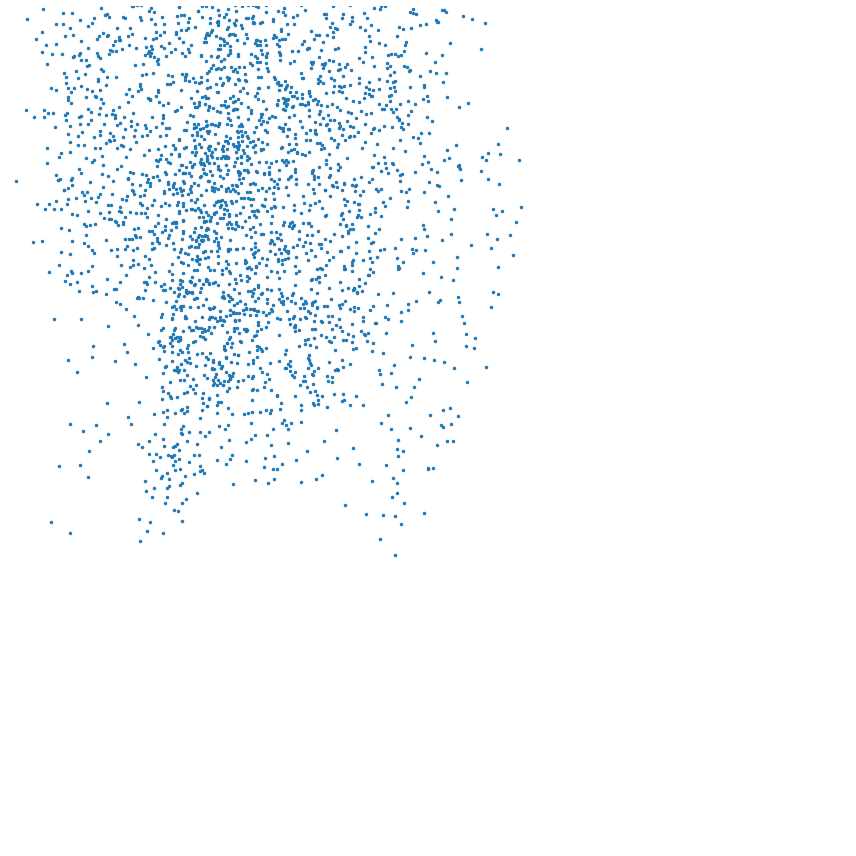

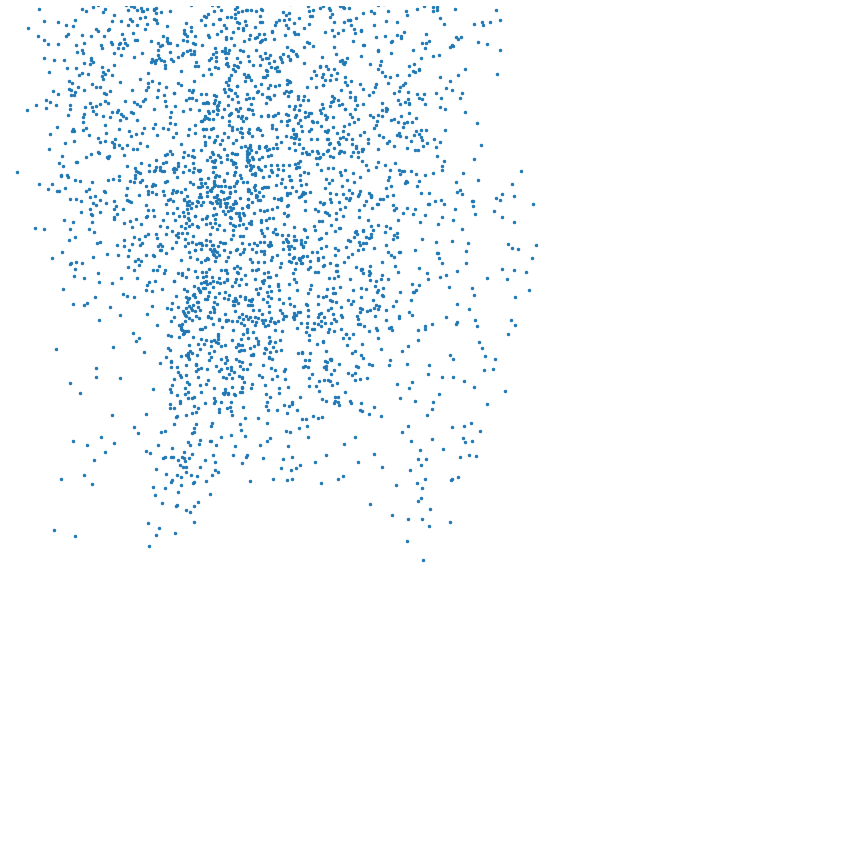

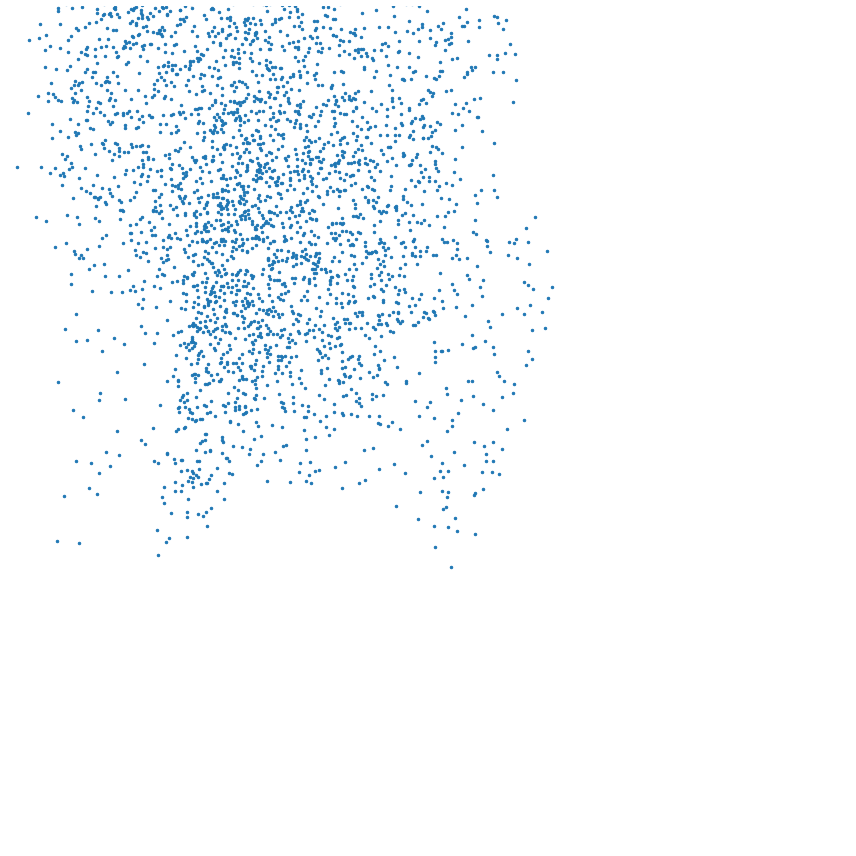

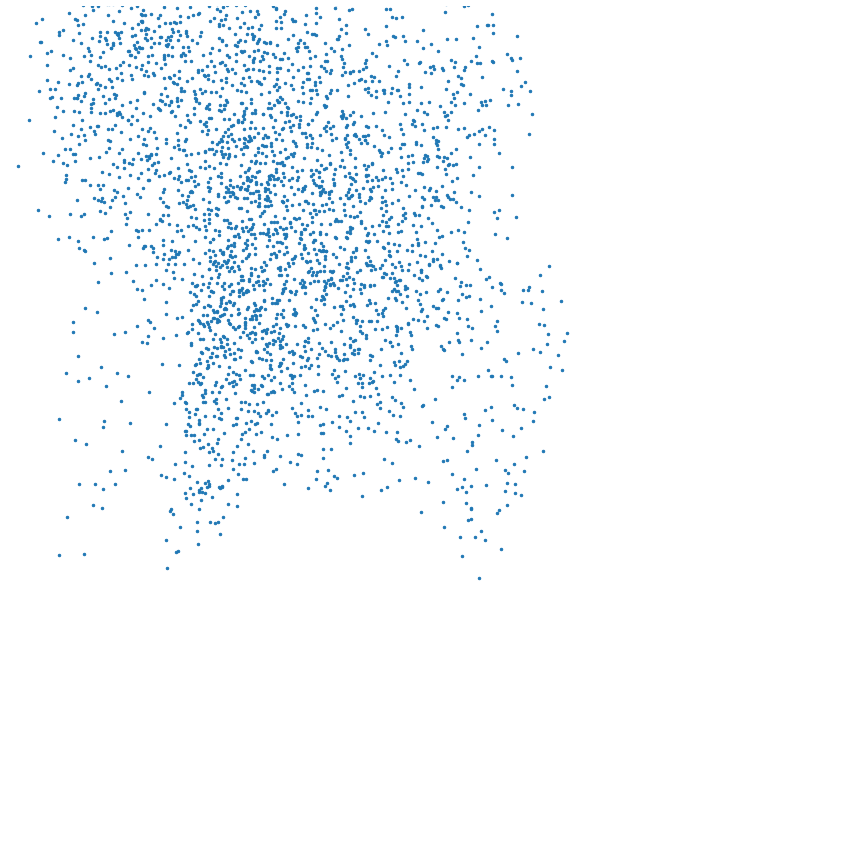

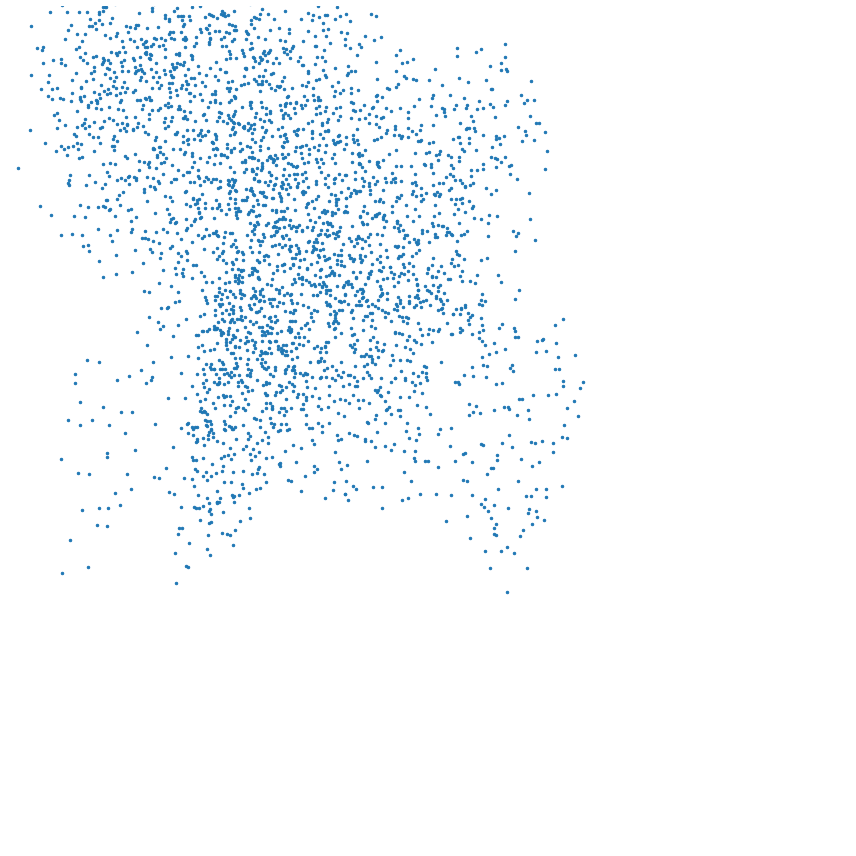

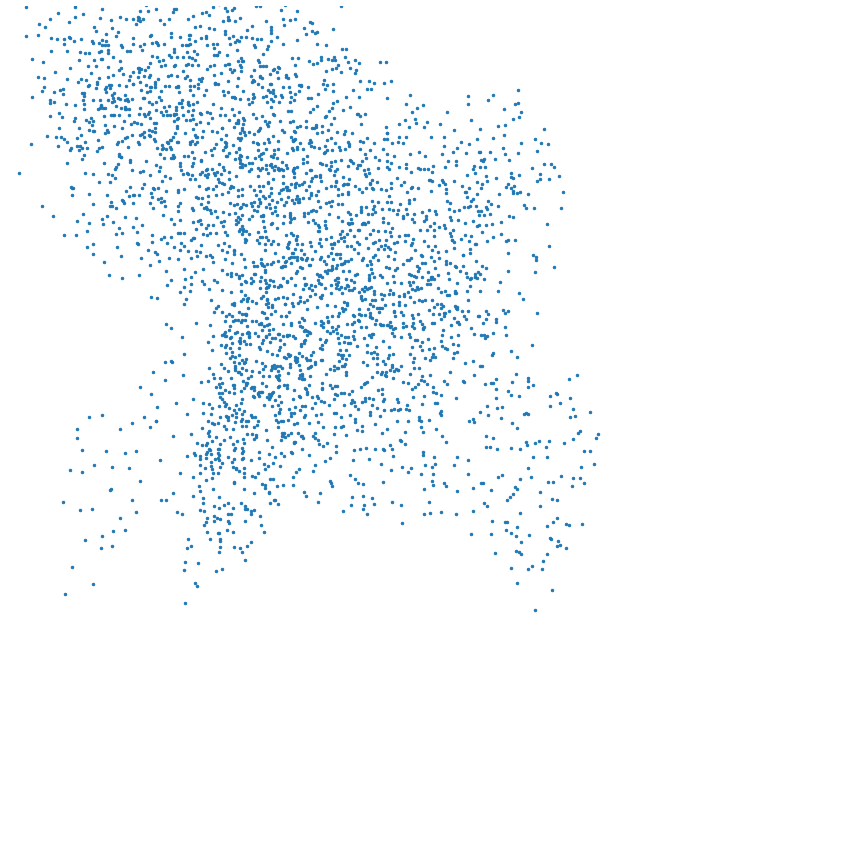

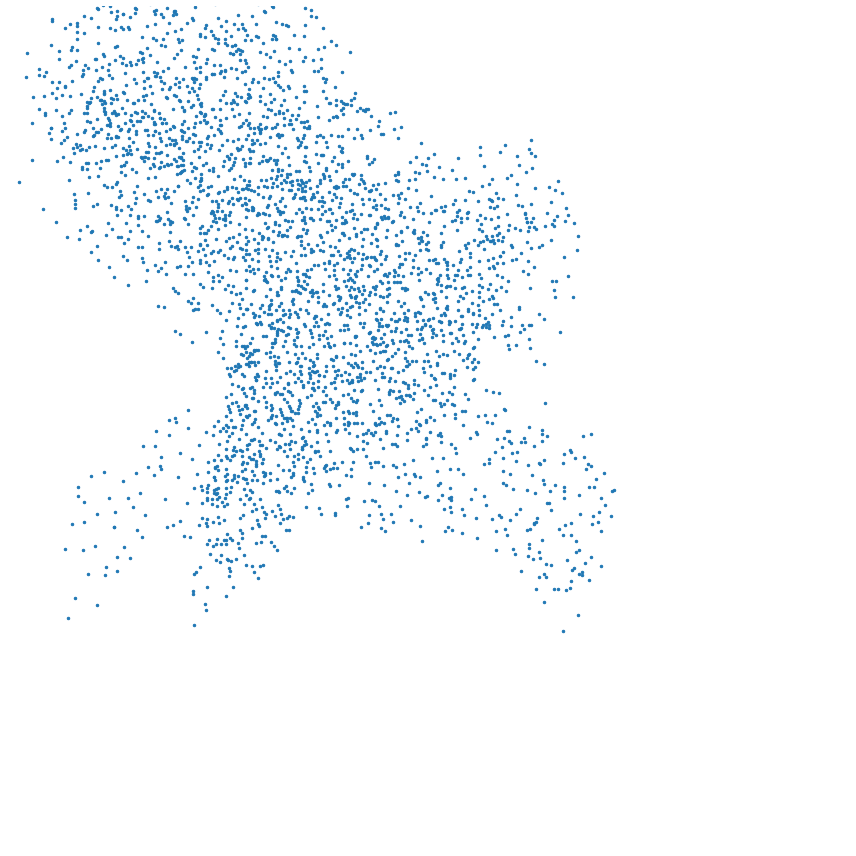

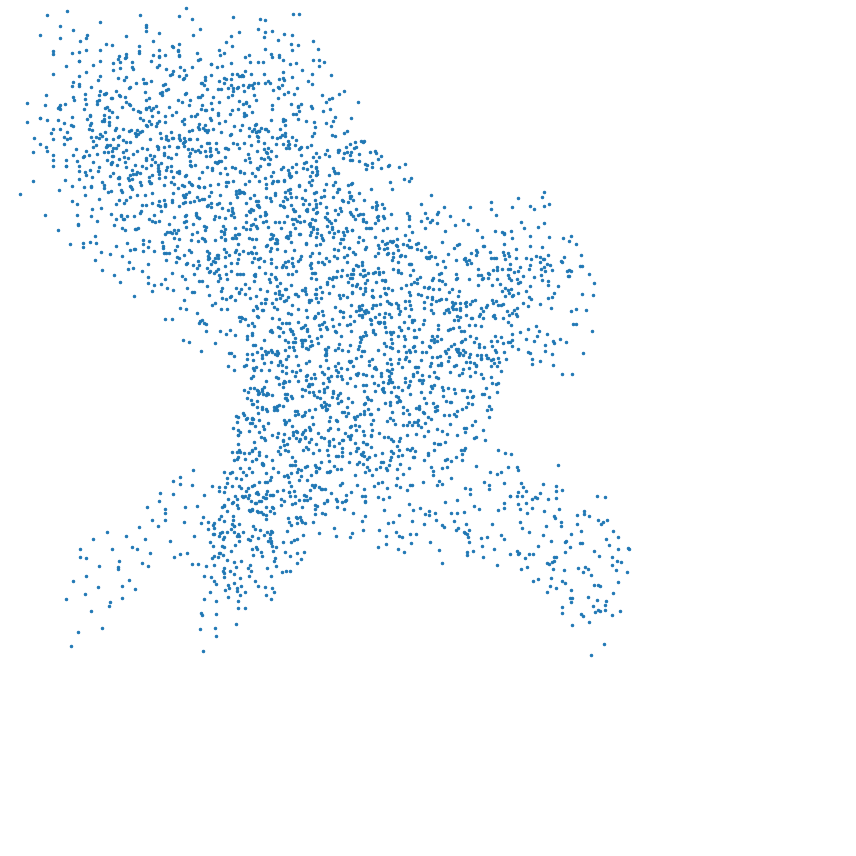

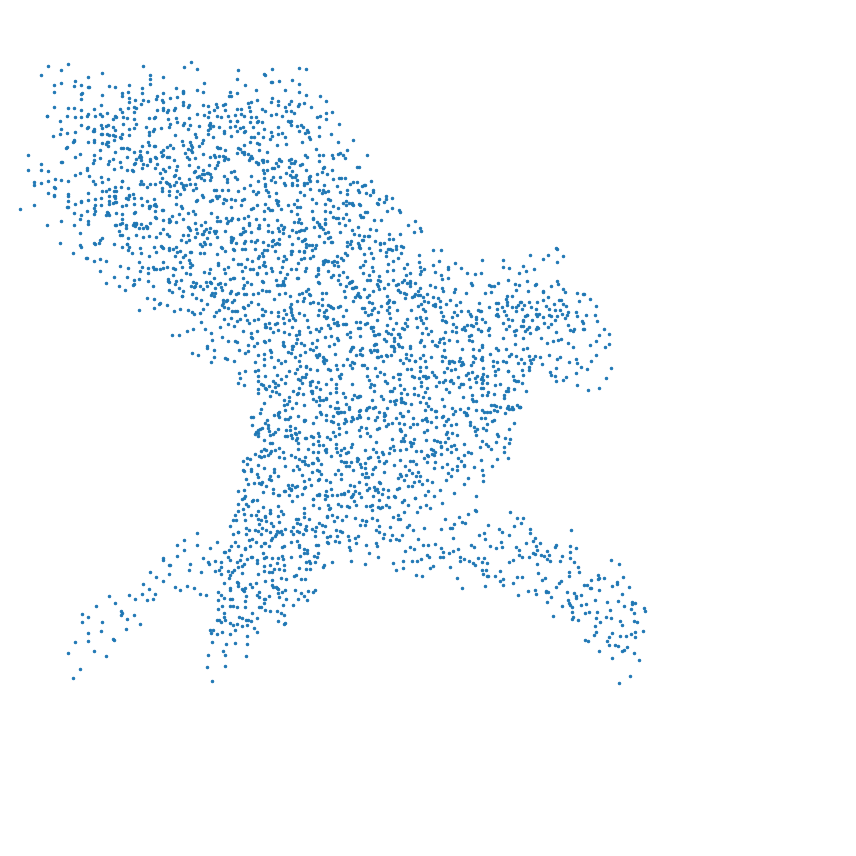

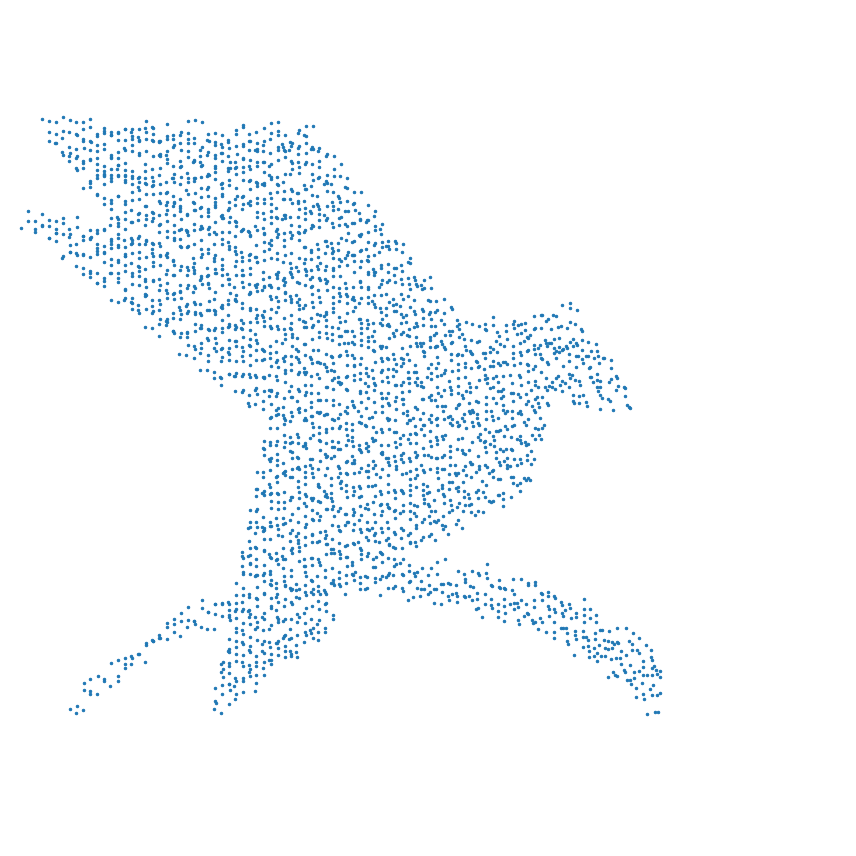

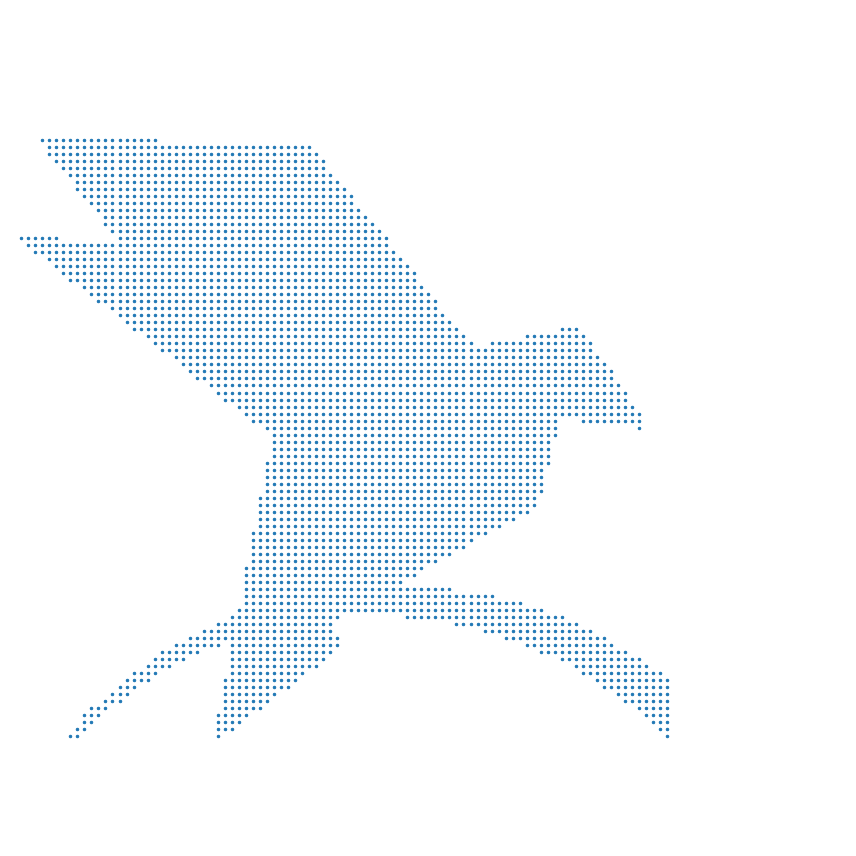

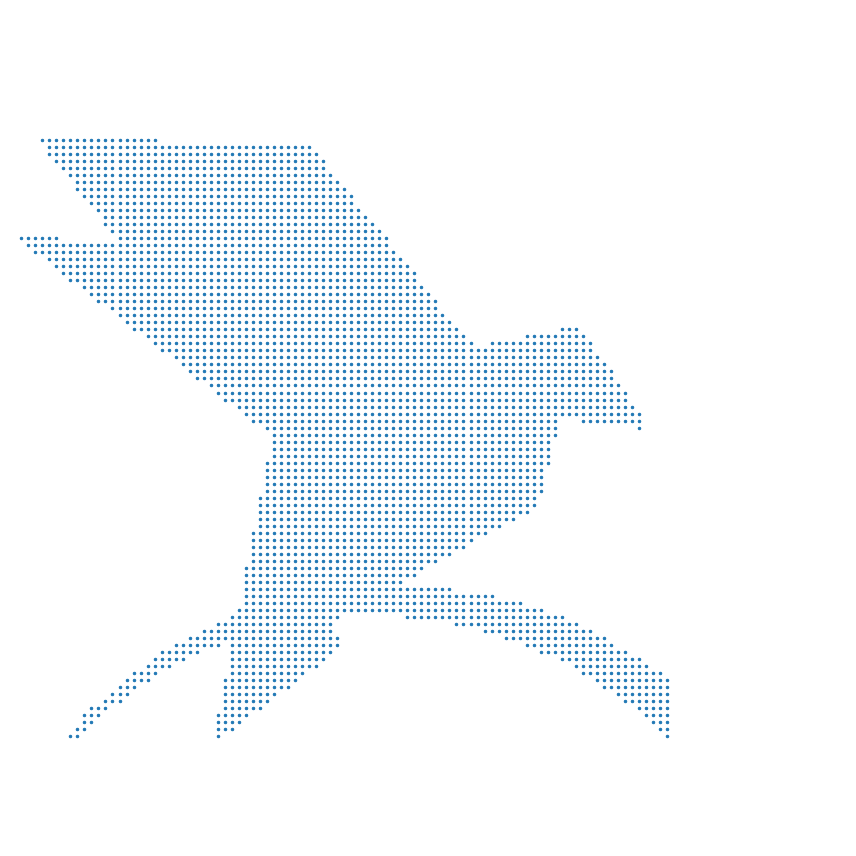

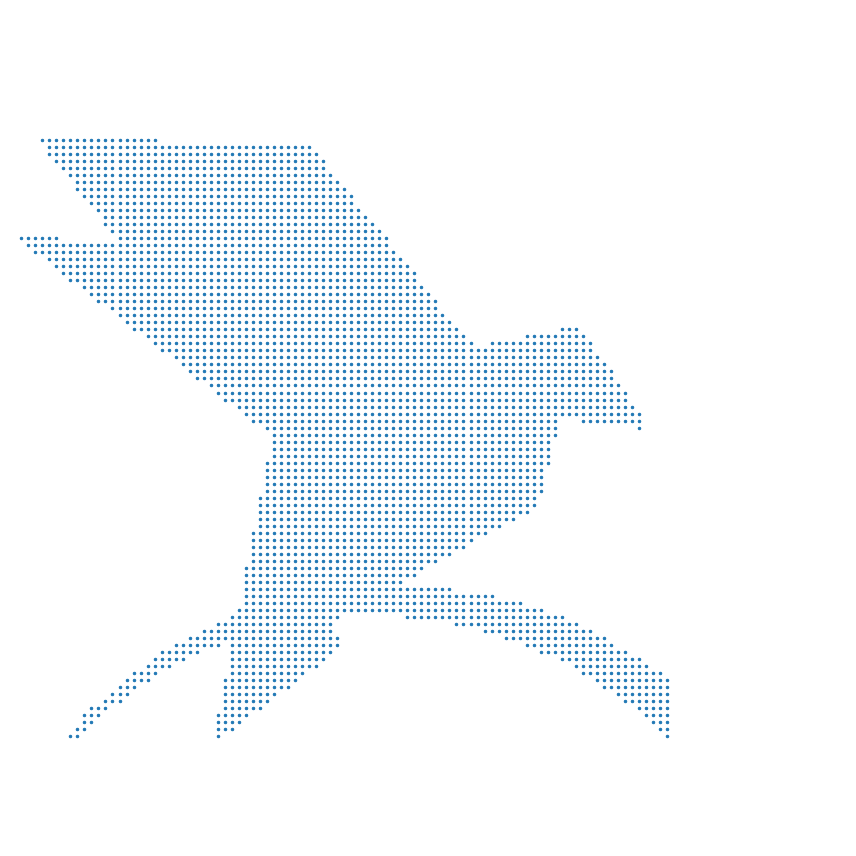

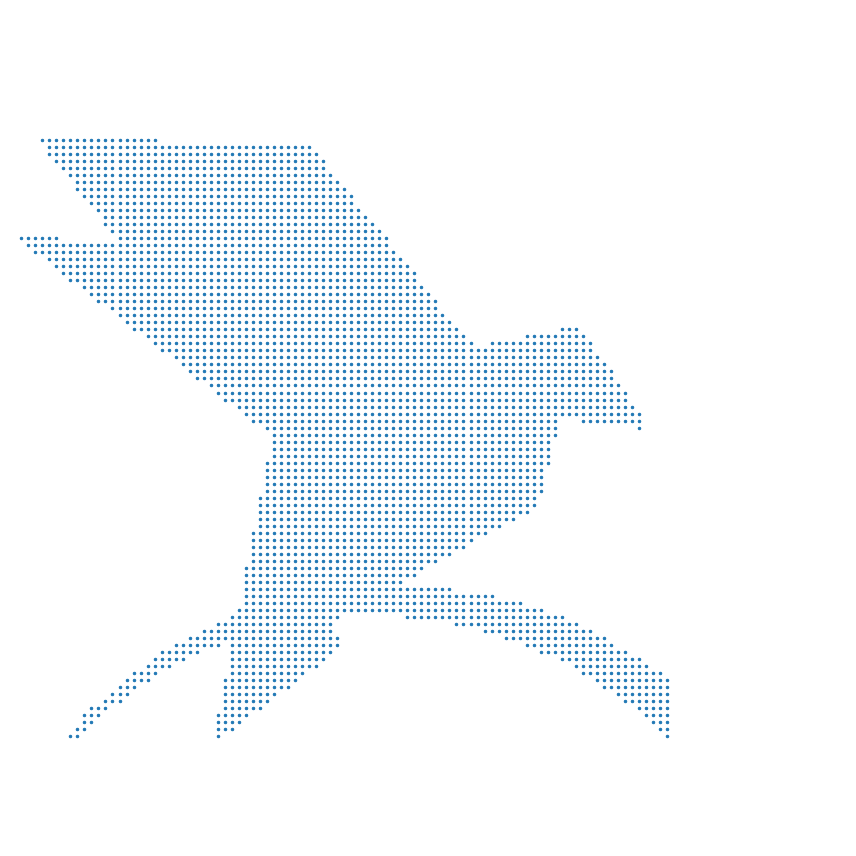

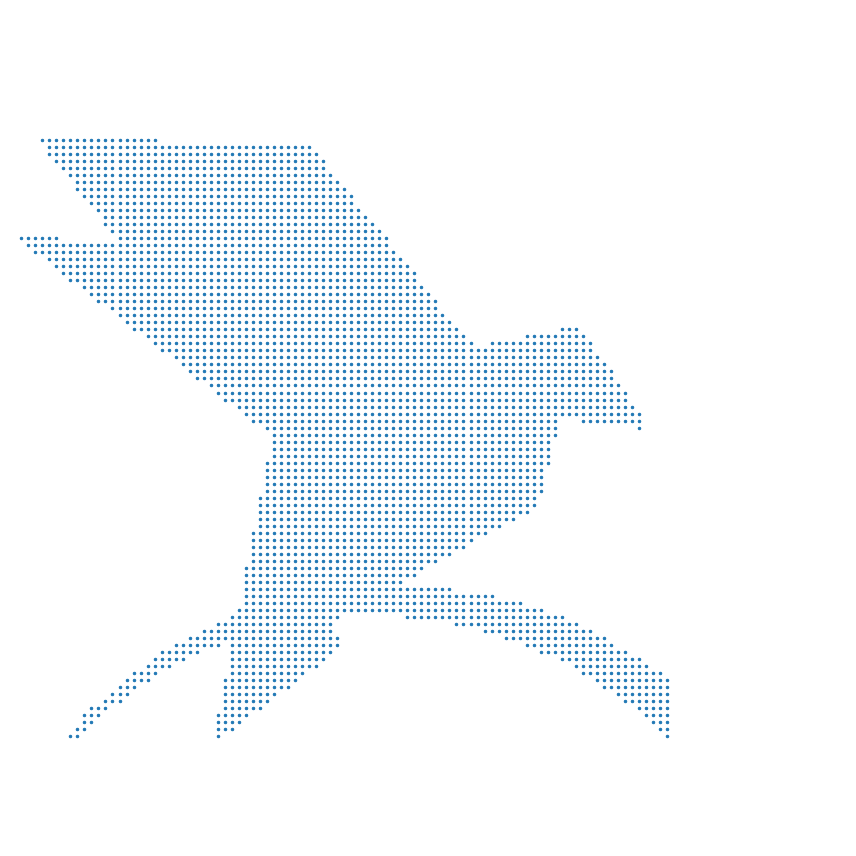

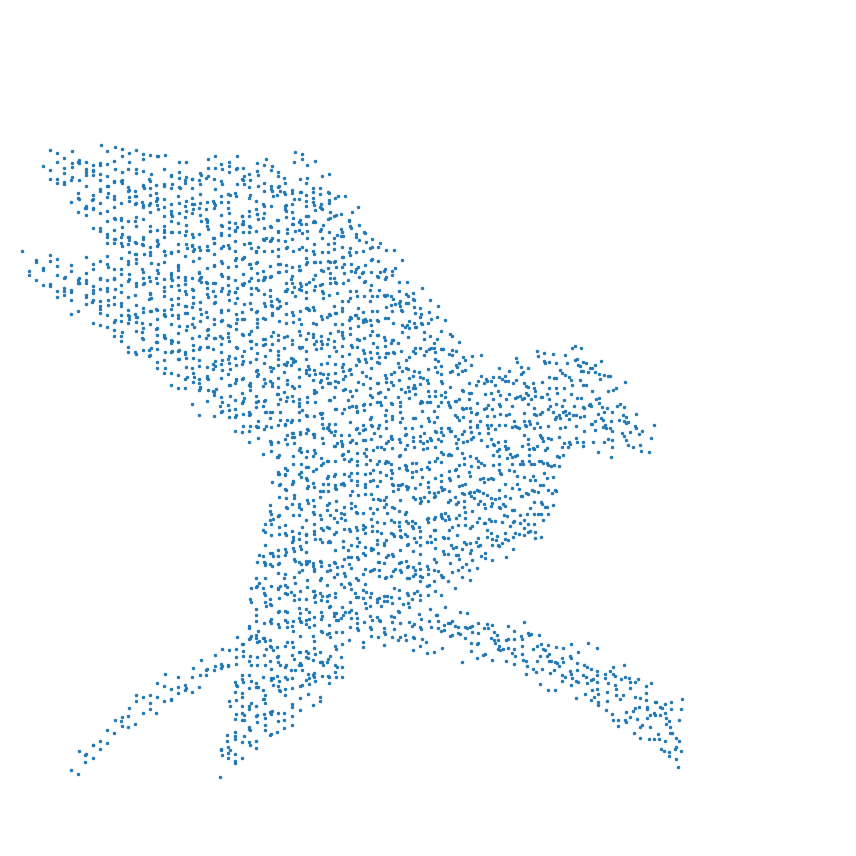

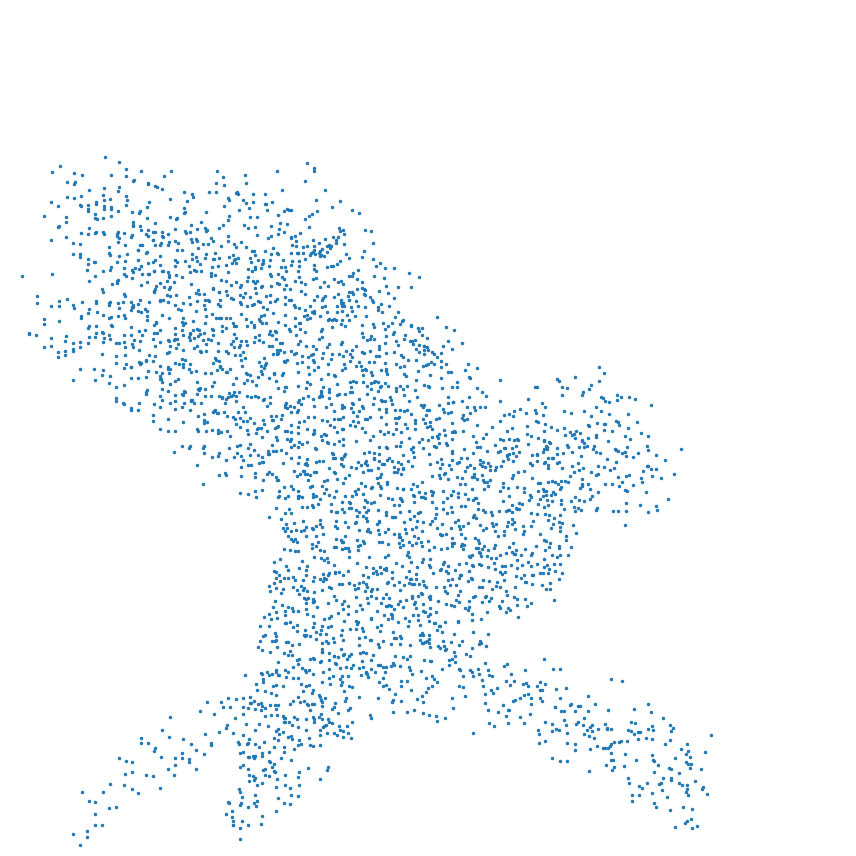

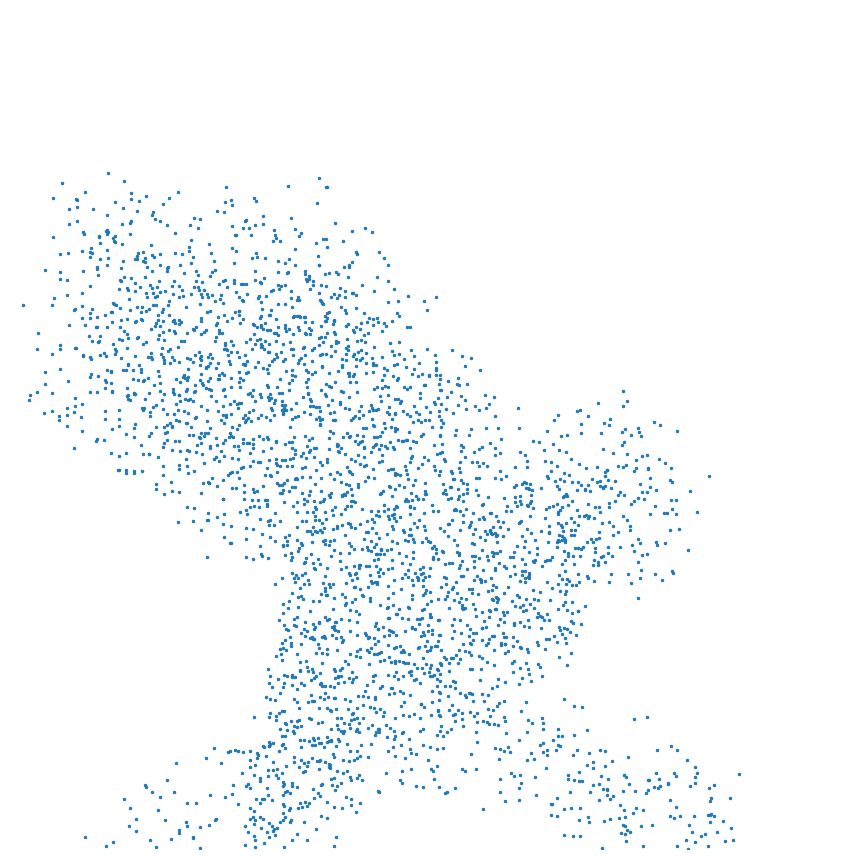

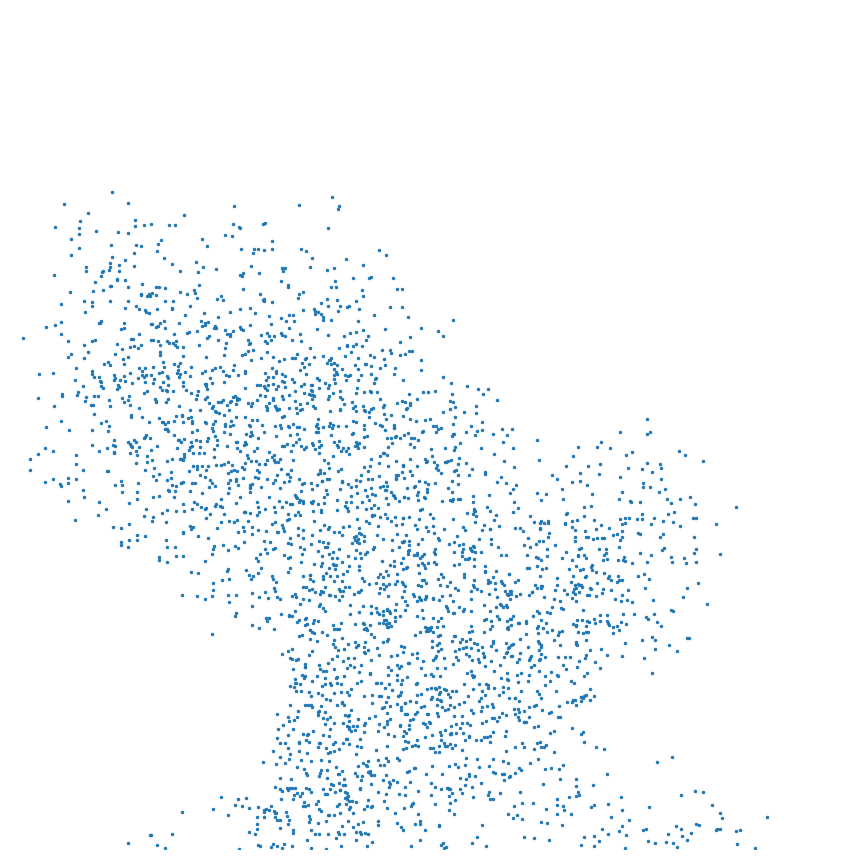

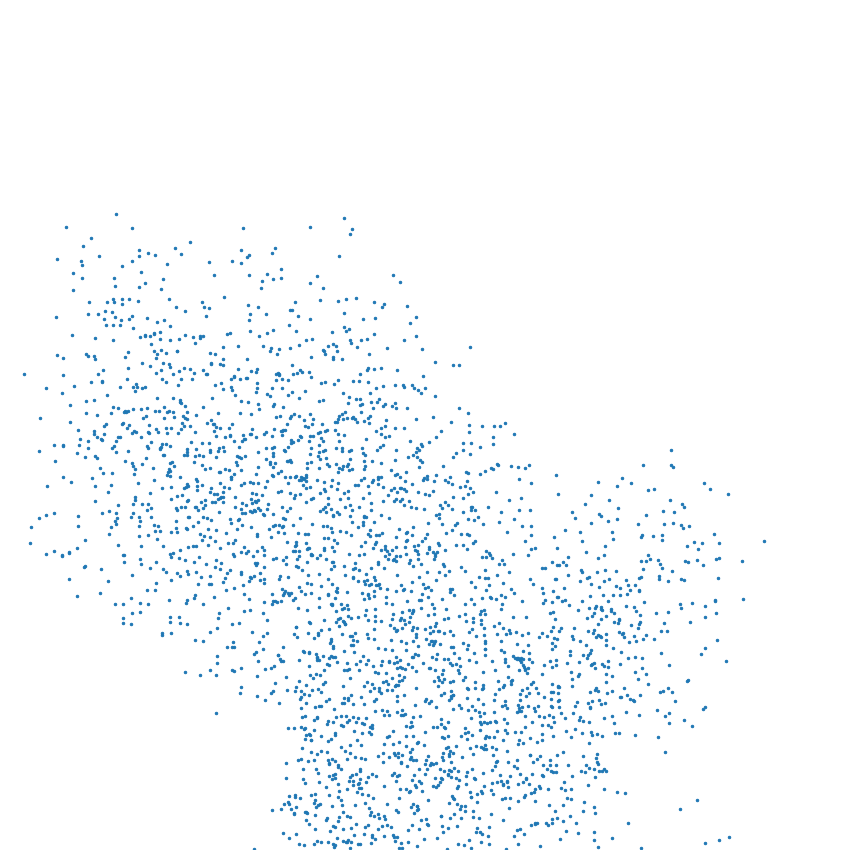

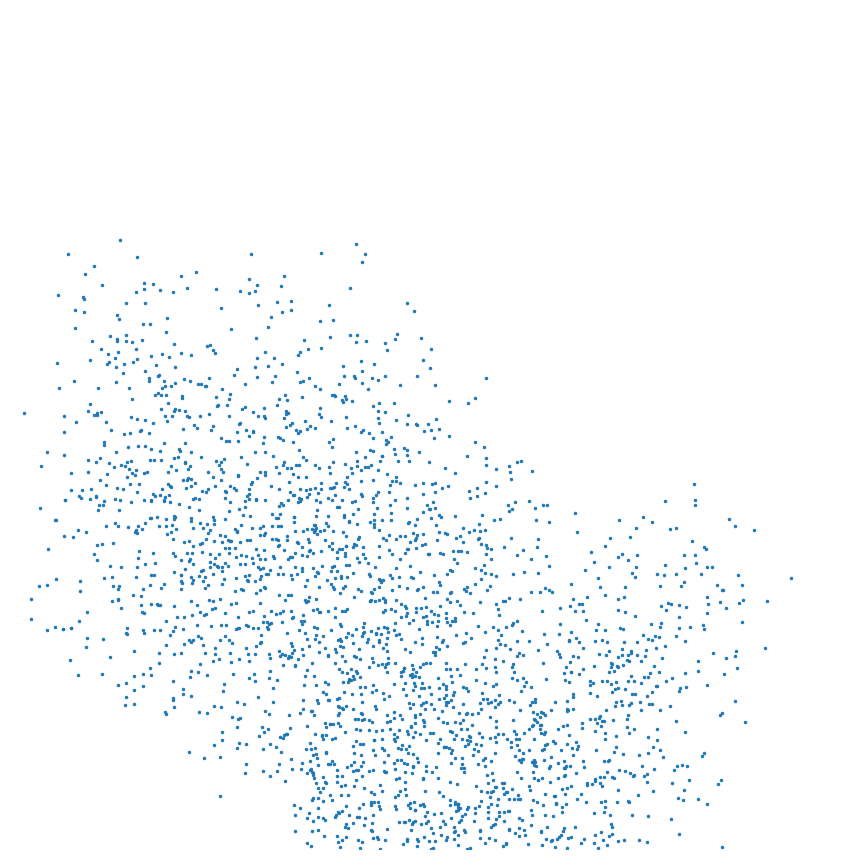

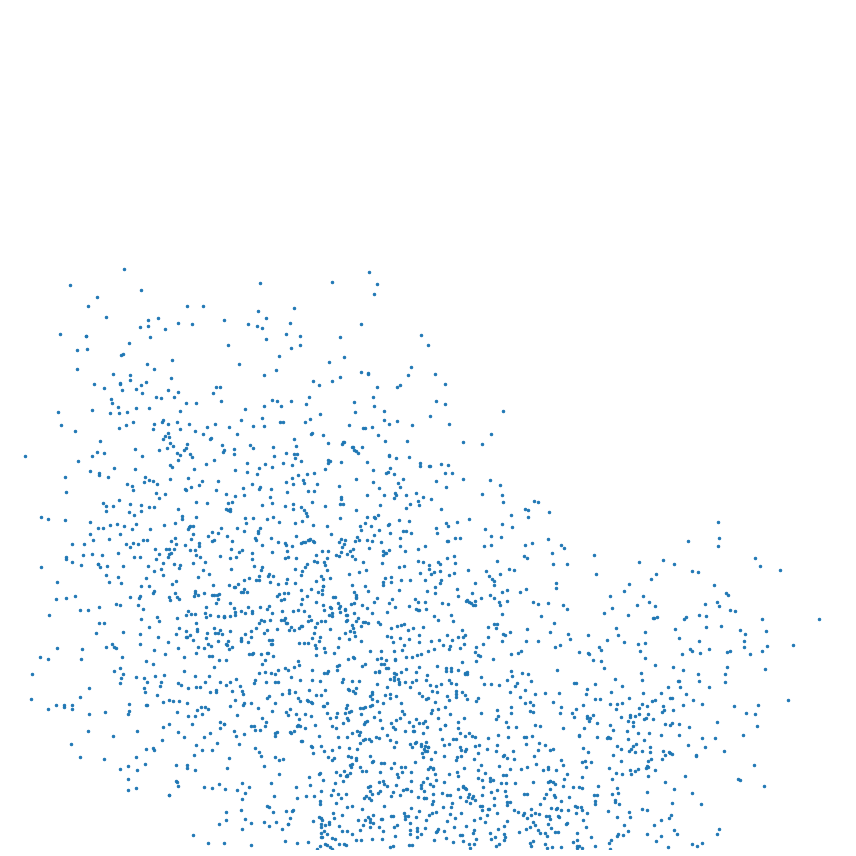

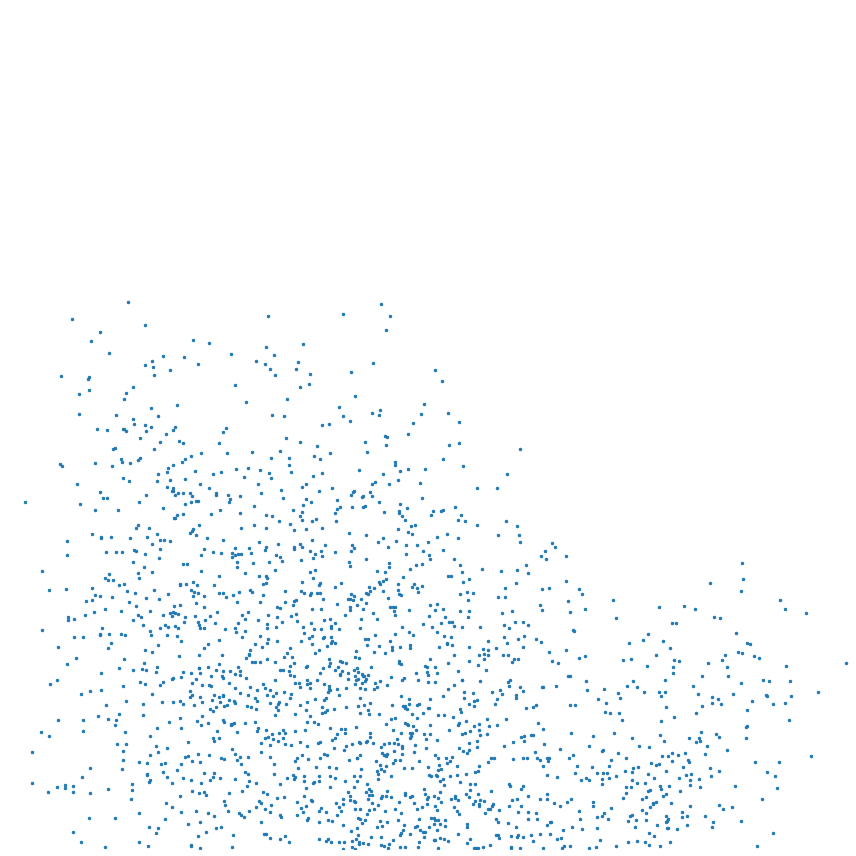

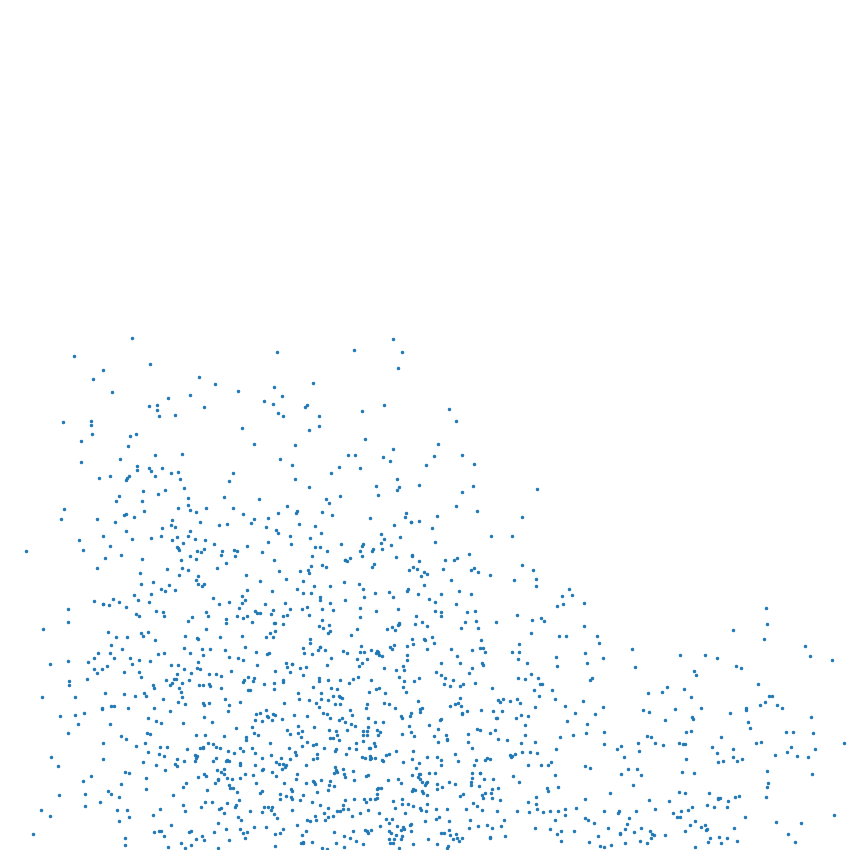

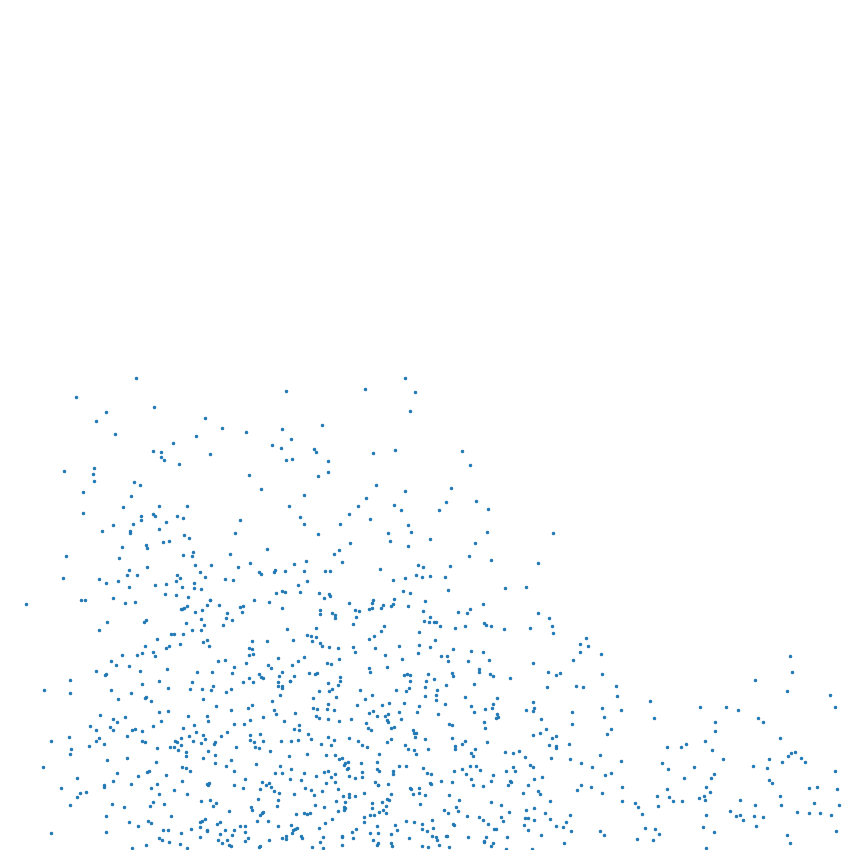

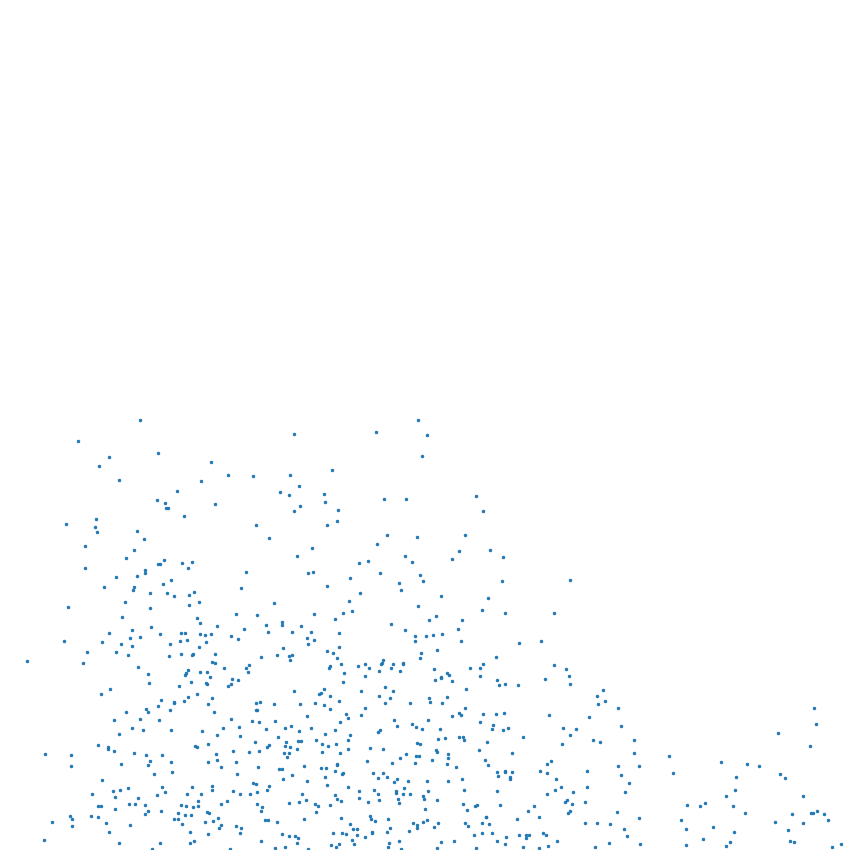

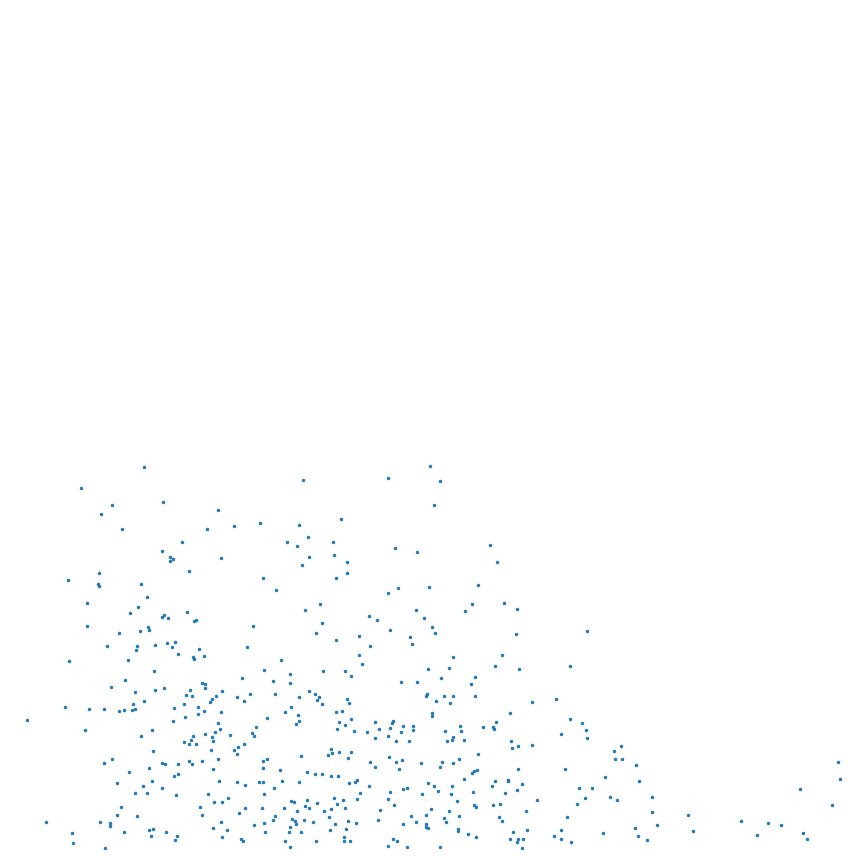

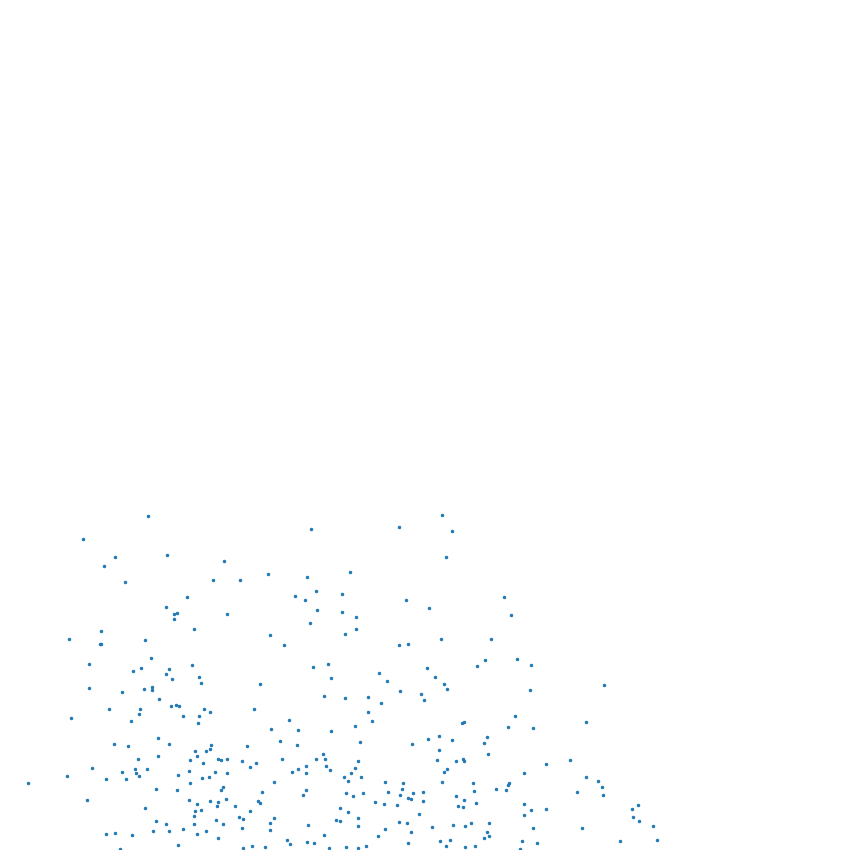

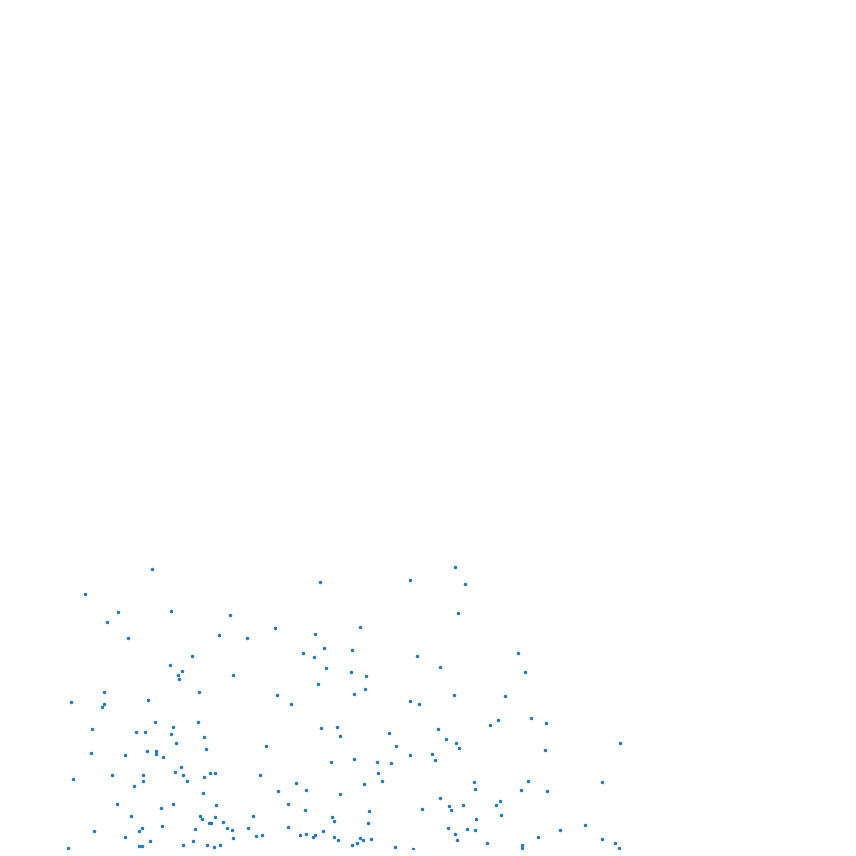

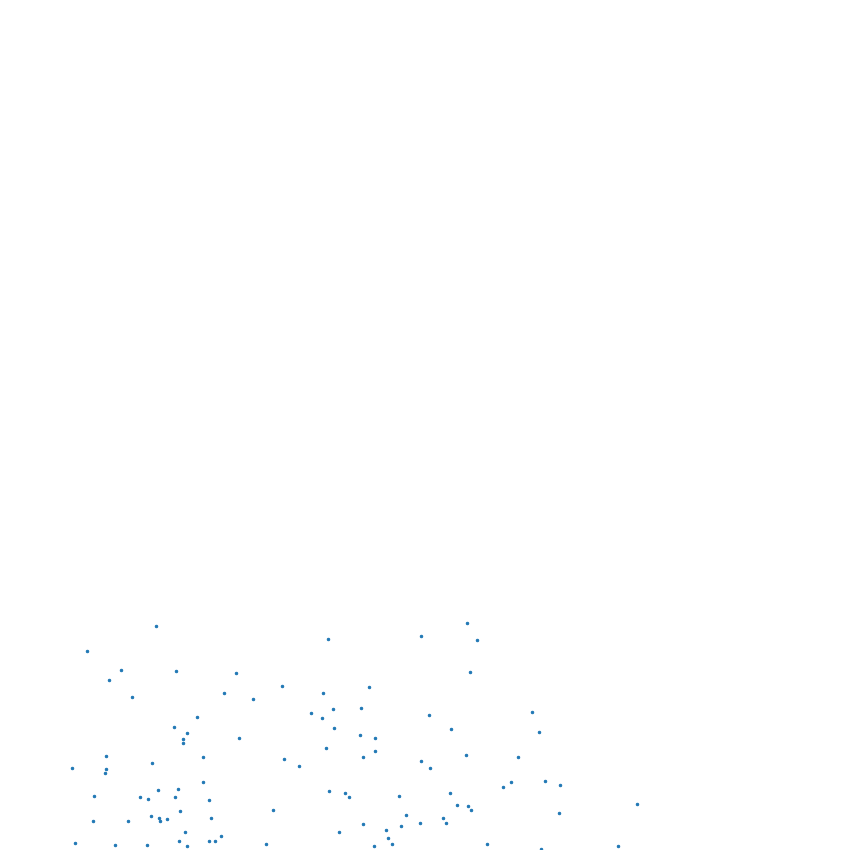

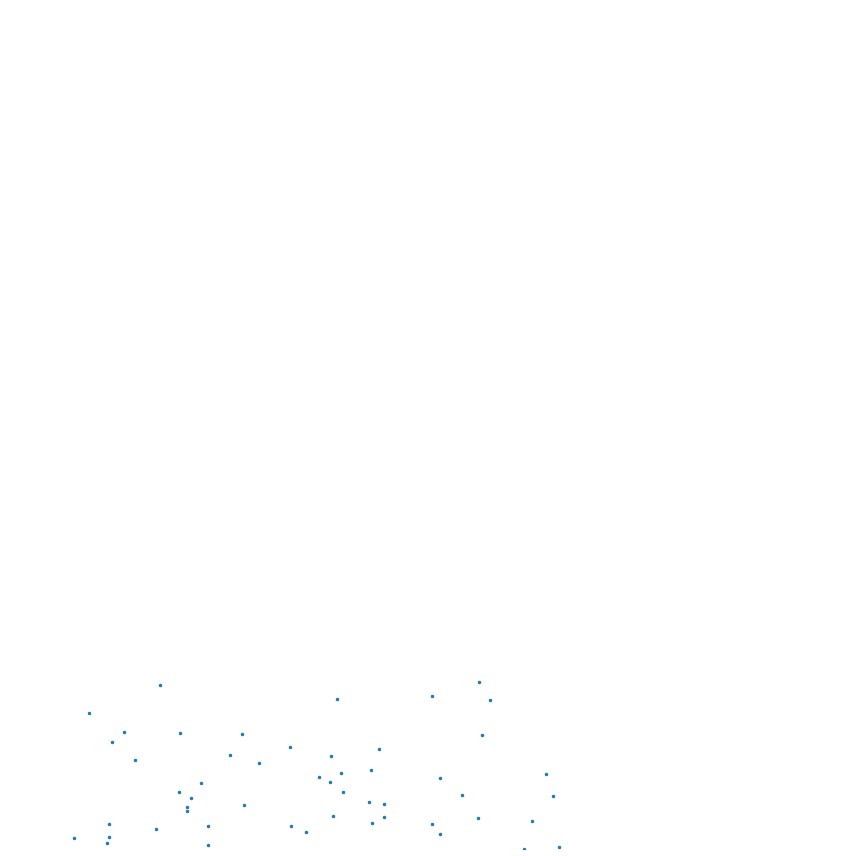

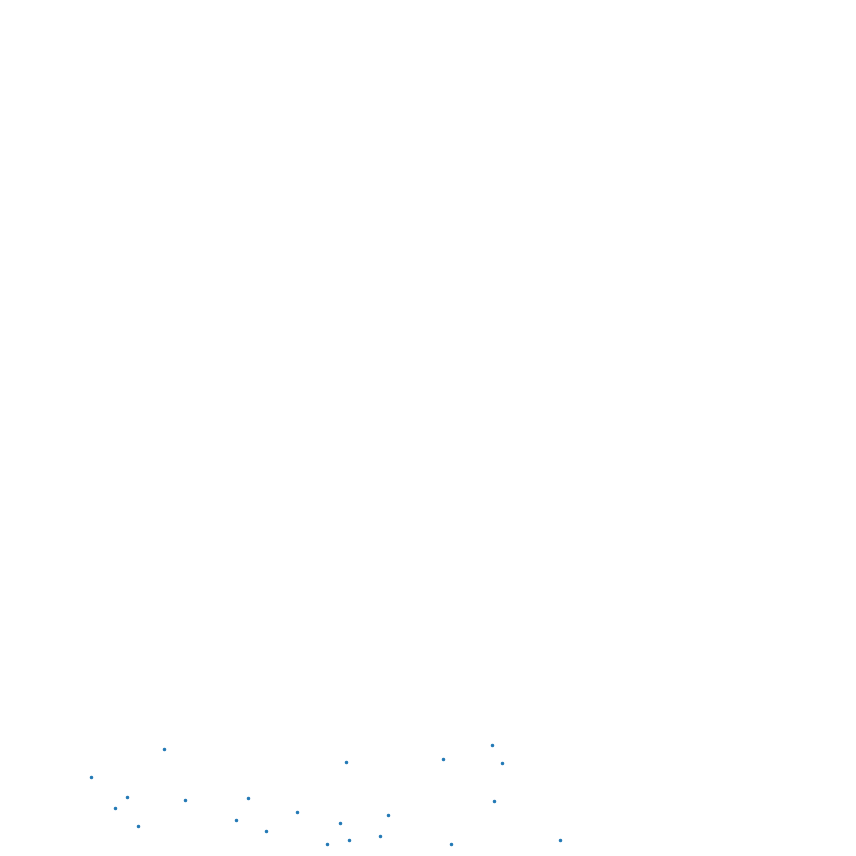

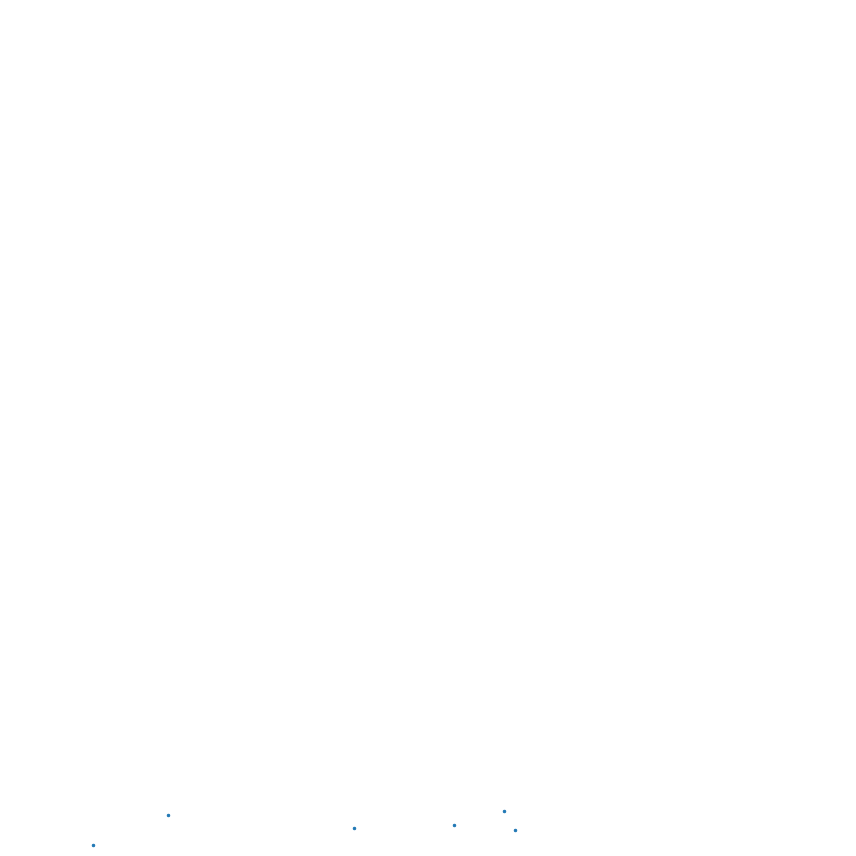

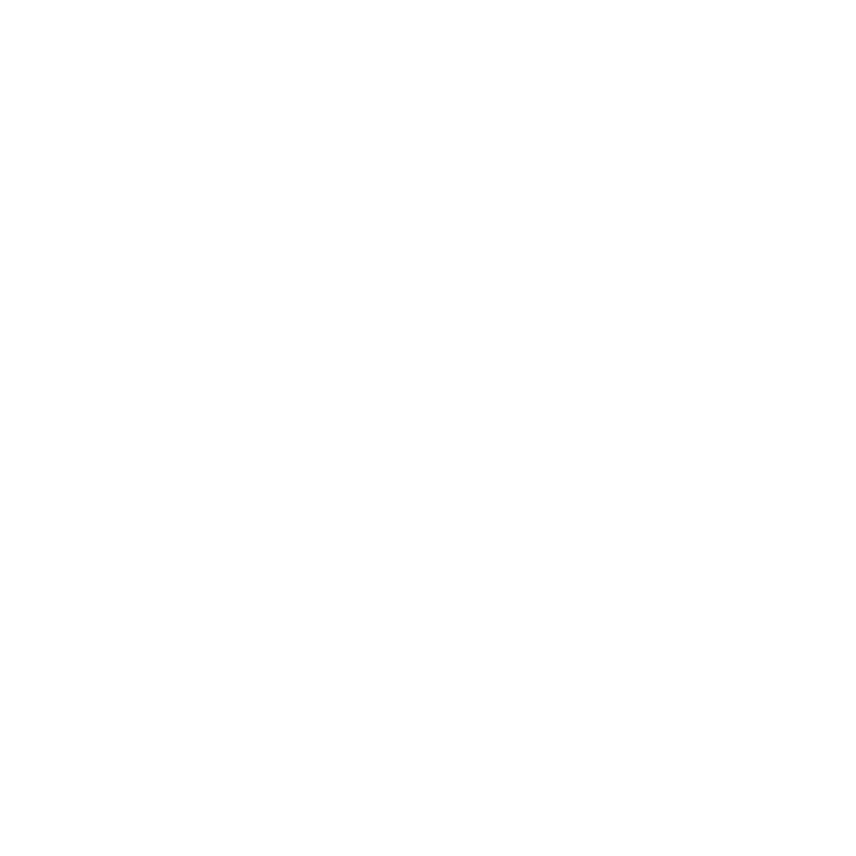

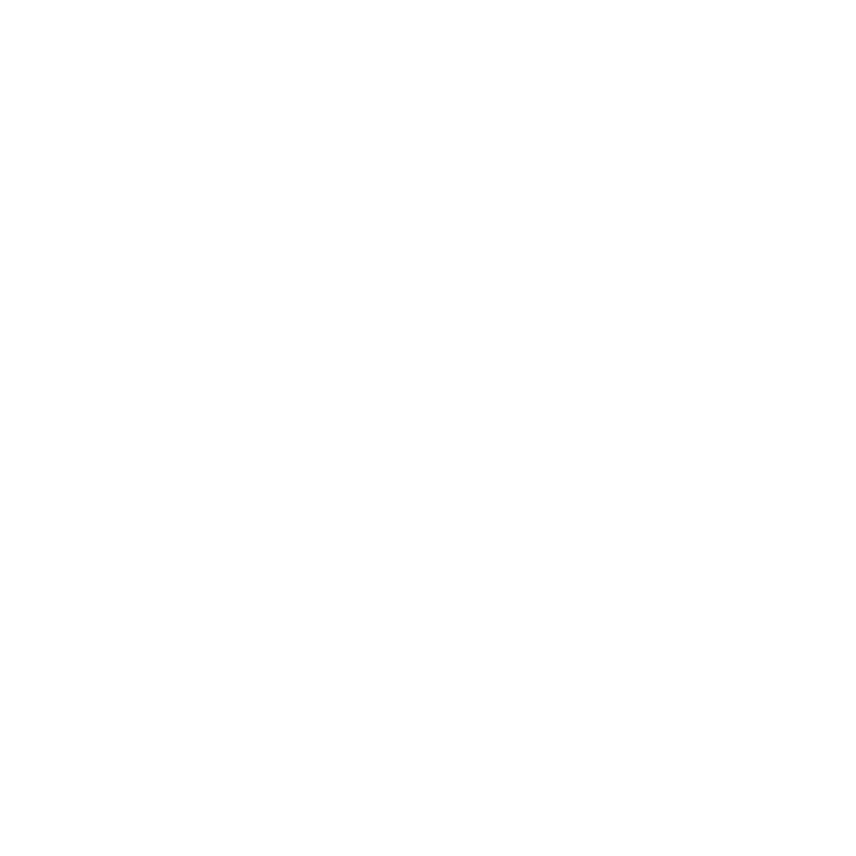

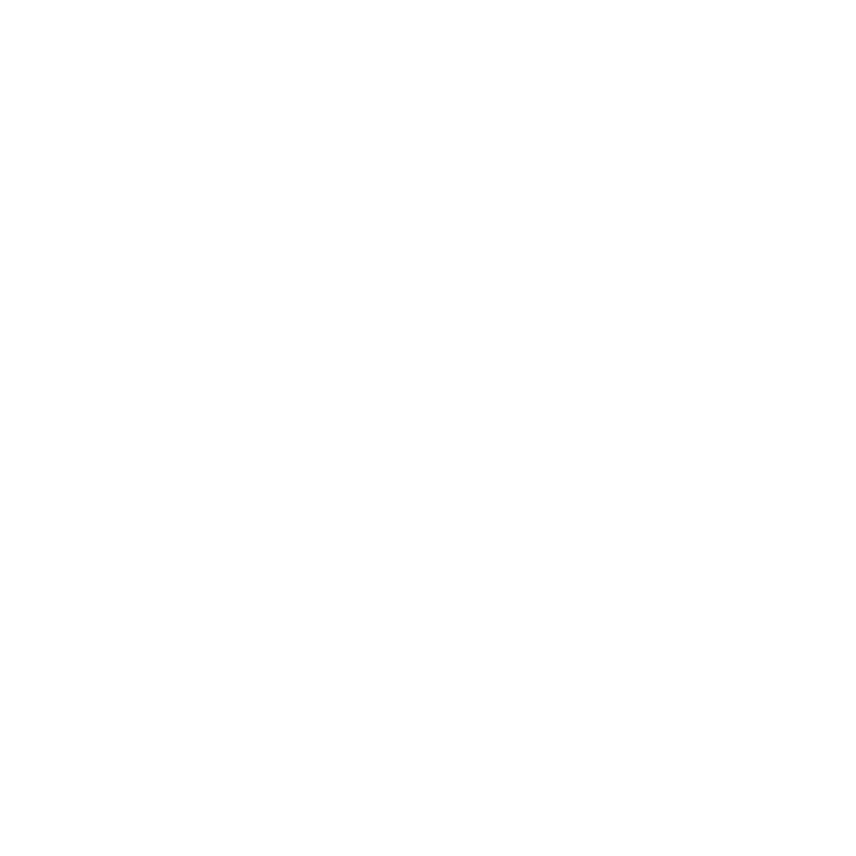

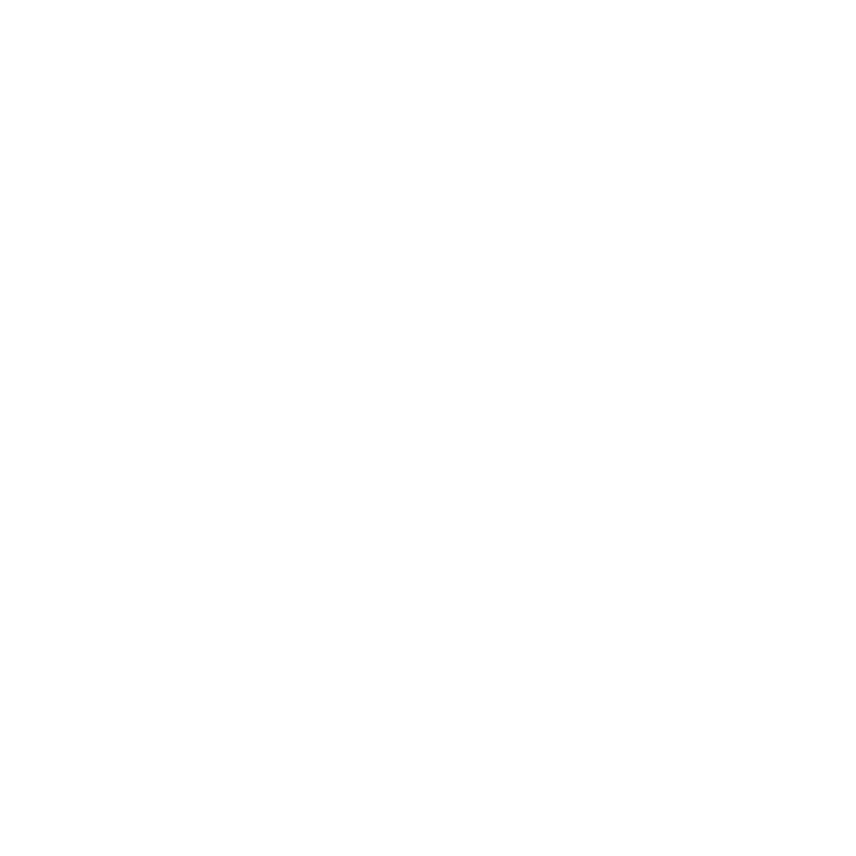

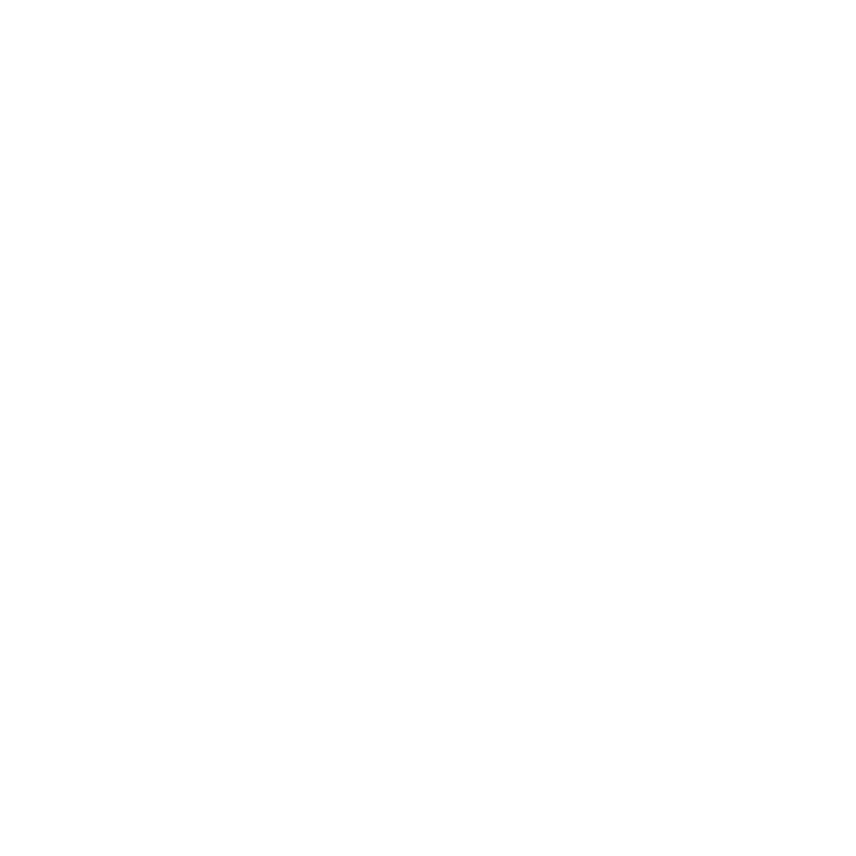

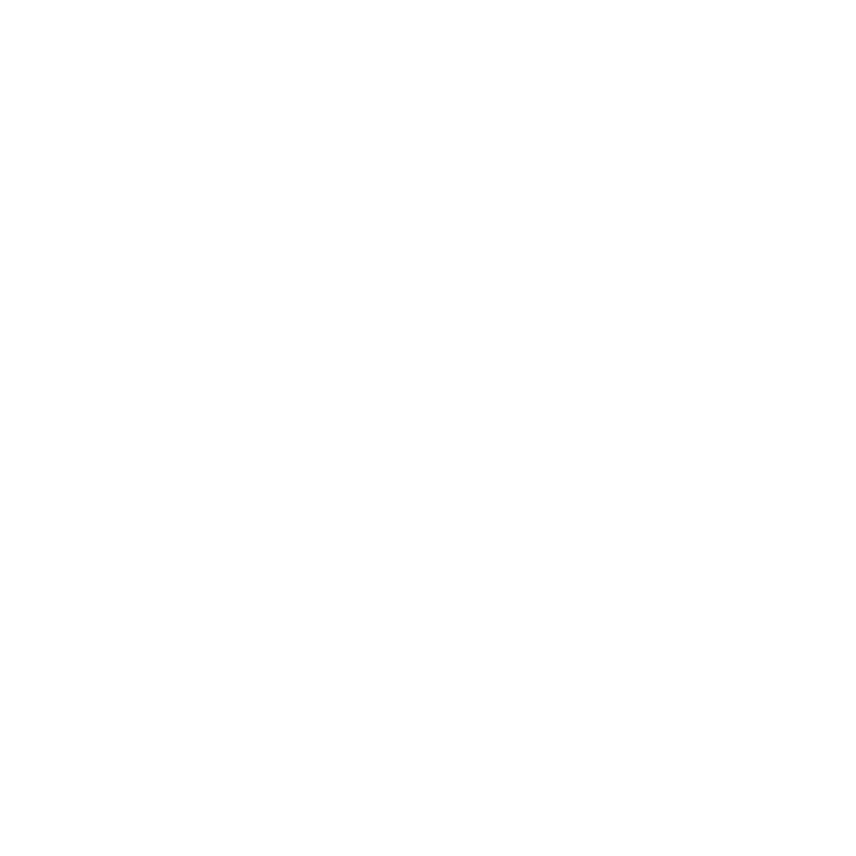

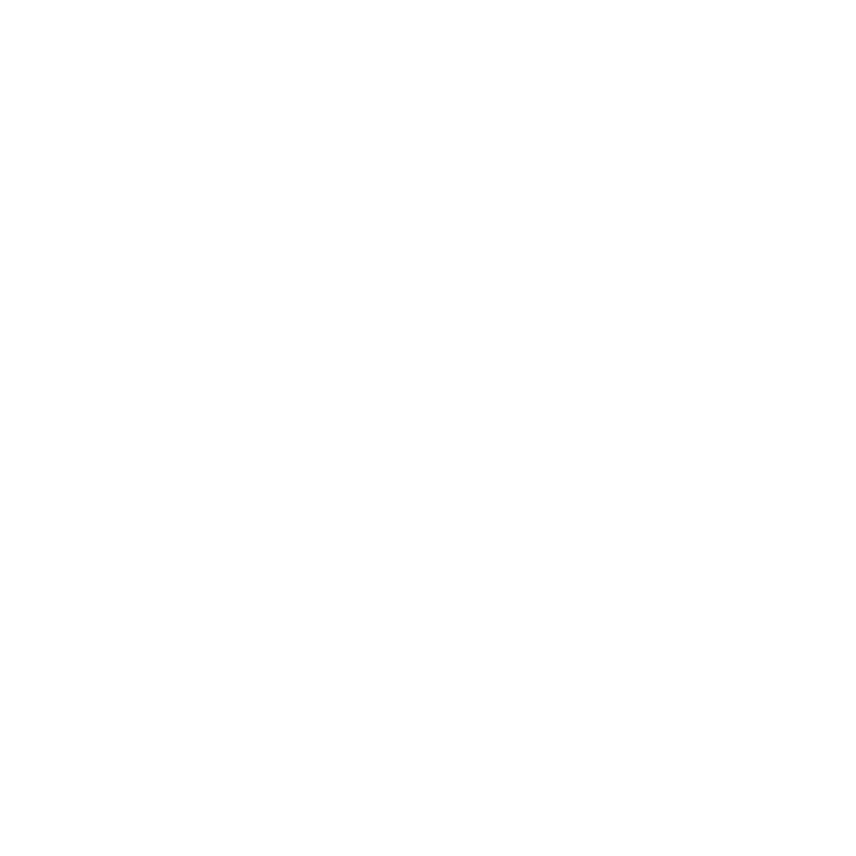

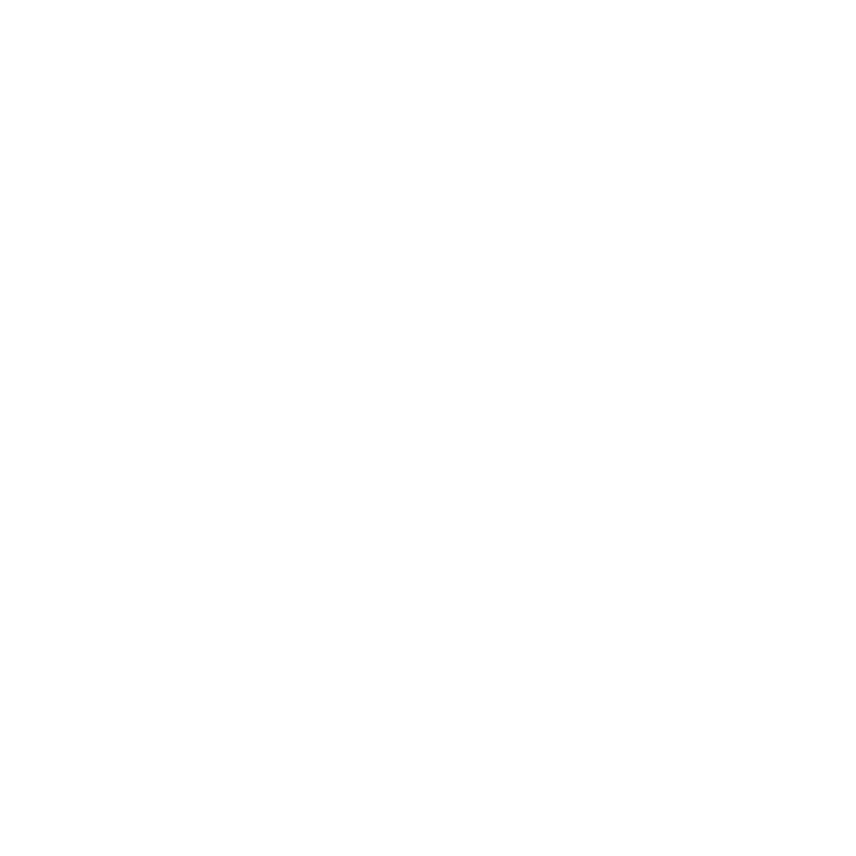

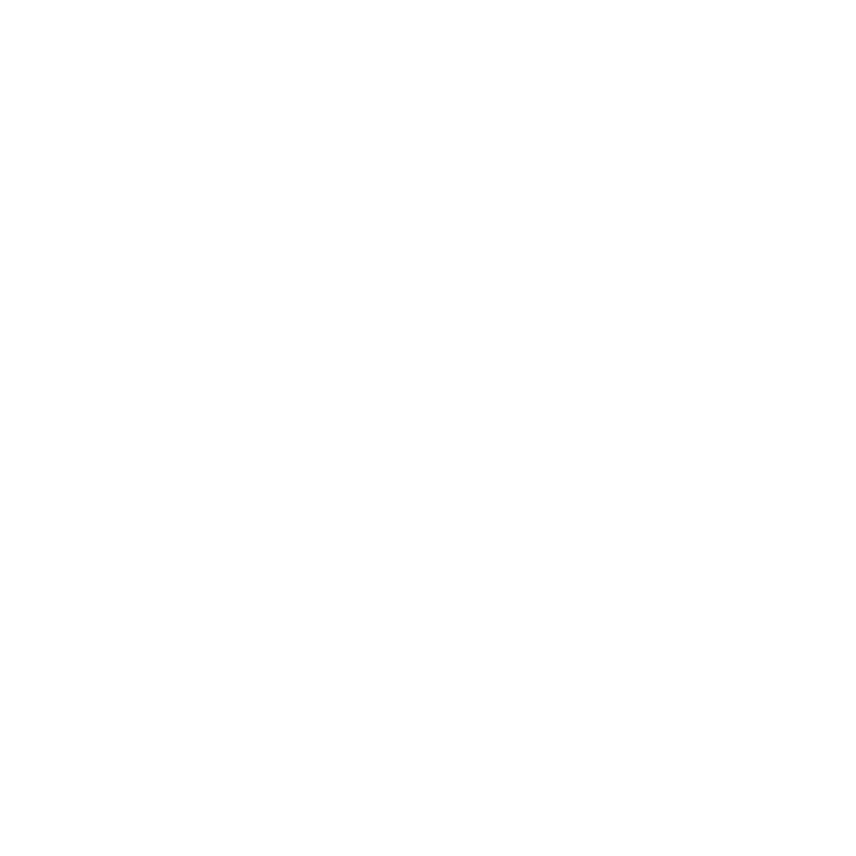

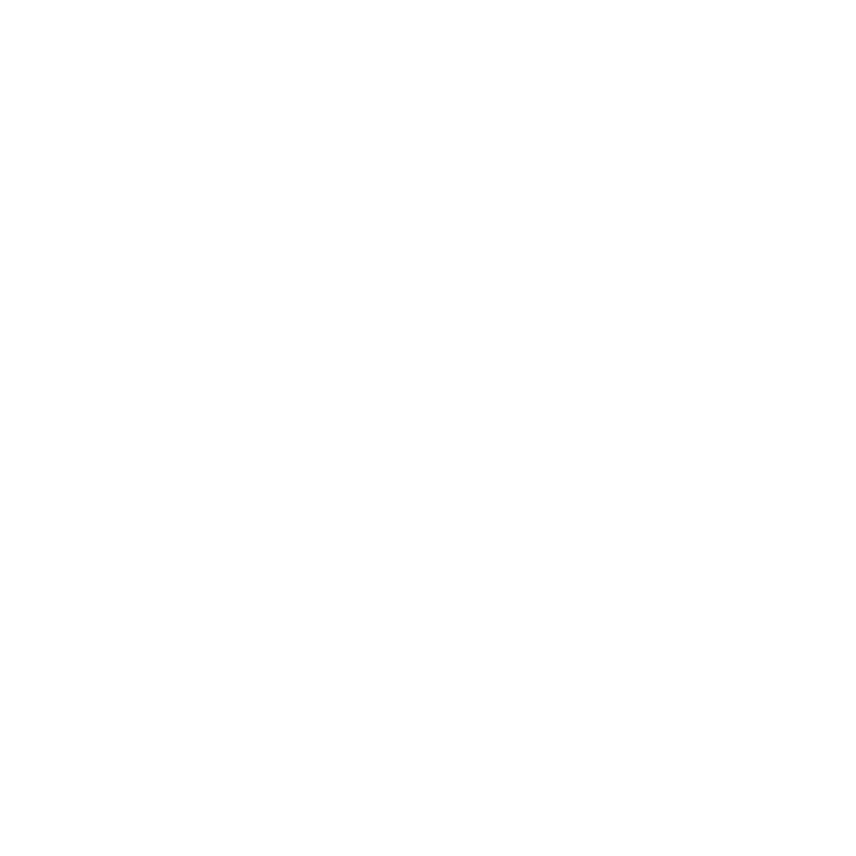

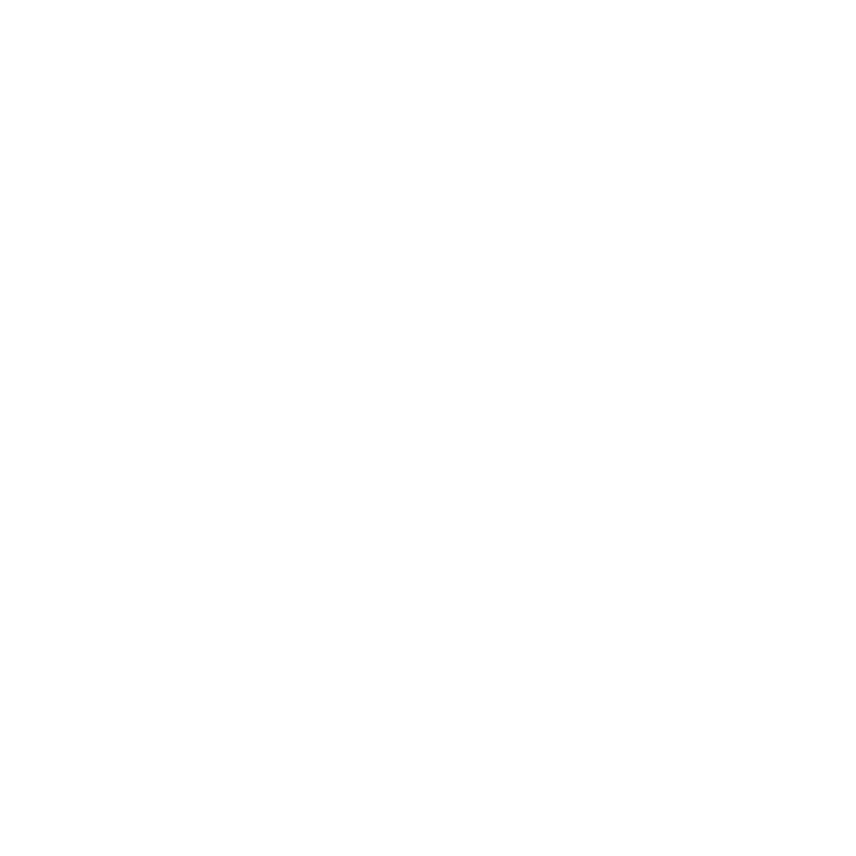

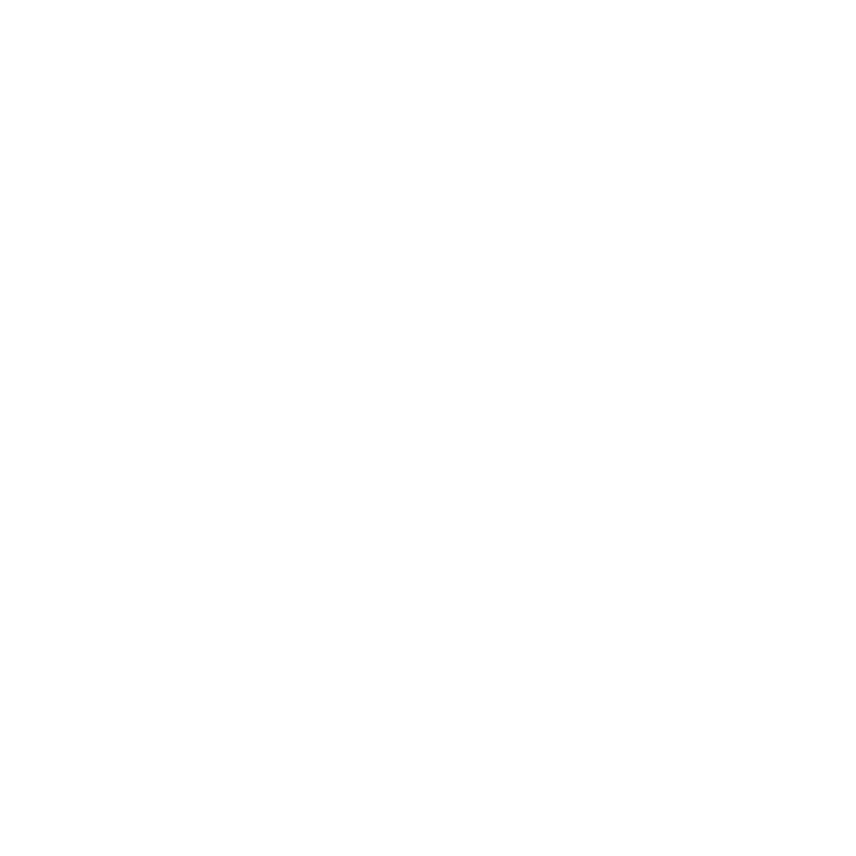

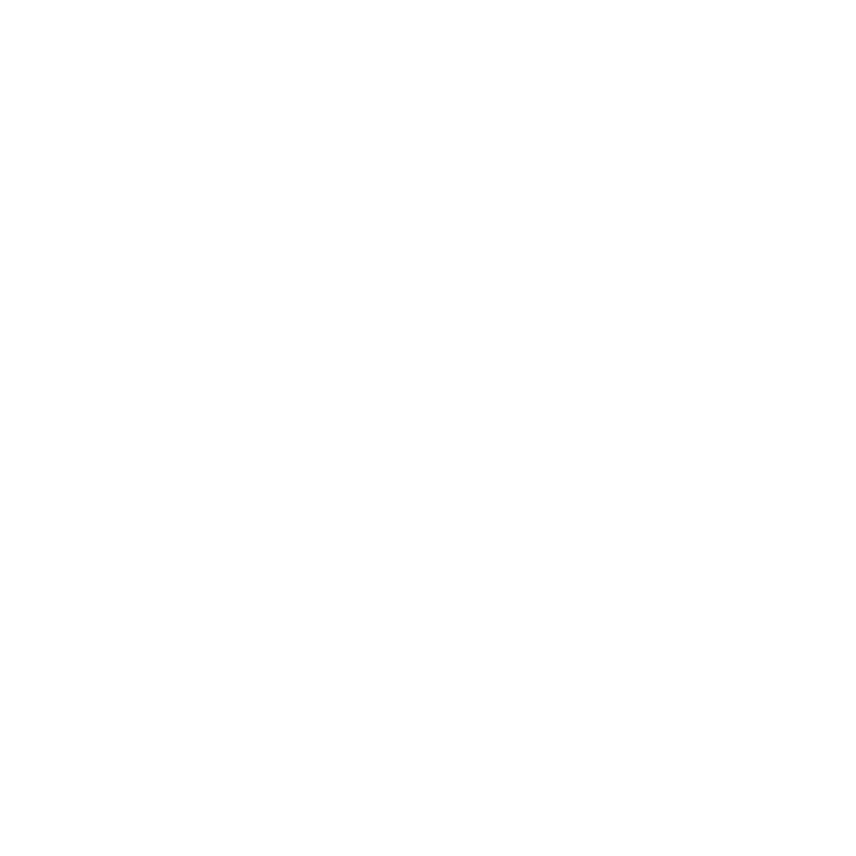

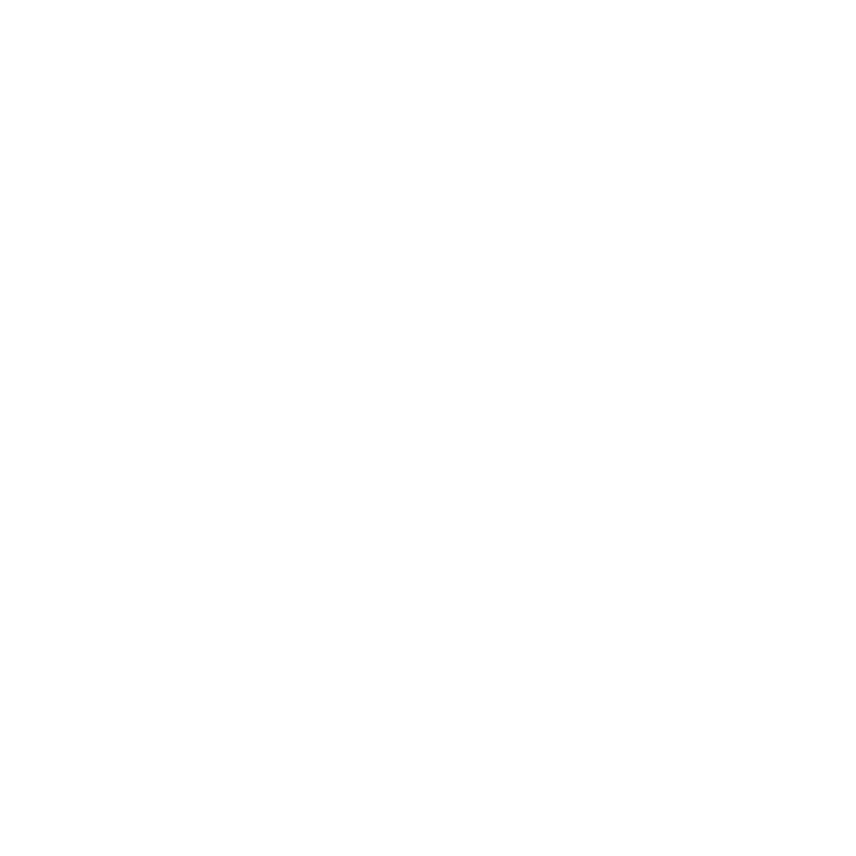

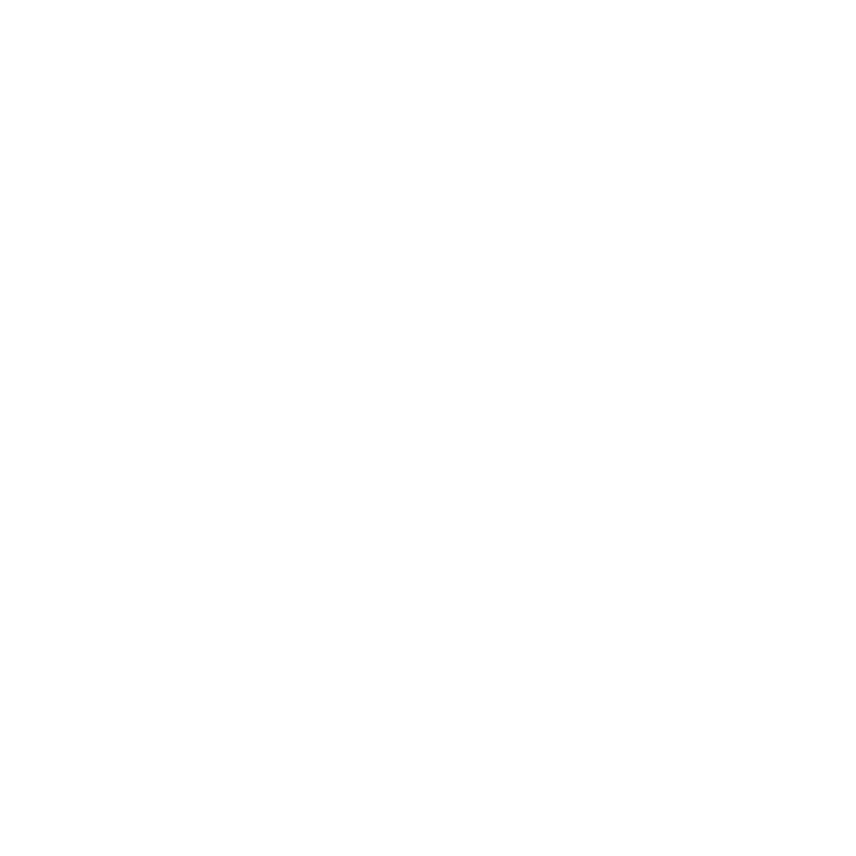

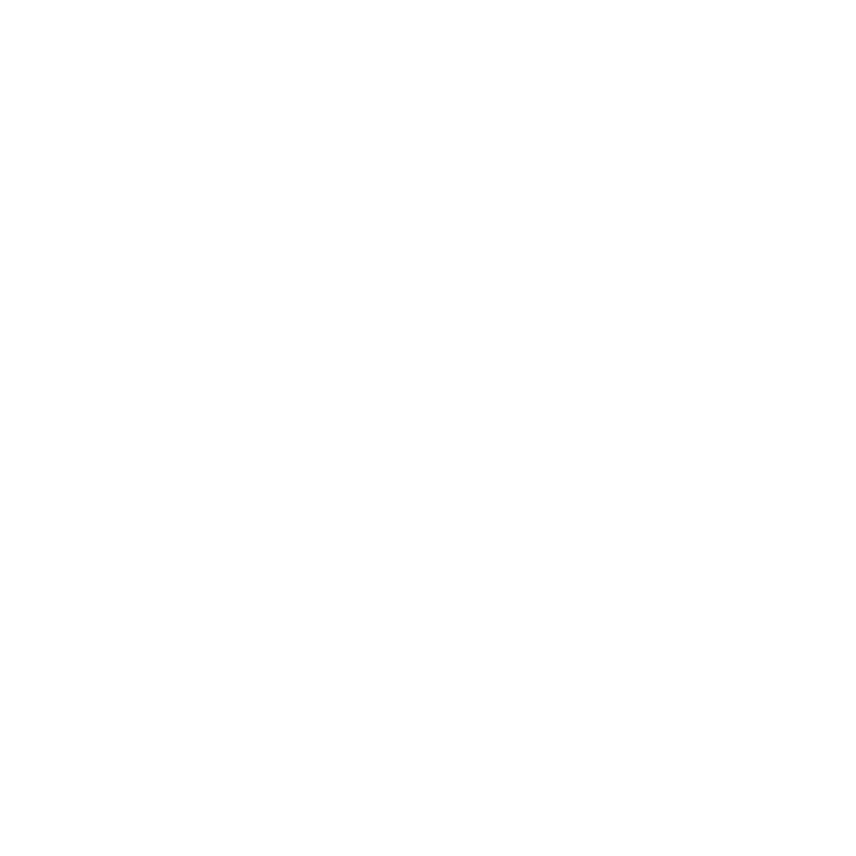

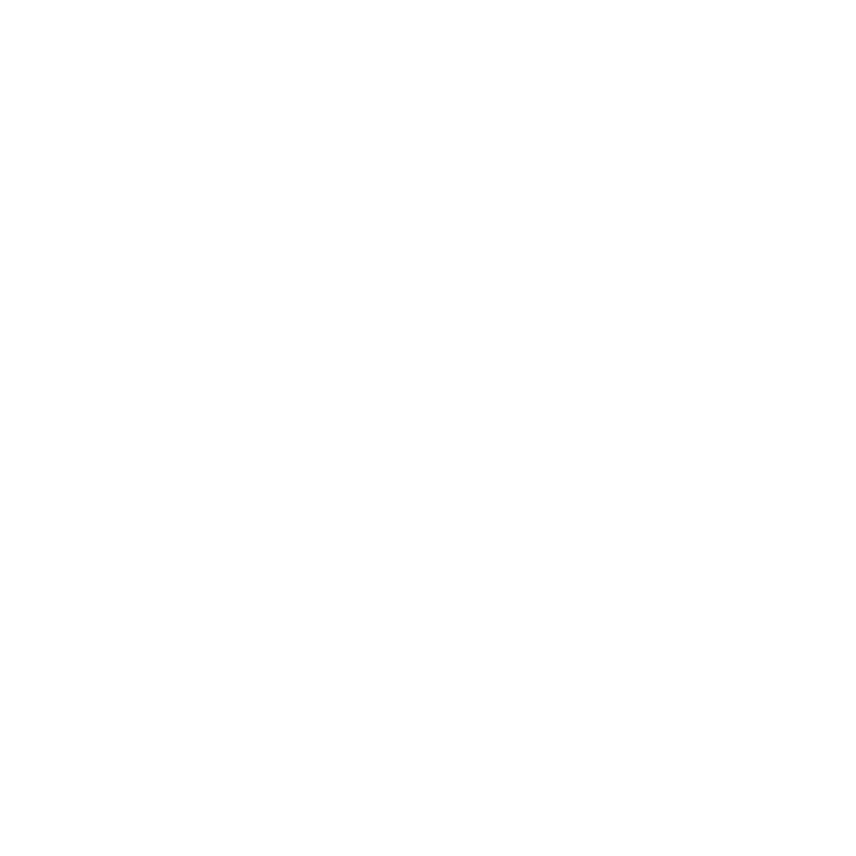

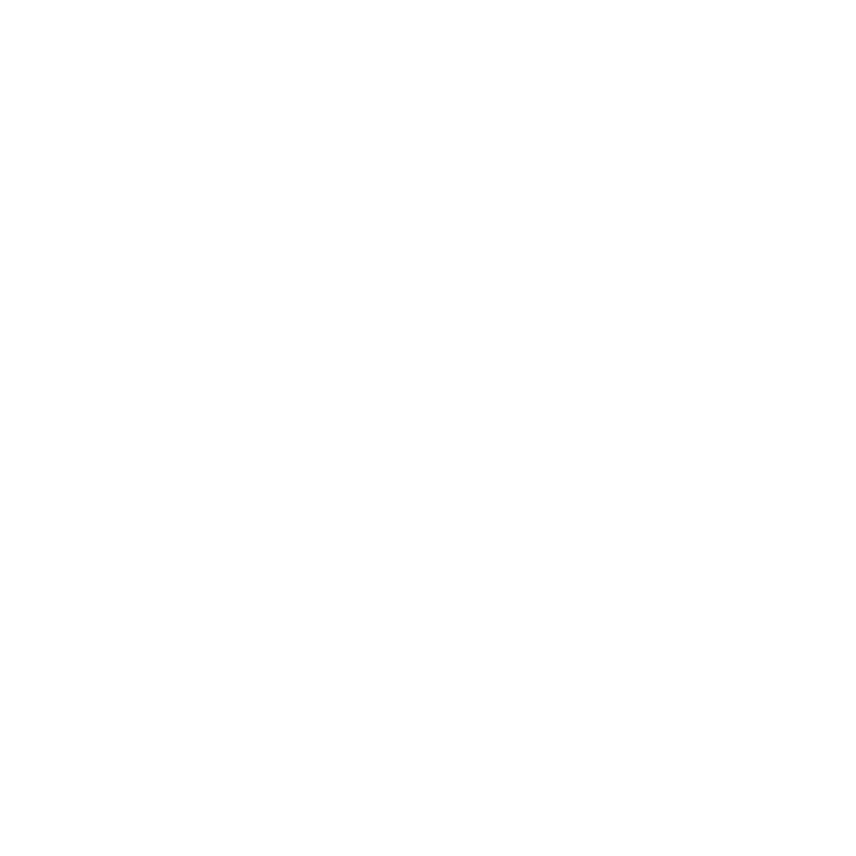

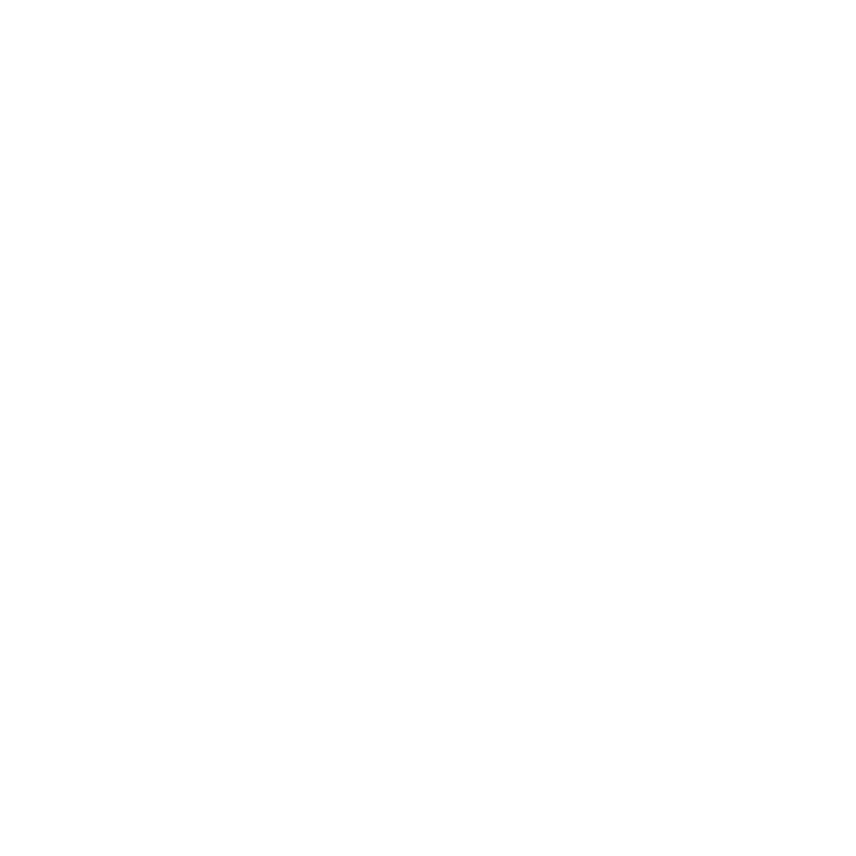

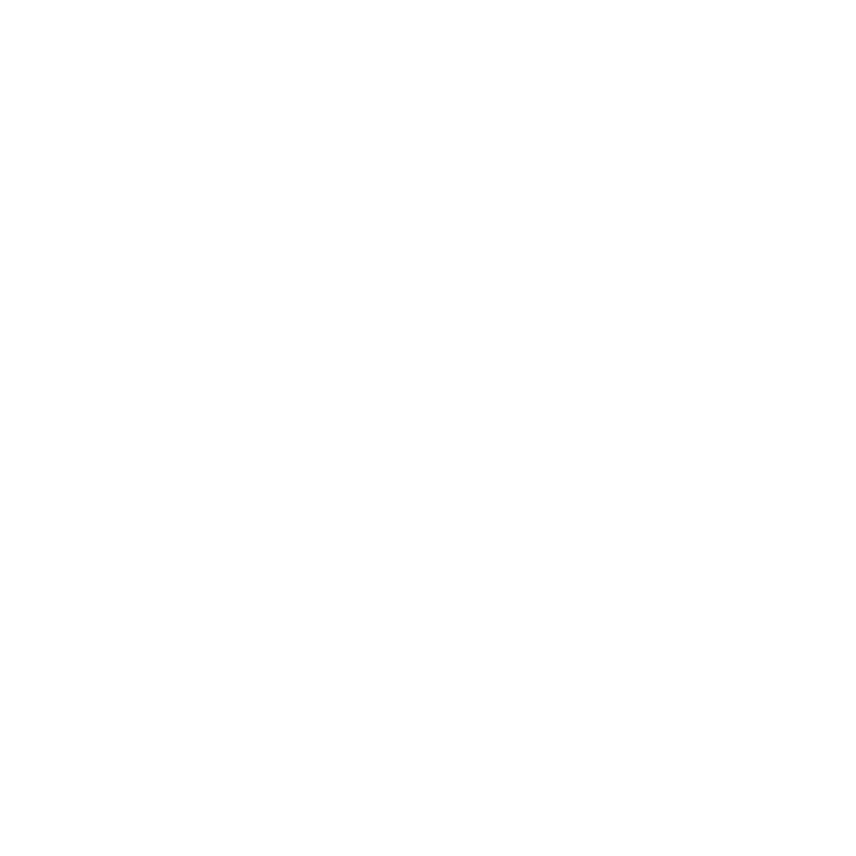

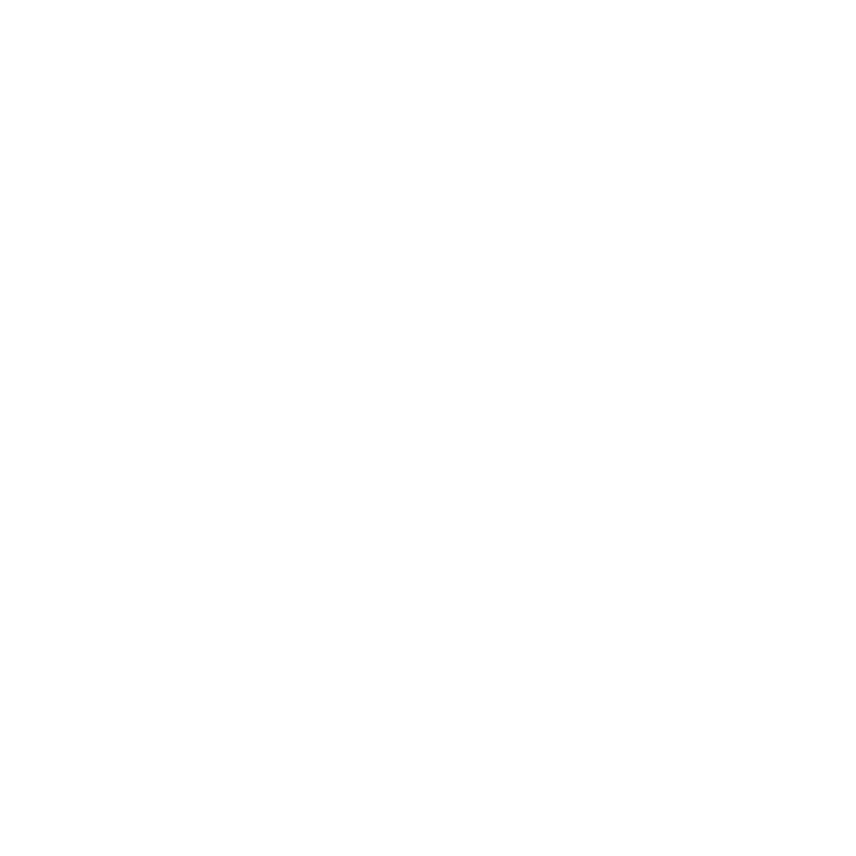

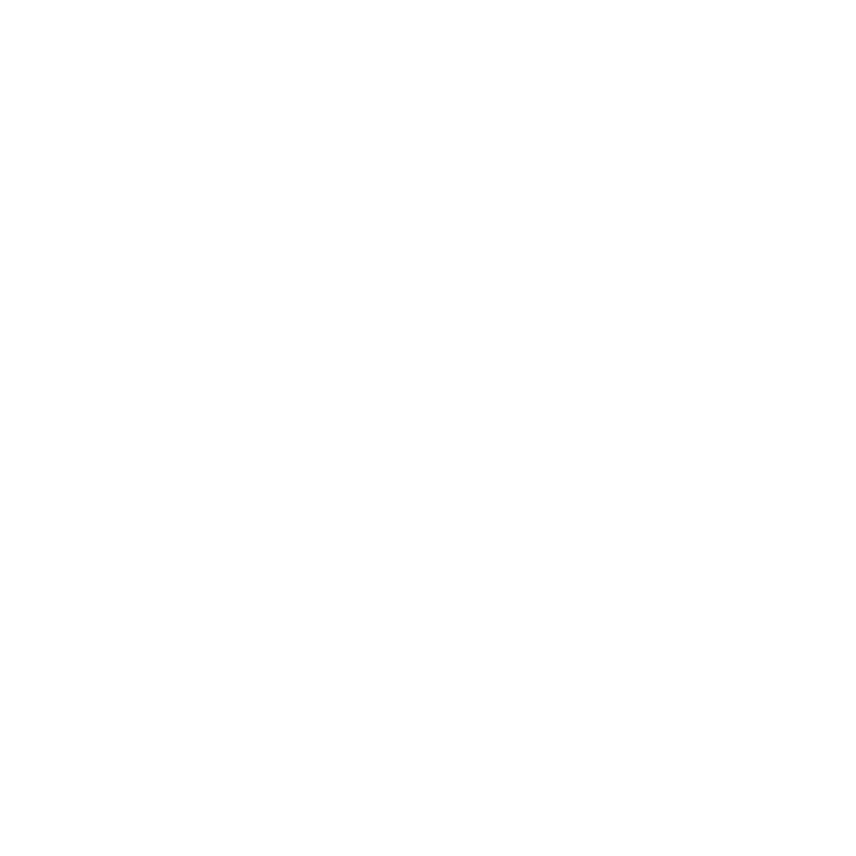

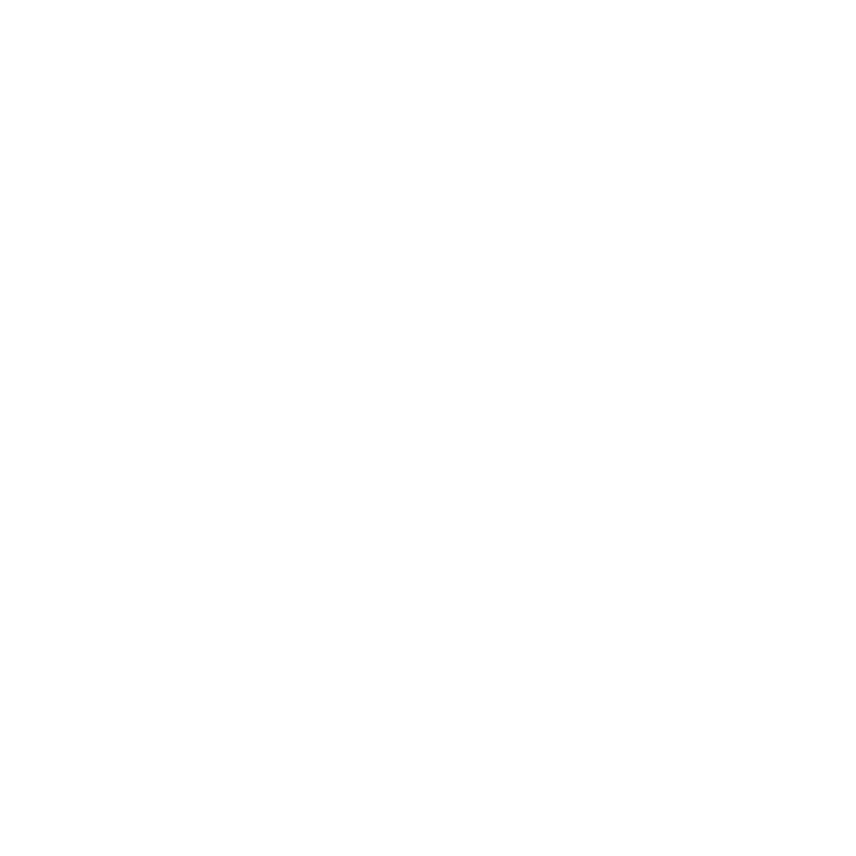

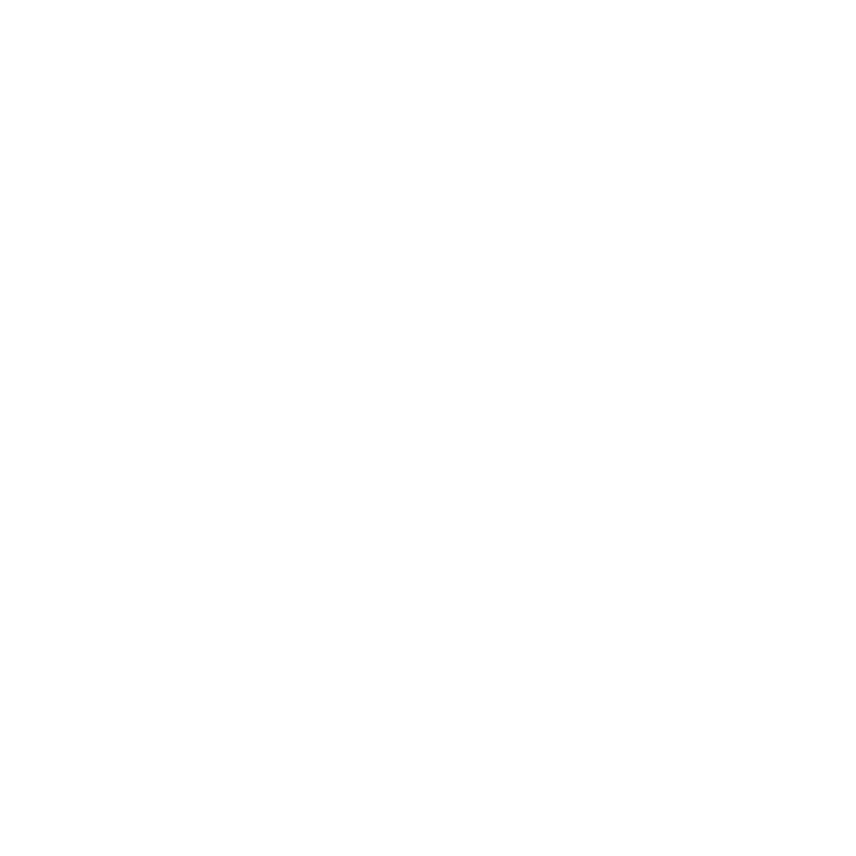

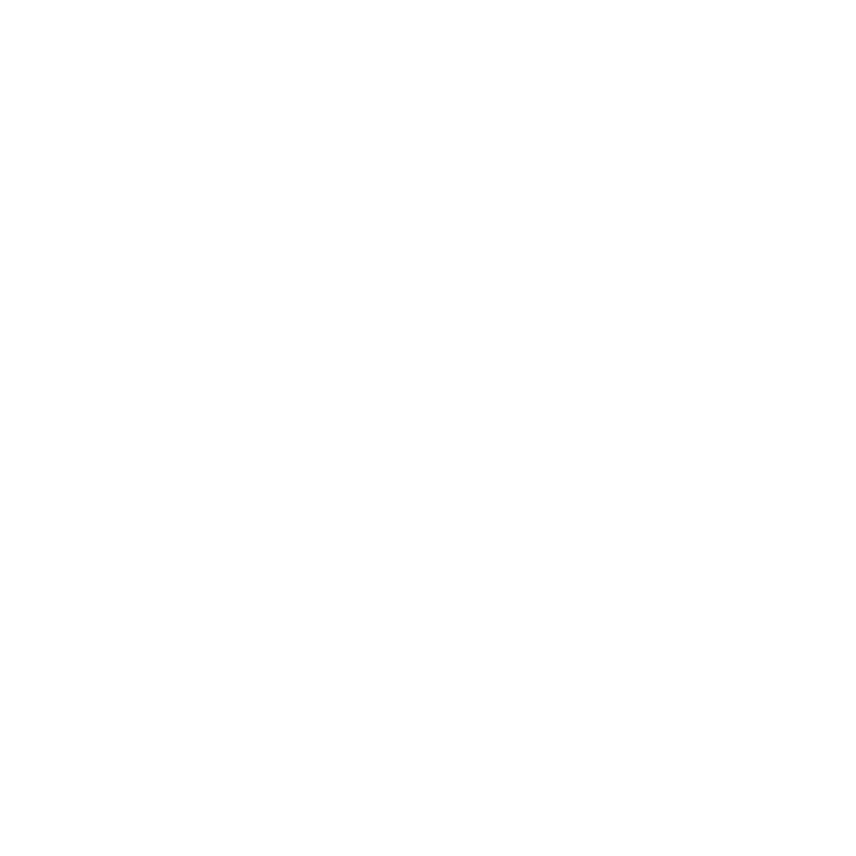

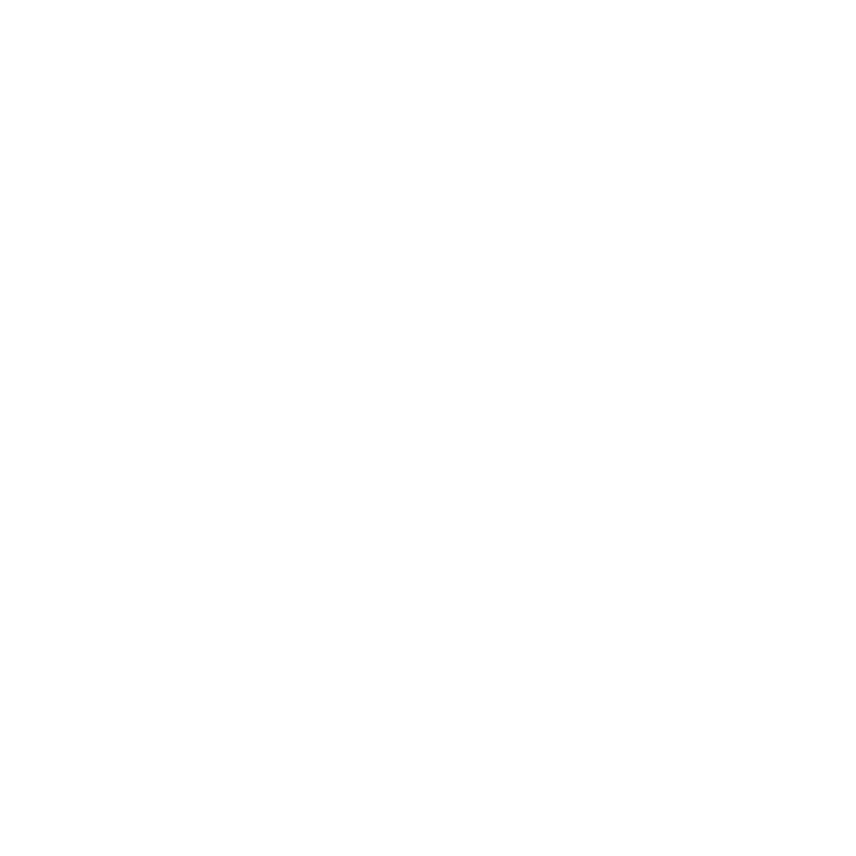

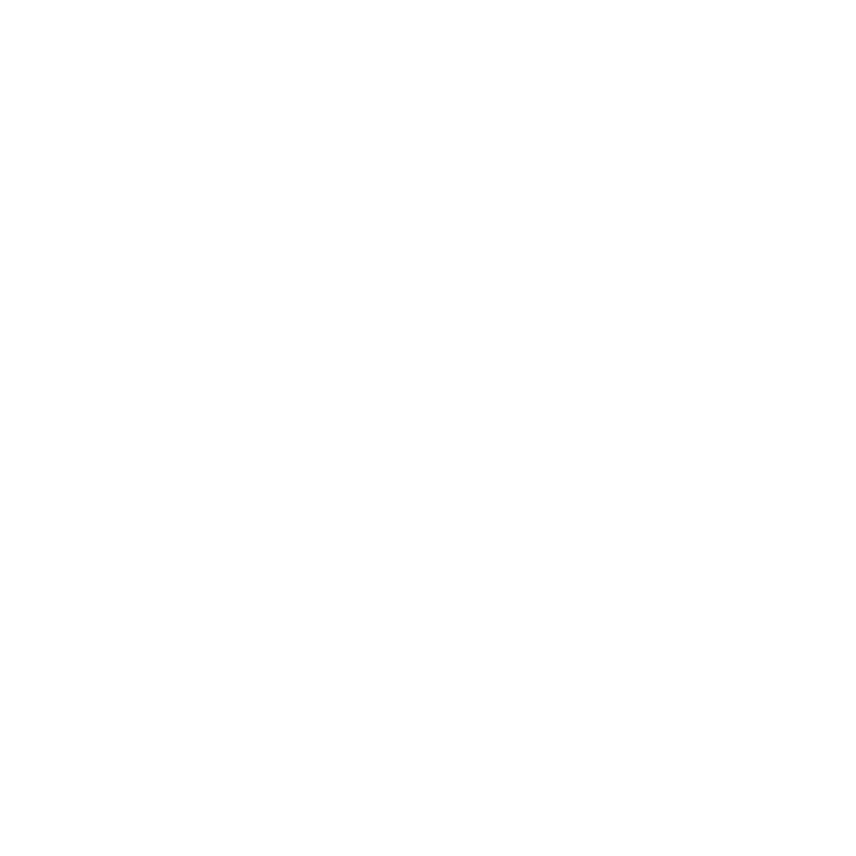

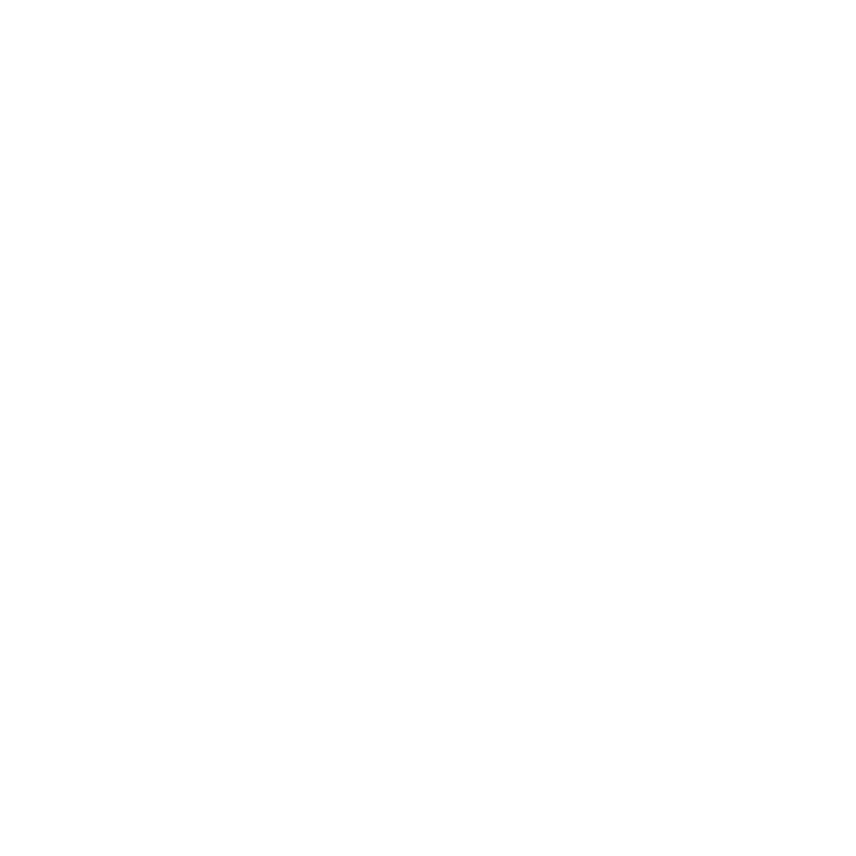

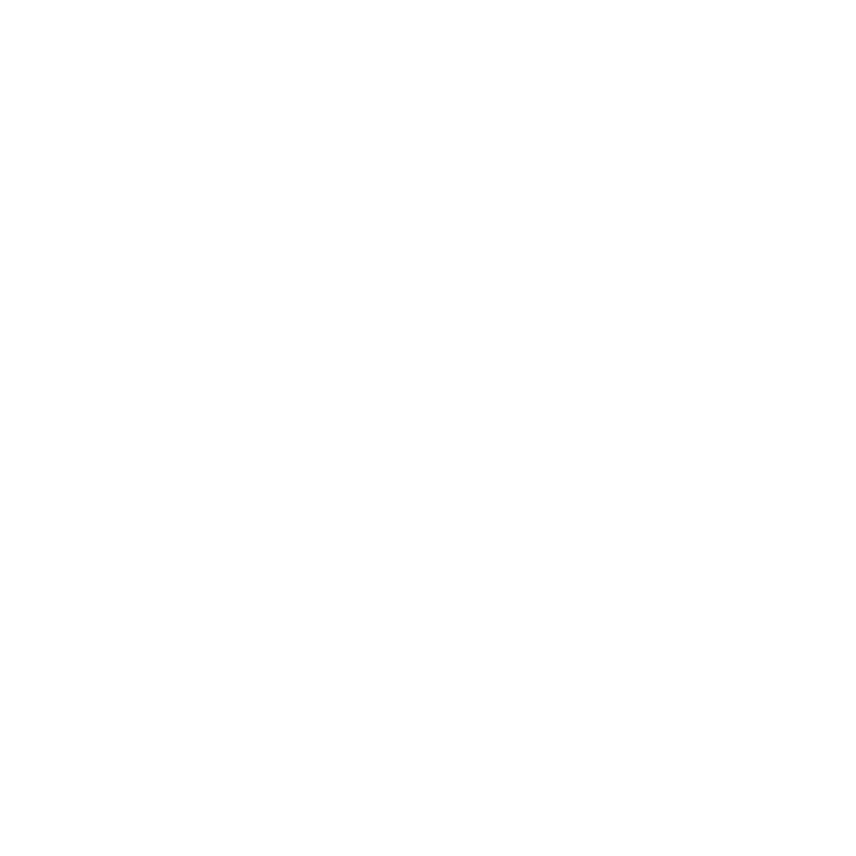

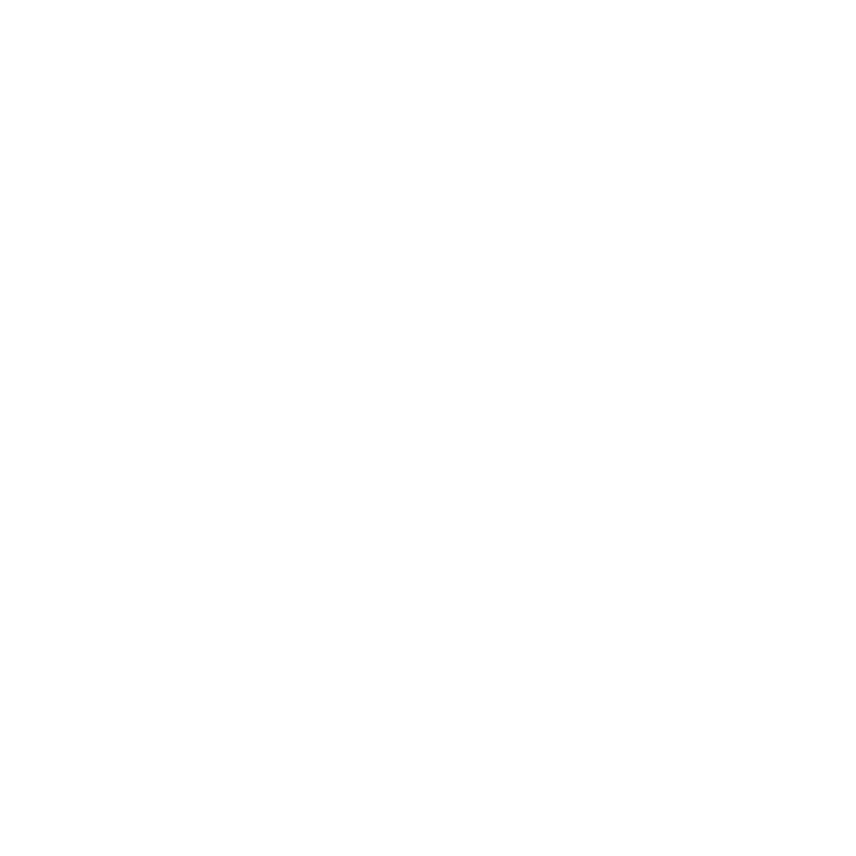

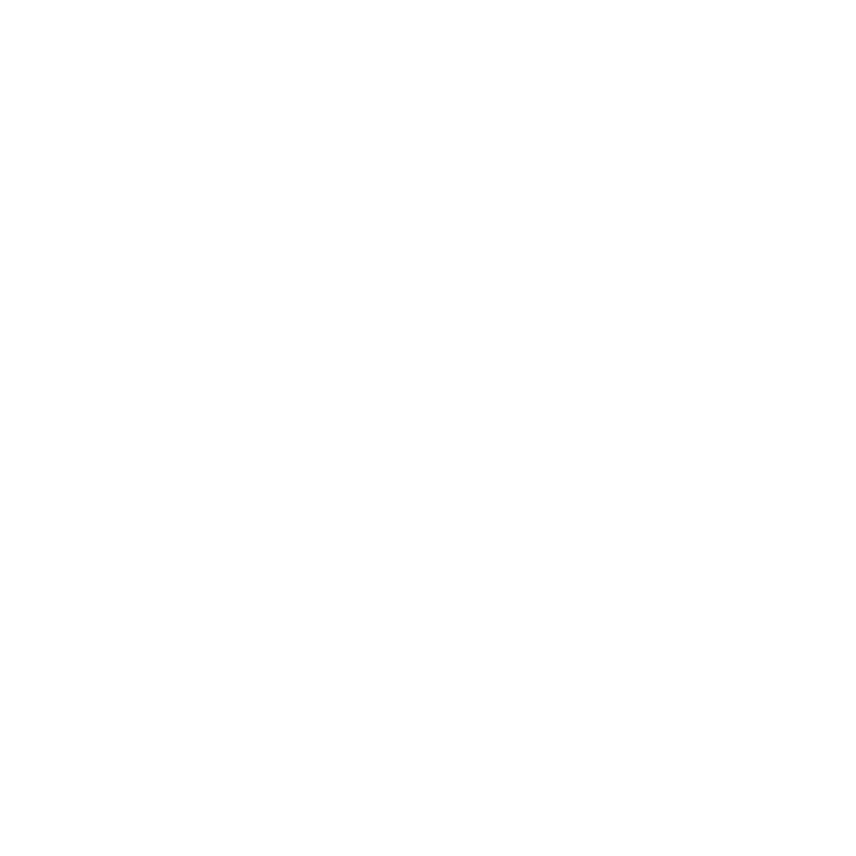

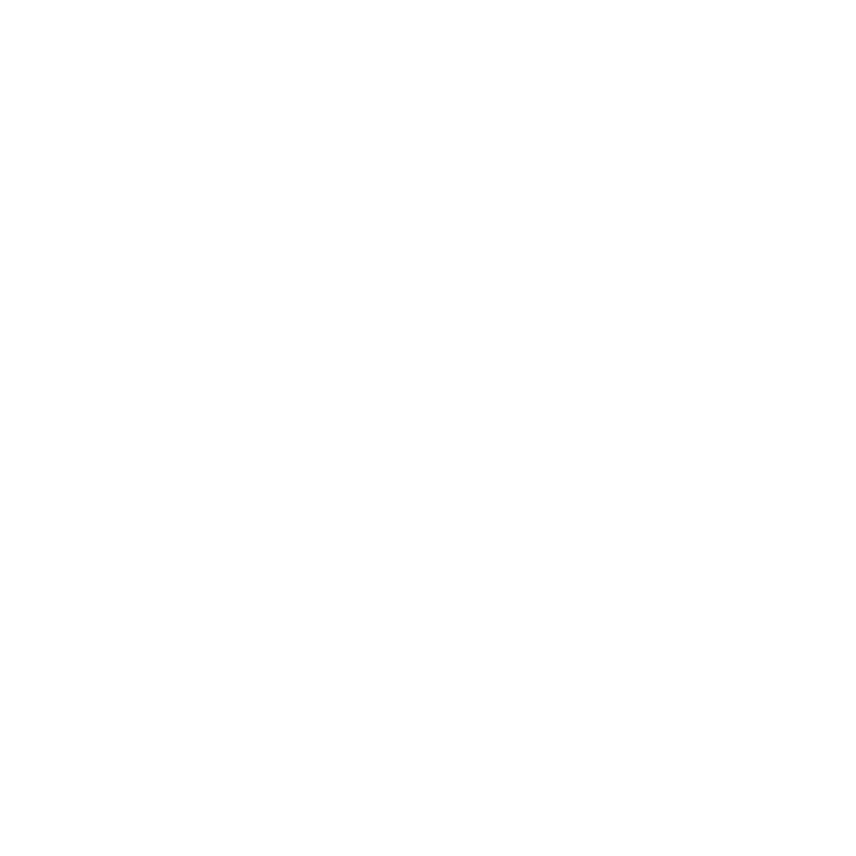

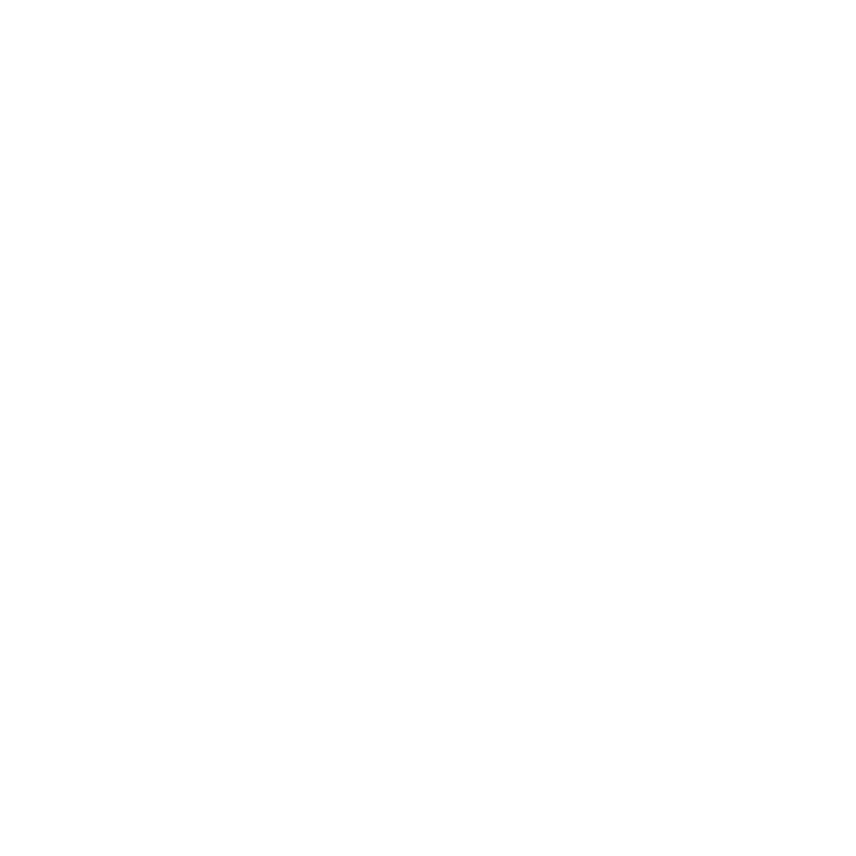

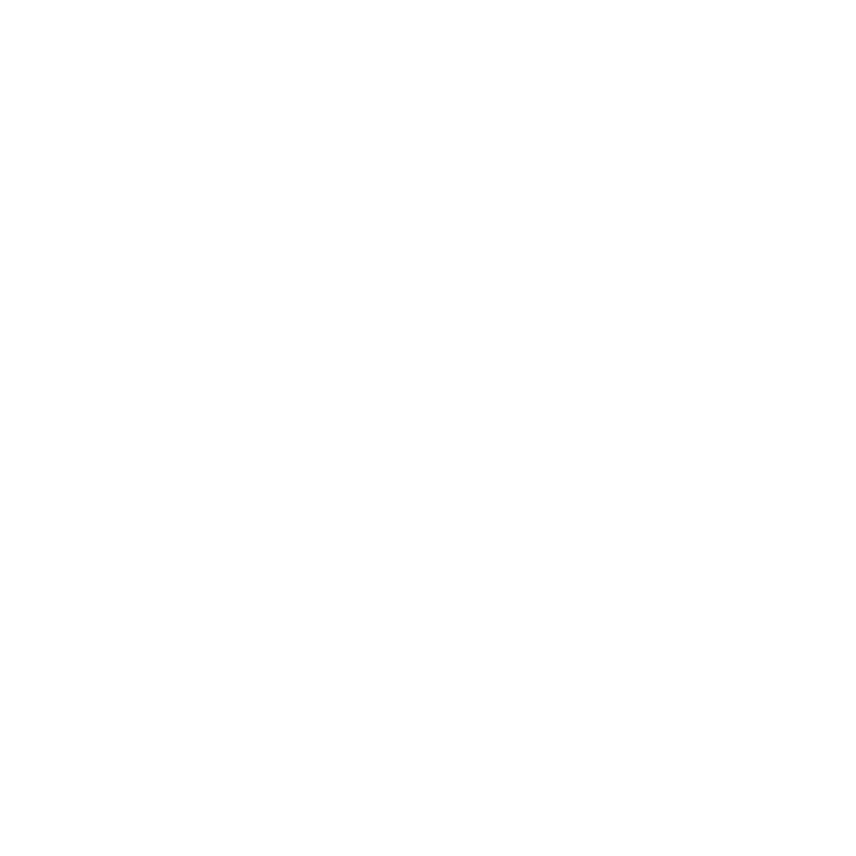

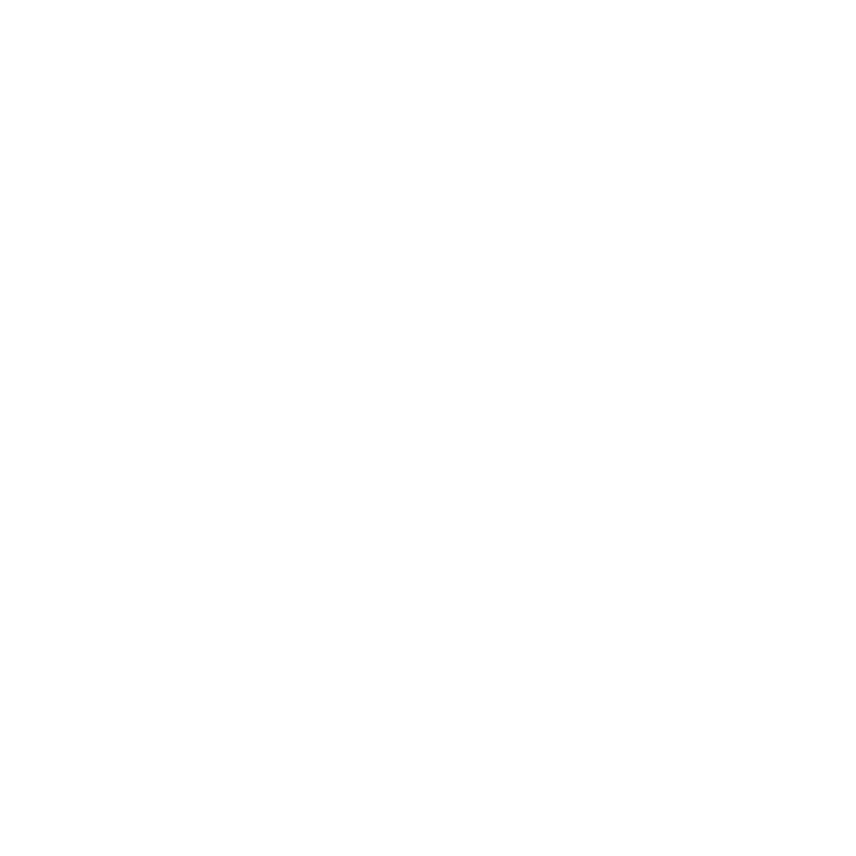

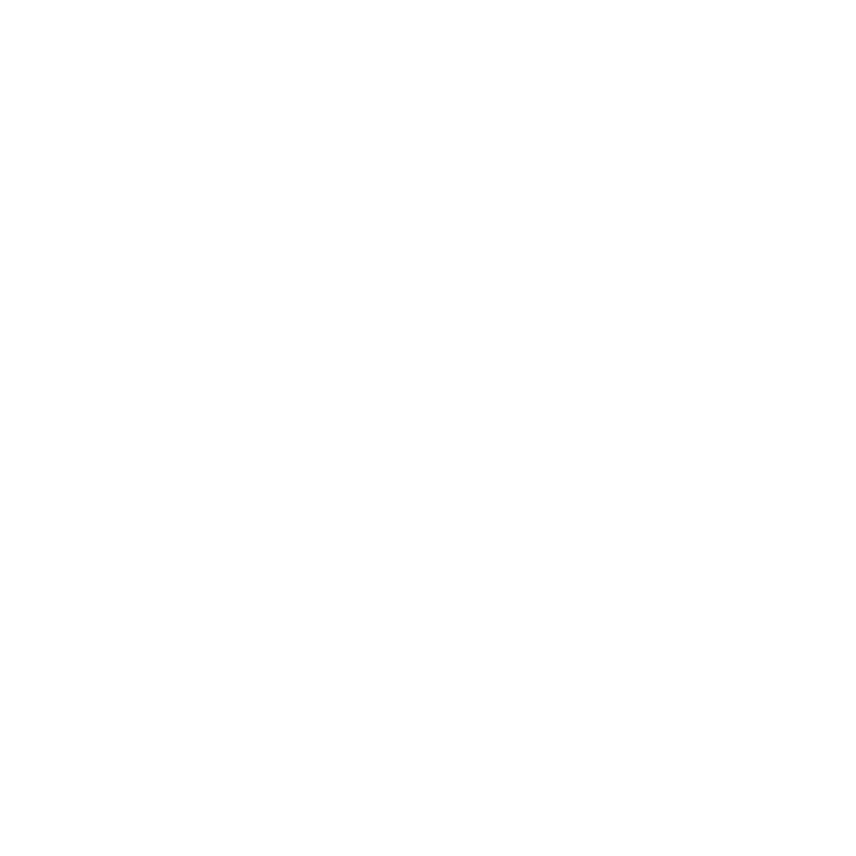

In [18]:
Tmax = value(instance.obj1)
#for t in np.linspace(0,Tmax, 5):
xmax, ymax = 120,120
counter = 0 
M = 100
T = [Tmax*2.2*counter/M for counter in range(M)]
T+=[Tmax for i in range(5)]
T.sort()
T
plt.figure(figsize=(12,12))
for t in T:  
    plt.figure(figsize=(12,12))
    X=[x0+value(instance.V0[i]*cos(instance.alpha[i]))*(t-df.loc[i-1,'ti']) for i in instance.i if t>df.loc[i-1,'ti'] and y0+-5*(t-df.loc[i-1,'ti'])**2 + value(instance.V0[i]*sin(instance.alpha[i]) )*(t-df.loc[i-1,'ti'])>0 and x0+value(instance.V0[i]*cos(instance.alpha[i]))*(t-df.loc[i-1,'ti']) < xmax]
    Y=[y0+-5*(t-df.loc[i-1,'ti'])**2 + value(instance.V0[i]*sin(instance.alpha[i]) )*(t-df.loc[i-1,'ti']) for i in instance.i if t>df.loc[i-1,'ti'] and y0+-5*(t-df.loc[i-1,'ti'])**2 + value(instance.V0[i]*sin(instance.alpha[i]) )*(t-df.loc[i-1,'ti'])>0 and x0+value(instance.V0[i]*cos(instance.alpha[i]))*(t-df.loc[i-1,'ti'])<xmax]
    plt.scatter(X,Y,s=6)
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('logo '+ str(counter)+  ' .png', format='png', dpi=200)
    print(t)
    counter+=1